# Team Based Model

## Imports

In [53]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDClassifier
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [125]:
def load_team_1H_data():
    """Loads basic, advanced, and scoring boxscores from
    seasons 2000-2019 and merges them into one dataframe
    """
    seasons = ['200{}-0{}'.format(x, x+1) if x != 9 else '200{}-{}'.format(x, x+1) for x in range(6,10)]
    seasons2 = ['20{}-{}'.format(x, x+1) for x in range(10, 20)]
    seasons.extend(seasons2)

    basic_gls_all, adv_gls_all, scoring_gls_all = [], [], []
    for season in seasons:
        basic_gls = pd.read_csv('../data/basic_team_boxscores_1H/team_boxscores_1H_{}.csv'.format(season))
        basic_gls_all.append(basic_gls)

        adv_gls = pd.read_csv('../data/advanced_team_boxscores_1H/team_advanced_1H_{}.csv'.format(season))
        adv_gls_all.append(adv_gls)

        scoring_gls = pd.read_csv('../data/scoring_team_boxscores_1H/team_scoring_1H_{}.csv'.format(season))
        scoring_gls_all.append(scoring_gls)

    basic_gls_all_df = pd.concat(basic_gls_all)
    adv_gls_all_df = pd.concat(adv_gls_all)
    scoring_gls_all_df = pd.concat(scoring_gls_all)

    temp = pd.merge(basic_gls_all_df, adv_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls_all_df, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'TEAM_ID_y', 'TEAM_NAME_y',
                                       'TEAM_CITY_y', 'MIN_y', 'PIE_y', 'TEAM_CITY',
                                     'OREB_PCT', 'DREB_PCT', 'REB_PCT'])
    return full_df


df = load_team_1H_data()
df

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID            GAME_DATE      MATCHUP WL   MIN  FGM  FGA  FG_PCT  \
0      20601225  2007-04-18T00:00:00  MIN vs. MEM  L  24.0   21   48   0.438   
1      20601229  2007-04-18T00:00:00    DAL @ SEA  W  24.0   25   43   0.581   
2      20601224  2007-04-18T00:00:00    DEN @ SAS  W  24.0   20   41   0.488   
3      20601223  2007-04-18T00:00:00  IND vs. WAS  L  24.0   21   46   0.457   
4      20601226  2007-04-18T00:00:00    HOU @ UTA  L  24.0   19   39   0.487   
...         ...                  ...          ... ..   ...  ...  ...     ...   
35939  41900161  2020-08-17T00:00:00    UTA @ DEN  L  24.0   19   46   0.413   
35940  41900111  2020-08-17T00:00:00    BKN @ TOR  L  24.0   19   42   0.452   
35941  41900121  2020-08-17T00:00:00    PHI @ BOS  L  24.0   20   36   0.556   
35942  41900111  2020-08-17T00:00:00  TOR vs. BKN  W  24.0   24   49   0.490   
35943  41900151  2020-08-17T00:00:00  LAC vs. DAL  W  24.0   25   46   0.543   

       FG3M  FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  \
0         3     5    0.600    6    8   0.750    10    13   23   10   9.0    5   
1         3     8    0.375    8   10   0.800     7    16   23   15   3.0    3   
2         6    13    0.462    0    6   0.000     4    20   24   13   8.0    4   
3         6     9    0.667    5    5   1.000     5    14   19    8   5.0    2   
4         5    12    0.417    4    5   0.800     2    11   13   10   8.0    3   
...     ...   ...      ...  ...  ...     ...   ...   ...  ...  ...   ...  ...   
35939     8    22    0.364    6    8   0.750     6    18   24    9   7.0    4   
35940     7    24    0.292    6    9   0.667     1    20   21   17  10.0    2   
35941     5    13    0.385    4    7   0.571     6    17   23   14  13.0    3   
35942    11    23    0.478   14   15   0.933     5    20   25   17   5.0    2   
35943     8    17    0.471    8   11   0.727     3    12   15   11   7.0    8   

       BLK  BLKA  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0        3     3  12    8   51        -3.0         101.0       104.1   
1        3     2  10    7   61        24.0         140.6       141.9   
2        1     1  13    8   46         6.0          96.6       100.0   
3        1     4  10    6   53        -5.0         110.0       115.2   
4        1     0  16    8   47        -3.0          99.6       102.2   
...    ...   ...  ..  ...  ...         ...           ...         ...   
35939    1     2  10   10   52        -7.0         102.9       106.1   
35940    1     2  17   13   51       -22.0          92.8        94.4   
35941    3     1  10   10   49        -6.0         106.3       106.5   
35942    2     1  13   17   73        22.0         131.3       137.7   
35943    2     1  14   10   66        -3.0         120.4       122.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  \
0             106.7       110.2          -5.8        -6.1    0.476     1.11   
1              82.5        84.1          58.0        57.8    0.600     5.00   
2              87.5        88.9           9.1        11.1    0.650   

In [126]:
df.to_csv("merged_data_1H.csv", index=False)

In [127]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    
    abbr_mapping = {'NJN':'BKN',
                   'CHH':'CHA',
                   'VAN':'MEM',
                   'NOH':'NOP',
                   'NOK':'NOP',
                   'SEA':'OKC'}
    
    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')


    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)
    df = df.dropna(subset = ['E_OFF_RATING'])
    
    return df

clean_df = clean_team_data(df)
clean_df

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  WL   MIN  FGM  FGA  FG_PCT  FG3M  \
0      20601225 2007-04-18  MIN vs. MEM   0  24.0   21   48   0.438     3   
1      20601229 2007-04-18    DAL @ OKC   1  24.0   25   43   0.581     3   
2      20601224 2007-04-18    DEN @ SAS   1  24.0   20   41   0.488     6   
3      20601223 2007-04-18  IND vs. WAS   0  24.0   21   46   0.457     6   
4      20601226 2007-04-18    HOU @ UTA   0  24.0   19   39   0.487     5   
...         ...        ...          ...  ..   ...  ...  ...     ...   ...   
35939  41900161 2020-08-17    UTA @ DEN   0  24.0   19   46   0.413     8   
35940  41900111 2020-08-17    BKN @ TOR   0  24.0   19   42   0.452     7   
35941  41900121 2020-08-17    PHI @ BOS   0  24.0   20   36   0.556     5   
35942  41900111 2020-08-17  TOR vs. BKN   1  24.0   24   49   0.490    11   
35943  41900151 2020-08-17  LAC vs. DAL   1  24.0   25   46   0.543     8   

       FG3A  FG3_PCT  FTM  FTA  FT_PCT  OREB  DREB  REB  AST   TOV  STL  BLK  \
0         5    0.600    6    8   0.750    10    13   23   10   9.0    5    3   
1         8    0.375    8   10   0.800     7    16   23   15   3.0    3    3   
2        13    0.462    0    6   0.000     4    20   24   13   8.0    4    1   
3         9    0.667    5    5   1.000     5    14   19    8   5.0    2    1   
4        12    0.417    4    5   0.800     2    11   13   10   8.0    3    1   
...     ...      ...  ...  ...     ...   ...   ...  ...  ...   ...  ...  ...   
35939    22    0.364    6    8   0.750     6    18   24    9   7.0    4    1   
35940    24    0.292    6    9   0.667     1    20   21   17  10.0    2    1   
35941    13    0.385    4    7   0.571     6    17   23   14  13.0    3    3   
35942    23    0.478   14   15   0.933     5    20   25   17   5.0    2    2   
35943    17    0.471    8   11   0.727     3    12   15   11   7.0    8    2   

       BLKA  PF  PFD  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  E_DEF_RATING  \
0         3  12    8   51        -3.0         101.0       104.1         106.7   
1         2  10    7   61        24.0         140.6       141.9          82.5   
2         1  13    8   46         6.0          96.6       100.0          87.5   
3         4  10    6   53        -5.0         110.0       115.2         128.8   
4         0  16    8   47        -3.0          99.6       102.2         103.4   
...     ...  ..  ...  ...         ...           ...         ...           ...   
35939     2  10   10   52        -7.0         102.9       106.1         120.2   
35940     2  17   13   51       -22.0          92.8        94.4         131.3   
35941     1  10   10   49        -6.0         106.3       106.5         118.2   
35942     1  13   17   73        22.0         131.3       137.7          92.8   
35943     1  14   10   66        -3.0         120.4       122.2         123.1   

       DEF_RATING  E_NET_RATING  NET_RATING  AST_PCT  AST_TOV  AST_RATIO  \
0           110.2          -5.8        -6.1    0.476     1.11       14.2   
1            84.1          58.0        57.8    0.600     5.00       22.9   
2            88.9 

In [128]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()
    
    df = df.drop(columns=['FT_PCT', 'FG_PCT', 'FG3_PCT', 'AST_PCT', 'AST_TOV',
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT',
                          'PACE', 'PACE_PER40'])
    
    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['PTS_FB'] = (df['PTS'] * df['PCT_PTS_FB']).astype('int8')
    df['PTS_OFF_TOV'] = (df['PTS'] * df['PCT_PTS_OFF_TOV']).astype('int8')
    df['PTS_PAINT'] = (df['PTS'] * df['PCT_PTS_PAINT']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')    

    df = df.drop(columns = ['PCT_PTS_2PT', 'PCT_PTS_2PT_MR', 
                            'PCT_PTS_3PT', 'PCT_PTS_FB',
                            'PCT_PTS_OFF_TOV', 'PCT_PTS_PAINT',
                            'PCT_AST_2PM', 'PCT_UAST_2PM', 
                            'PCT_AST_3PM', 'PCT_UAST_3PM', 
                            'PCT_AST_FGM', 'PCT_UAST_FGM', 
                            'FGM', 'FGA'])

    df['point_diff'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    df = df[['SEASON_YEAR', 'TEAM_ID',
      'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
      'MATCHUP', 'HOME_GAME', 'TEAM_SCORE', 'point_diff', 'WL', 'MIN', 'RECORD',
      'FG2M', 'FG2A', 'FG3M', 'FG3A', 'FTM', 'FTA',
      'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
      'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING', 
      'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 
      'POSS', 'PIE', 'PTS_2PT_MR', 'PTS_FB', 'PTS_OFF_TOV',
      'PTS_PAINT', 'AST_2PM', 'UAST_2PM', 'AST_3PM', 'UAST_3PM']]

    
    return df



clean_df2 = prep_for_aggregation(clean_df)

In [129]:
clean_df2

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  \
0      20601225 2007-04-18  MIN vs. MEM          1          51        -3.0   
1      20601229 2007-04-18    DAL @ OKC          0          61        24.0   
2      20601224 2007-04-18    DEN @ SAS          0          46         6.0   
3      20601223 2007-04-18  IND vs. WAS          1          53        -5.0   
4      20601226 2007-04-18    HOU @ UTA          0          47        -3.0   
...         ...        ...          ...        ...         ...         ...   
35939  41900161 2020-08-17    UTA @ DEN          0          52        -7.0   
35940  41900111 2020-08-17    BKN @ TOR          0          51       -22.0   
35941  41900121 2020-08-17    PHI @ BOS          0          49        -6.0   
35942  41900111 2020-08-17  TOR vs. BKN          1          73        22.0   
35943  41900151 2020-08-17  LAC vs. DAL          1          66        -3.0   

       WL   MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  \
0       0  24.0       0    18    43     3     5    6    8    10    13   23   
1       1  24.0       1    22    35     3     8    8   10     7    16   23   
2       1  24.0       1    14    28     6    13    0    6     4    20   24   
3       0  24.0       0    15    37     6     9    5    5     5    14   19   
4       0  24.0       0    14    27     5    12    4    5     2    11   13   
...    ..   ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...   
35939   0  24.0       0    11    24     8    22    6    8     6    18   24   
35940   0  24.0       0    12    18     7    24    6    9     1    20   21   
35941   0  24.0       0    15    23     5    13    4    7     6    17   23   
35942   1  24.0       1    13    26    11    23   14   15     5    20   25   
35943   1  24.0       1    17    29     8    17    8   11     3    12   15   

       AST  STL  BLK   TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0       10    5    3   9.0  12   51        -3.0         101.0       104.1   
1       15    3    3   3.0  10   61        24.0         140.6       141.9   
2       13    4    1   8.0  13   46         6.0          96.6       100.0   
3        8    2    1   5.0  10   53        -5.0         110.0       115.2   
4       10    3    1   8.0  16   47        -3.0          99.6       102.2   
...    ...  ...  ...   ...  ..  ...         ...           ...         ...   
35939    9    4    1   7.0  10   52        -7.0         102.9       106.1   
35940   17    2    1  10.0  17   51       -22.0          92.8        94.4   
35941   14    3    3  13.0  10   49        -6.0         106.3       106.5   
35942   17    2    2   5.0  13   73        22.0         131.3       137.7   
35943   11    8    2   7.0  14   66        -3.0         120.4       122.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS    PIE  \
0             106.7       110.2          -5.8        -6.1  49.0  0.397   
1              82.5        84.1          58.0        57.8  43.0  0.798   
2              87.5        88.9           9.1        11.1  46.0  0.620   
3         

## Add Betting Data 

In [130]:
spread_df = pd.read_csv('../data/spreads_1H.csv', parse_dates=['game_date'])
spread_df.head()

away_team     home_team  game_date            away_1H_spread  \
0   Chicago         Miami 2006-10-31  '-', '-', '+2½-110', '-'   
1   Phoenix   L.A. Lakers 2006-10-31  '-', '-', '-4½-115', '-'   
2   Indiana     Charlotte 2006-11-01   '-', '-', 'PK-110', '-'   
3   Chicago       Orlando 2006-11-01   '-', '-', 'PK-120', '-'   
4   Atlanta  Philadelphia 2006-11-01  '-', '-', '+2½-105', '-'   

             home_1H_spread  
0  '-', '-', '-2½-110', '-'  
1  '-', '-', '+4½-105', '-'  
2   '-', '-', 'PK-110', '-'  
3   '-', '-', 'PK+100', '-'  
4  '-', '-', '-2½-115', '-'

In [131]:
spread_df.to_csv("spread_data_1H.csv", index=False)

In [132]:
missing_dates = set([])
# spread_df.loc[spread_df['away_1H_spread'] == "-, -, -, -"]
# spread_df.loc[spread_df['home_1H_spread'] == "-, -, -, -"]
dates = spread_df.loc[spread_df['home_1H_spread'].isnull(), 'game_date'].astype(str)
missing_dates.update(dates)
# spread_df.loc[274:274]

In [133]:
def clean_spread_data(df):

    abbr_mapping = {'Boston':'BOS', 'Portland':'POR', 
                'L.A. Lakers':'LAL', 'Brooklyn':'BKN', 
                'Cleveland':'CLE', 'Toronto':'TOR',
                'Philadelphia':'PHI', 'Memphis':'MEM',
                'Minnesota':'MIN', 'New Orleans':'NOP',
               'Oklahoma City':'OKC', 'Dallas':'DAL', 
                'San Antonio':'SAS', 'Denver':'DEN', 
                'Golden State':'GSW', 'L.A. Clippers':'LAC', 
                'Orlando':'ORL', 'Utah':'UTA', 
                'Charlotte':'CHA', 'Detroit':'DET',
               'Miami':'MIA', 'Phoenix':'PHX',
                'Atlanta':'ATL', 'New York':'NYK', 
                'Indiana':'IND', 'Chicago':'CHI',
               'Houston':'HOU', 'Milwaukee':'MIL',
                'Sacramento':'SAC', 'Washington':'WAS'}

    df['home_team'] = df['home_team'].replace(abbr_mapping)
    df['away_team'] = df['away_team'].replace(abbr_mapping)
    
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("'", "")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("½", ".5")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("PK", "0")
    df['away_1H_spread'] = df['away_1H_spread'].str.replace("+", "")

    
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("'", "")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("½", ".5")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("PK", "0")
    df['home_1H_spread'] = df['home_1H_spread'].str.replace("+", "")


    away_spreads = df['away_1H_spread'].str.split(',', expand=True)
    home_spreads = df['home_1H_spread'].str.split(',', expand=True)
    away_spreads.columns = ['away_spread_1H_1', 'away_spread_1H_2', 'away_spread_1H_3', 'away_spread_1H_4']
    home_spreads.columns = ['home_spread_1H_1', 'home_spread_1H_2', 'home_spread_1H_3', 'home_spread_1H_4']
    
    full_df = pd.concat([df, away_spreads, home_spreads], axis=1)
    full_df = full_df.drop(columns=['away_1H_spread', 'home_1H_spread'])

    for col in full_df.columns[3:]:
        full_df[col] = full_df[col].str.strip()
        full_df[col] = full_df[col].str[:-3]
        full_df.loc[full_df[col] == '', col] = np.nan
#         full_df.loc[full_df[col] == '-', col] = np.nan
#         full_df.loc[full_df[col] == '-.', col] = 0
        
#     for col in full_df.columns[3:]:
#         full_df[col] = full_df[col].str.replace('[', '')
#         full_df[col] = full_df[col].str.replace(']', '')
#         full_df[col] = full_df[col].str.replace("'", '')
#         full_df[col] = full_df[col].str.strip()

        
    for col in full_df.columns[3:]:
        full_df[col] = full_df[col].apply(lambda x: str(x)[:-1] if str(x)[-1] == '-' else x)
        full_df[col] = full_df[col].astype(float)
        
    full_df['away_spread_1H'] = full_df[['away_spread_1H_1', 'away_spread_1H_2', 
                                           'away_spread_1H_3', 'away_spread_1H_4']].mode(axis=1)[0]
    full_df['home_spread_1H'] = full_df[['home_spread_1H_1', 'home_spread_1H_2',
                                           'home_spread_1H_3', 'home_spread_1H_4']].mode(axis=1)[0]

    return full_df

clean_spread_df = clean_spread_data(spread_df)
clean_spread_df

away_team home_team  game_date  away_spread_1H_1  away_spread_1H_2  \
0           CHI       MIA 2006-10-31               NaN               NaN   
1           PHX       LAL 2006-10-31               NaN               NaN   
2           IND       CHA 2006-11-01               NaN               NaN   
3           CHI       ORL 2006-11-01               NaN               NaN   
4           ATL       PHI 2006-11-01               NaN               NaN   
...         ...       ...        ...               ...               ...   
17702       UTA       MEM 2019-11-29              -3.5              -3.0   
17703       LAC       SAS 2019-11-29              -2.5              -2.5   
17704       DAL       PHX 2019-11-29              -0.5               0.0   
17705       CHI       POR 2019-11-29               4.0               3.5   
17706       WAS       LAL 2019-11-29               7.0               7.0   

       away_spread_1H_3  away_spread_1H_4  home_spread_1H_1  home_spread_1H_2  \
0                   2.5               NaN               NaN               NaN   
1                  -4.5               NaN               NaN               NaN   
2                   0.0               NaN               NaN               NaN   
3                   0.0               NaN               NaN               NaN   
4                   2.5               NaN               NaN               NaN   
...                 ...               ...               ...               ...   
17702              -4.0              -3.5               3.5               3.0   
17703              -2.5              -2.5               2.5               2.5   
17704              -0.5              -1.0               0.5               0.0   
17705               3.5               4.0              -4.0              -3.5   
17706               7.0               7.0              -7.0              -7.0   

       home_spread_1H_3  home_spread_1H_4  away_spread_1H  home_spread_1H  
0                  -2.5               NaN             2.5            -2.5  
1                   4.5               NaN            -4.5             4.5  
2                   0.0               NaN             0.0             0.0  
3                   0.0               NaN             0.0             0.0  
4                  -2.5               NaN             2.5            -2.5  
...                 ...               ...             ...             ...  
17702               4.0               3.5            -3.5             3.5  
17703               2.5               2.5            -2.5             2.5  
17704               0.5               1.0            -0.5             0.5  
17705              -3.5              -4.0             3.5            -4.0  
17706              -7.0              -7.0             7.0            -7.0  

[17707 rows x 13 columns]

In [134]:
def add_spread_data(df, clean_spread_df):
    df = df.copy()
    df['home_team'] = df['MATCHUP'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP']]
    
    df = pd.merge(df, clean_spread_df[['away_team', 'home_team', 'game_date', 'away_spread_1H', 'home_spread_1H']], 
                      how='left', left_on=['home_team', 'away_team', 'GAME_DATE'], 
                      right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff'] + row['home_spread_1H'] > 0) 
                                          if row['HOME_GAME'] == 1 else int(row['point_diff'] 
                                                                            + row['away_spread_1H'] > 0), axis=1)

    return df


clean_df_spread = add_spread_data(clean_df2, clean_spread_df)
clean_df_spread

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0         2006-07  1610612750               MIN  Minnesota Timberwolves   
1         2006-07  1610612742               DAL        Dallas Mavericks   
2         2006-07  1610612743               DEN          Denver Nuggets   
3         2006-07  1610612754               IND          Indiana Pacers   
4         2006-07  1610612745               HOU         Houston Rockets   
...           ...         ...               ...                     ...   
35939     2019-20  1610612762               UTA               Utah Jazz   
35940     2019-20  1610612751               BKN           Brooklyn Nets   
35941     2019-20  1610612755               PHI      Philadelphia 76ers   
35942     2019-20  1610612761               TOR         Toronto Raptors   
35943     2019-20  1610612746               LAC             LA Clippers   

        GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  TEAM_SCORE  point_diff  \
0      20601225 2007-04-18  MIN vs. MEM          1          51        -3.0   
1      20601229 2007-04-18    DAL @ OKC          0          61        24.0   
2      20601224 2007-04-18    DEN @ SAS          0          46         6.0   
3      20601223 2007-04-18  IND vs. WAS          1          53        -5.0   
4      20601226 2007-04-18    HOU @ UTA          0          47        -3.0   
...         ...        ...          ...        ...         ...         ...   
35939  41900161 2020-08-17    UTA @ DEN          0          52        -7.0   
35940  41900111 2020-08-17    BKN @ TOR          0          51       -22.0   
35941  41900121 2020-08-17    PHI @ BOS          0          49        -6.0   
35942  41900111 2020-08-17  TOR vs. BKN          1          73        22.0   
35943  41900151 2020-08-17  LAC vs. DAL          1          66        -3.0   

       WL   MIN  RECORD  FG2M  FG2A  FG3M  FG3A  FTM  FTA  OREB  DREB  REB  \
0       0  24.0       0    18    43     3     5    6    8    10    13   23   
1       1  24.0       1    22    35     3     8    8   10     7    16   23   
2       1  24.0       1    14    28     6    13    0    6     4    20   24   
3       0  24.0       0    15    37     6     9    5    5     5    14   19   
4       0  24.0       0    14    27     5    12    4    5     2    11   13   
...    ..   ...     ...   ...   ...   ...   ...  ...  ...   ...   ...  ...   
35939   0  24.0       0    11    24     8    22    6    8     6    18   24   
35940   0  24.0       0    12    18     7    24    6    9     1    20   21   
35941   0  24.0       0    15    23     5    13    4    7     6    17   23   
35942   1  24.0       1    13    26    11    23   14   15     5    20   25   
35943   1  24.0       1    17    29     8    17    8   11     3    12   15   

       AST  STL  BLK   TOV  PF  PTS  PLUS_MINUS  E_OFF_RATING  OFF_RATING  \
0       10    5    3   9.0  12   51        -3.0         101.0       104.1   
1       15    3    3   3.0  10   61        24.0         140.6       141.9   
2       13    4    1   8.0  13   46         6.0          96.6       100.0   
3        8    2    1   5.0  10   53        -5.0         110.0       115.2   
4       10    3    1   8.0  16   47        -3.0          99.6       102.2   
...    ...  ...  ...   ...  ..  ...         ...           ...         ...   
35939    9    4    1   7.0  10   52        -7.0         102.9       106.1   
35940   17    2    1  10.0  17   51       -22.0          92.8        94.4   
35941   14    3    3  13.0  10   49        -6.0         106.3       106.5   
35942   17    2    2   5.0  13   73        22.0         131.3       137.7   
35943   11    8    2   7.0  14   66        -3.0         120.4       122.2   

       E_DEF_RATING  DEF_RATING  E_NET_RATING  NET_RATING  POSS    PIE  \
0             106.7       110.2          -5.8        -6.1  49.0  0.397   
1              82.5        84.1          58.0        57.8  43.0  0.798   
2              87.5        88.9           9.1        11.1  46.0  0.620   
3         

In [135]:
clean_df_spread['spread'] = clean_df_spread.apply(lambda row: row['home_spread_1H'] if row['HOME_GAME'] == 1 else -row['home_spread_1H'], axis=1)


matchups = pd.merge(clean_df_spread, clean_df_spread, on=['GAME_ID'], suffixes=['_team', '_opp'])
matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]
matchups.columns

Index(['SEASON_YEAR_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
       'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
       'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       ...
       'UAST_2PM_opp', 'AST_3PM_opp', 'UAST_3PM_opp', 'home_team_opp',
       'away_team_opp', 'game_date_opp', 'away_spread_1H_opp',
       'home_spread_1H_opp', 'team_covered_opp', 'spread_opp'],
      dtype='object', length=103)

In [136]:
print(list(matchups.columns))

['SEASON_YEAR_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team', 'WL_team', 'MIN_team', 'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team', 'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'home_team_team', 'away_team_team', 'game_date_team', 'away_spread_1H_team', 'home_spread_1H_team', 'team_covered_team', 'spread_team', 'SEASON_YEAR_opp', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp', 'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_op

In [137]:
from src.data.make_team_dataset import create_matchups

def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['_team', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION_team'] != matchups['TEAM_ABBREVIATION_opp']]
    
    matchups = matchups.drop(columns = ['home_team_team', 'away_team_team', 'game_date_team',
                                        'away_spread_1H_team', 'home_spread_1H_team',
                                        'SEASON_YEAR_opp', 'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp', 
                                        'TEAM_NAME_opp', 'GAME_DATE_opp', 'MATCHUP_opp', 'HOME_GAME_opp',
                                        'WL_opp', 'MIN_opp', 'home_team_opp', 'away_team_opp', 
                                        'game_date_opp', 'away_spread_1H_opp', 'home_spread_1H_opp',
                                        'spread_opp', 'OFF_RATING_opp', 'DEF_RATING_opp',
                                        'NET_RATING_opp', 'OFF_RATING_team', 'DEF_RATING_team', 'NET_RATING_team',
                                       'MIN_team']
                            )
    
    return matchups


matchups = create_matchups(clean_df_spread)

In [138]:
matchups.columns

Index(['SEASON_YEAR_team', 'TEAM_ID_team', 'TEAM_ABBREVIATION_team',
       'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team', 'MATCHUP_team',
       'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team', 'WL_team',
       'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team', 'FG3A_team',
       'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team', 'REB_team',
       'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team', 'PTS_team',
       'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_team',
       'spread_team', 'TEAM_SCORE_opp', 'point_diff_opp', 'RECORD_opp',
       'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp', 'FTA_opp',
       'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 'BLK_opp',
       'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MIN

In [203]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
        
    df = df[['SEASON_YEAR_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'spread_team', 'team_covered_team',
        'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_opp', 
       'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp',
       'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 
       'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'E_OFF_RATING_opp', 'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp',
       'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp',
       'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp', 'AST_3PM_opp', 
        'UAST_3PM_opp']]



    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

# avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

In [204]:
avg_data_ewm_9 = get_team_and_opp_ewm(matchups, min_periods=5, span=9)
avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)
avg_data_ewm_29 = get_team_and_opp_ewm(matchups, min_periods=5, span=29)


avg_data_ewm_9.shape, avg_data_ewm_19.shape, avg_data_ewm_29.shape

Progress: 100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:12<00:00,  1.16it/s]


((35944, 76), (35944, 76), (35944, 76))

In [205]:
def get_team_and_opp_avg(df, min_periods=5, window=10):
    df = df.copy()
        
    df = df[['SEASON_YEAR_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'spread_team', 'team_covered_team',
        'RECORD_team', 'FG2M_team', 'FG2A_team', 'FG3M_team',
       'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team', 'DREB_team',
       'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team', 'PF_team',
       'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team', 'E_DEF_RATING_team',
       'E_NET_RATING_team', 'POSS_team', 'PIE_team', 'PTS_2PT_MR_team',
       'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team', 'AST_2PM_team',
       'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team', 'team_covered_opp', 
       'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp', 'FG3A_opp', 'FTM_opp',
       'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp', 'AST_opp', 'STL_opp', 
       'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'E_OFF_RATING_opp', 'E_DEF_RATING_opp', 'E_NET_RATING_opp', 'POSS_opp',
       'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp', 'PTS_OFF_TOV_opp',
       'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp', 'AST_3PM_opp', 
        'UAST_3PM_opp']]



    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            record_team = team_df['RECORD_team'].shift(1).expanding().mean()

            ATS_rec_team = team_df['team_covered_team'].shift(1).expanding().mean()
            
            records = pd.DataFrame({'WL_record':record_team,
                                   'ATS_record':ATS_rec_team})
            
            team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).rolling(window = window, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

# avg_data_10 = get_team_and_opp_avg(matchups, min_periods=5, window=10)


In [206]:
avg_data_3= get_team_and_opp_avg(matchups, min_periods=3, window=3)

avg_data_5 = get_team_and_opp_avg(matchups, min_periods=5, window=5)

avg_data_10 = get_team_and_opp_avg(matchups, min_periods=5, window=10)

avg_data_all = get_team_and_opp_avg(matchups, min_periods=5, window=120)


avg_data_3.shape, avg_data_5.shape, avg_data_10.shape, avg_data_all.shape


Progress: 100%|████████████████████████████████████████████████████████████████████████| 14/14 [00:11<00:00,  1.24it/s]


((35944, 76), (35944, 76), (35944, 76), (35944, 76))

In [207]:
avg_data_3

SEASON_YEAR_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2006-07    1610612750                    MIN   
1              2006-07    1610612750                    MIN   
2              2006-07    1610612750                    MIN   
3              2006-07    1610612750                    MIN   
4              2006-07    1610612750                    MIN   
...                ...           ...                    ...   
35939          2019-20    1610612737                    ATL   
35940          2019-20    1610612737                    ATL   
35941          2019-20    1610612737                    ATL   
35942          2019-20    1610612737                    ATL   
35943          2019-20    1610612737                    ATL   

               TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0      Minnesota Timberwolves  20600011     2006-11-01  MIN vs. SAC   
1      Minnesota Timberwolves  20600027     2006-11-03    MIN @ DEN   
2      Minnesota Timberwolves  20600038     2006-11-04    MIN @ POR   
3      Minnesota Timberwolves  20600050     2006-11-06    MIN @ SAC   
4      Minnesota Timberwolves  20600057     2006-11-07    MIN @ LAL   
...                       ...       ...            ...          ...   
35939           Atlanta Hawks  21900905     2020-03-02  ATL vs. MEM   
35940           Atlanta Hawks  21900930     2020-03-06    ATL @ WAS   
35941           Atlanta Hawks  21900943     2020-03-07    ATL @ MEM   
35942           Atlanta Hawks  21900957     2020-03-09  ATL vs. CHA   
35943           Atlanta Hawks  21900969     2020-03-11  ATL vs. NYK   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  spread_team  \
0                   1               43              2.0        1         -2.5   
1                   0               53             -4.0        1          3.0   
2                   0               52             11.0        0         -2.0   
3                   0               42             -4.0        0          2.5   
4                   0               45             -6.0        0          4.0   
...               ...              ...              ...      ...          ...   
35939               1               49             -3.0        0         -0.5   
35940               0               57             -7.0        0          3.5   
35941               0               45            -21.0        0          4.0   
35942               1               66              3.0        1         -2.5   
35943               1               50            -17.0        0         -3.5   

       team_covered_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      0            1        NaN        NaN        NaN   
1                      0            1        NaN        NaN        NaN   
2                      1            0        NaN        NaN        NaN   
3                      0            0  19.666667  33.000000   1.000000   
4                      0            0  18.000000  29.333333   1.666667   
...                  ...          ...        ...        ...        ...   
35939                  0            0  14.333333  26.666667   8.666667   
35940                  0            0  13.666667  29.333333   7.666667   
35941                  0            0  13.333333  27.666667   7.000000   
35942                  1            1  12.333333  28.000000   5.666667   
35943                  0            0  12.666667  23.000000   8.000000   

       FG3A_team   FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN        NaN        NaN        NaN        NaN        NaN   
1            NaN        NaN        NaN        NaN        NaN        NaN   
2            NaN        NaN        NaN        NaN        NaN        NaN   
3       5.333333   7.000000   8.666667   5.333333  15.000000  20.333333   
4       6.666667   8.000000  10.333333   4.666667  13.666667  18.333333   
...          ...        ...        ...        ...        ...        ...   
35939  19

In [208]:
avg_data_3.loc[(avg_data_3['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_3['SEASON_YEAR_team'] == '2016-17'), ['MATCHUP_team', 'point_diff_team', 'RECORD_team',
                                                                          'team_covered_team', 'spread_team', 'WL_record', 
                                                                          'ATS_record']].head(20)

# avg_data_ewm_19.iloc[:, 11:]

MATCHUP_team  point_diff_team  RECORD_team  team_covered_team  \
26494    HOU @ LAL              8.0            0                  1   
26495    HOU @ DAL              2.0            1                  1   
26496  HOU vs. DAL             10.0            1                  1   
26497    HOU @ CLE             -4.0            0                  1   
26498    HOU @ NYK             17.0            1                  1   
26499    HOU @ ATL             -6.0            0                  0   
26500    HOU @ WAS              9.0            1                  1   
26501    HOU @ SAS              3.0            1                  1   
26502  HOU vs. SAS             -9.0            0                  0   
26503  HOU vs. PHI             13.0            1                  1   
26504    HOU @ OKC             -2.0            0                  0   
26505  HOU vs. POR              0.0            1                  0   
26506  HOU vs. UTA             11.0            1                  1   
26507    HOU @ DET              5.0            1                  1   
26508  HOU vs. TOR            -15.0            0                  0   
26509    HOU @ SAC             18.0            1                  1   
26510    HOU @ POR              3.0            1                  1   
26511    HOU @ UTA            -12.0            0                  0   
26512    HOU @ GSW              5.0            1                  1   
26513    HOU @ DEN             10.0            1                  1   

       spread_team  WL_record  ATS_record  
26494         -3.0        NaN         NaN  
26495         -0.5   0.000000    1.000000  
26496         -3.0   0.500000    1.000000  
26497          5.5   0.666667    1.000000  
26498         -0.0   0.500000    1.000000  
26499          1.5   0.600000    1.000000  
26500          0.5   0.500000    0.833333  
26501          5.0   0.571429    0.857143  
26502          0.0   0.625000    0.875000  
26503         -6.5   0.555556    0.777778  
26504          1.0   0.600000    0.800000  
26505         -3.0   0.545455    0.727273  
26506         -3.5   0.583333    0.666667  
26507         -1.0   0.615385    0.692308  
26508         -2.0   0.642857    0.714286  
26509         -1.5   0.600000    0.666667  
26510         -0.0   0.625000    0.687500  
26511         -0.5   0.647059    0.705882  
26512          6.5   0.611111    0.666667  
26513          2.0   0.631579    0.684211

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [250]:
def add_percentage_features(df):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT.
    """
    
    df = df.copy()
    
    df['OREB_PCT_team'] = df['OREB_team'] / (df['OREB_team'] + df['DREB_opp'])
    df['OREB_PCT_opp'] = df['OREB_opp'] / (df['OREB_opp'] + df['DREB_team'])

    df['DREB_PCT_team'] = df['DREB_team'] / (df['DREB_team'] + df['OREB_opp'])
    df['DREB_PCT_opp'] = df['DREB_opp'] / (df['DREB_opp'] + df['OREB_team'])

    df['REB_PCT_team'] = df['REB_team'] / (df['REB_team'] + df['REB_opp'])
    df['REB_PCT_opp'] = df['REB_opp'] / (df['REB_opp'] + df['REB_team'])

    df['TS_PCT_team'] = df['PTS_team'] / ((2*(df['FG2A_team'] + df['FG3A_team']) + 0.44*df['FTA_team']))
    
    df['TS_PCT_opp'] = df['PTS_opp'] / ((2*(df['FG2A_opp'] + df['FG3A_opp']) + 0.44*df['FTA_opp']))

    df['EFG_PCT_team'] = (df['FG2M_team'] + 1.5*df['FG3M_team']) / (df['FG2A_team']
                                                                    + df['FG3A_team'])
    df['EFG_PCT_opp'] = (df['FG2M_opp'] + 1.5*df['FG3M_opp']) / (df['FG2A_opp'] 
                                                                 + df['FG3A_opp'])

    df['AST_RATIO_team'] = (df['AST_team'] * 100) / df['POSS_team']
    df['AST_RATIO_opp'] = (df['AST_opp'] * 100) / df['POSS_opp']

    df['TOV_PCT_team'] = 100*df['TOV_team'] / (df['FG2A_team'] 
                                               + df['FG3A_team'] 
                                               + 0.44*df['FTA_team'] 
                                               + df['TOV_team'])
    
    df['TOV_PCT_opp'] = 100*df['TOV_opp'] / (df['FG2A_opp'] 
                                             + df['FG3A_opp'] 
                                             + 0.44*df['FTA_opp'] 
                                             + df['TOV_opp'])

    
    return df



df_ewm_9 = add_percentage_features(avg_data_ewm_9)
df_ewm_19 = add_percentage_features(avg_data_ewm_19)
df_ewm_29 = add_percentage_features(avg_data_ewm_29)

df_avg_3 = add_percentage_features(avg_data_3)
df_avg_5 = add_percentage_features(avg_data_5)
df_avg_10 = add_percentage_features(avg_data_10)

df_avg_all = add_percentage_features(avg_data_all)


In [251]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [252]:
df_ewm_9 = add_rest_days(df_ewm_9)
df_ewm_19 = add_rest_days(df_ewm_19)
df_ewm_29 = add_rest_days(df_ewm_29)
df_avg_3 = add_rest_days(df_avg_3)
df_avg_5 = add_rest_days(df_avg_5)
df_avg_10 = add_rest_days(df_avg_10)
df_avg_all = add_rest_days(df_avg_all)



In [253]:
df_ewm_9.loc[df_ewm_9['rest'] > 11, 'rest'] = 11
df_ewm_19.loc[df_ewm_29['rest'] > 11, 'rest'] = 11
df_ewm_29.loc[df_ewm_29['rest'] > 11, 'rest'] = 11
df_avg_3.loc[df_avg_3['rest'] > 11, 'rest'] = 11
df_avg_5.loc[df_avg_5['rest'] > 11, 'rest'] = 11
df_avg_10.loc[df_avg_10['rest'] > 11, 'rest'] = 11
df_avg_all.loc[df_avg_all['rest'] >11, 'rest'] = 11

In [254]:
df_ewm_9.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_ewm_19.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_ewm_29.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_3.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_5.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_10.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)
df_avg_all.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'], inplace=True)

df_ewm_9.reset_index(drop=True, inplace=True)
df_ewm_19.reset_index(drop=True, inplace=True)
df_ewm_29.reset_index(drop=True, inplace=True)
df_avg_3.reset_index(drop=True, inplace=True)
df_avg_5.reset_index(drop=True, inplace=True)
df_avg_10.reset_index(drop=True, inplace=True)
df_avg_all.reset_index(drop=True, inplace=True)


In [255]:
print(df_ewm_9.shape, df_ewm_19.shape, df_ewm_29.shape, 
      df_avg_3.shape, df_avg_5.shape, df_avg_10.shape, df_avg_all.shape)


(35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91)


In [256]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy(deep=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs_home = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs_home.columns]
    stat_diffs_home.columns = new_cols

    stat_diffs_away = away_teams.iloc[:, 14:] - home_teams.iloc[:, 14:]
    stat_diffs_away.columns = new_cols

    full_df_home = pd.concat([home_teams.iloc[:, :14], stat_diffs_home], axis=1)
    full_df_away = pd.concat([away_teams.iloc[:, :14], stat_diffs_away], axis=1)

    full_df = pd.concat([full_df_home, full_df_away])
    
#     full_df = full_df.dropna()
    full_df = full_df.sort_values(['GAME_DATE_team', 'GAME_ID', 'HOME_GAME_team'])

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

# df_ewm_19_diffs = compute_matchup_diffs(df_ewm_19)

In [257]:
df_ewm_9_diffs = compute_matchup_diffs(df_ewm_9)
df_ewm_19_diffs = compute_matchup_diffs(df_ewm_19)
df_ewm_29_diffs = compute_matchup_diffs(df_ewm_29)
df_avg_3_diffs = compute_matchup_diffs(df_avg_3)
df_avg_5_diffs = compute_matchup_diffs(df_avg_5)
df_avg_10_diffs = compute_matchup_diffs(df_avg_10)
df_avg_all_diffs = compute_matchup_diffs(df_avg_all)

In [258]:
print(df_ewm_9_diffs.shape, df_ewm_19_diffs.shape, df_ewm_29_diffs.shape, 
      df_avg_3_diffs.shape, df_avg_5_diffs.shape, df_avg_10_diffs.shape, df_avg_all_diffs.shape)

print(df_ewm_9.shape, df_ewm_19.shape, df_ewm_29.shape, 
      df_avg_3.shape, df_avg_5.shape, df_avg_10.shape, df_avg_all.shape)

(35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91)
(35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91) (35944, 91)


In [259]:
df_ewm_9_diffs

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION           TEAM_NAME   GAME_ID  \
0         2006-07  1610612741               CHI       Chicago Bulls  20600001   
1         2006-07  1610612748               MIA          Miami Heat  20600001   
2         2006-07  1610612756               PHX        Phoenix Suns  20600002   
3         2006-07  1610612747               LAL  Los Angeles Lakers  20600002   
4         2006-07  1610612737               ATL       Atlanta Hawks  20600003   
...           ...         ...               ...                 ...       ...   
35939     2019-20  1610612748               MIA          Miami Heat  41900404   
35940     2019-20  1610612748               MIA          Miami Heat  41900405   
35941     2019-20  1610612747               LAL  Los Angeles Lakers  41900405   
35942     2019-20  1610612747               LAL  Los Angeles Lakers  41900406   
35943     2019-20  1610612748               MIA          Miami Heat  41900406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  point_diff_team  \
0     2006-10-31    CHI @ MIA          0          59             29.0   
1     2006-10-31  MIA vs. CHI          1          30            -29.0   
2     2006-10-31    PHX @ LAL          0          58              5.0   
3     2006-10-31  LAL vs. PHX          1          53             -5.0   
4     2006-11-01    ATL @ PHI          0          35            -14.0   
...          ...          ...        ...         ...              ...   
35939 2020-10-06  MIA vs. LAL          1          47             -2.0   
35940 2020-10-09    MIA @ LAL          0          60              4.0   
35941 2020-10-09  LAL vs. MIA          1          56             -4.0   
35942 2020-10-11    LAL @ MIA          0          64             28.0   
35943 2020-10-11  MIA vs. LAL          1          36            -28.0   

       WL_team  spread_team  team_covered_team  RECORD_team  FG2M_team_diff  \
0            1          2.5                  1            1             NaN   
1            0         -2.5                  0            0             NaN   
2            0         -4.5                  1            0             NaN   
3            1          4.5                  0            1             NaN   
4            0          2.5                  0            0             NaN   
...        ...          ...                ...          ...             ...   
35939        0          5.0                  1            0       -1.250822   
35940        1          4.0                  1            1       -1.000657   
35941        0         -4.0                  0            0        1.000657   
35942        1         -3.5                  1            1        1.000526   
35943        0          3.5                  0            0       -1.000526   

       FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  FTM_team_diff  \
0                 NaN             NaN             NaN            NaN   
1                 NaN             NaN             NaN            NaN   
2                 NaN             NaN             NaN            NaN   
3                 NaN             NaN             NaN            NaN   
4                 NaN             NaN             NaN            NaN   
...               ...             ...             ...            ...   
35939        1.946348       -0.962253       -1.109237      -1.018712   
35940        0.957078       -1.369802       -1.087389       0.585030   
35941       -0.957078        1.369802        1.087389      -0.585030   
35942       -1.365663        1.095842        0.469911      -1.668024   
35943        1.365663       -1.095842       -0.469911       1.668024   

       FTA_team_diff  OREB_team_diff  DREB_team_diff  REB_team_diff  \
0                NaN             NaN             NaN            NaN   
1                NaN             NaN             NaN            NaN   
2                NaN             NaN             NaN            NaN   
3                NaN             NaN             NaN      

In [260]:
df_ewm_9

SEASON_YEAR_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2006-07    1610612741                    CHI   
1              2006-07    1610612748                    MIA   
2              2006-07    1610612756                    PHX   
3              2006-07    1610612747                    LAL   
4              2006-07    1610612737                    ATL   
...                ...           ...                    ...   
35939          2019-20    1610612748                    MIA   
35940          2019-20    1610612748                    MIA   
35941          2019-20    1610612747                    LAL   
35942          2019-20    1610612747                    LAL   
35943          2019-20    1610612748                    MIA   

           TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Chicago Bulls  20600001     2006-10-31    CHI @ MIA   
1              Miami Heat  20600001     2006-10-31  MIA vs. CHI   
2            Phoenix Suns  20600002     2006-10-31    PHX @ LAL   
3      Los Angeles Lakers  20600002     2006-10-31  LAL vs. PHX   
4           Atlanta Hawks  20600003     2006-11-01    ATL @ PHI   
...                   ...       ...            ...          ...   
35939          Miami Heat  41900404     2020-10-06  MIA vs. LAL   
35940          Miami Heat  41900405     2020-10-09    MIA @ LAL   
35941  Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
35942  Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   
35943          Miami Heat  41900406     2020-10-11  MIA vs. LAL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  spread_team  \
0                   0               59             29.0        1          2.5   
1                   1               30            -29.0        0         -2.5   
2                   0               58              5.0        0         -4.5   
3                   1               53             -5.0        1          4.5   
4                   0               35            -14.0        0          2.5   
...               ...              ...              ...      ...          ...   
35939               1               47             -2.0        0          5.0   
35940               0               60              4.0        1          4.0   
35941               1               56             -4.0        0         -4.0   
35942               0               64             28.0        1         -3.5   
35943               1               36            -28.0        0          3.5   

       team_covered_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      1            1        NaN        NaN        NaN   
1                      0            0        NaN        NaN        NaN   
2                      1            0        NaN        NaN        NaN   
3                      0            1        NaN        NaN        NaN   
4                      0            0        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
35939                  1            0  13.324172  25.315587   6.121475   
35940                  1            1  13.259338  25.252469   5.697180   
35941                  0            0  14.259995  24.295391   7.066982   
35942                  1            1  14.807996  25.036313   6.853586   
35943                  0            0  13.807470  26.401975   5.757744   

       FG3A_team  FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN       NaN        NaN        NaN        NaN        NaN   
1            NaN       NaN        NaN        NaN        NaN        NaN   
2            NaN       NaN        NaN        NaN        NaN        NaN   
3            NaN       NaN        NaN        NaN        NaN        NaN   
4            NaN       NaN        NaN        NaN        NaN        NaN   
...          ...       ...        ...        ...        ...        ...   
35939  16.895173  9.528304  10.893376   2.723995  16.132709  18.

## Add ELO Rating

In [261]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [262]:
elo_update(100, 110, 1500, 1700)
# get_K(10, 100)

(-5.936262266318575, 5.9362622663185745)

In [263]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df = df.copy(deep=True)
    
    df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 49
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 49
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [264]:
df_ewm_9_diffs = add_elo_ratings(df_ewm_9_diffs)

progress:: 35944it [01:07, 534.03it/s]


In [265]:
df_ewm_9_diffs

SEASON_YEAR     TEAM_ID TEAM_ABBREVIATION           TEAM_NAME   GAME_ID  \
0         2006-07  1610612741               CHI       Chicago Bulls  20600001   
1         2006-07  1610612748               MIA          Miami Heat  20600001   
2         2006-07  1610612756               PHX        Phoenix Suns  20600002   
3         2006-07  1610612747               LAL  Los Angeles Lakers  20600002   
4         2006-07  1610612737               ATL       Atlanta Hawks  20600003   
...           ...         ...               ...                 ...       ...   
35939     2019-20  1610612748               MIA          Miami Heat  41900404   
35940     2019-20  1610612748               MIA          Miami Heat  41900405   
35941     2019-20  1610612747               LAL  Los Angeles Lakers  41900405   
35942     2019-20  1610612747               LAL  Los Angeles Lakers  41900406   
35943     2019-20  1610612748               MIA          Miami Heat  41900406   

       GAME_DATE      MATCHUP  HOME_GAME  SCORE_team  point_diff_team  \
0     2006-10-31    CHI @ MIA          0          59             29.0   
1     2006-10-31  MIA vs. CHI          1          30            -29.0   
2     2006-10-31    PHX @ LAL          0          58              5.0   
3     2006-10-31  LAL vs. PHX          1          53             -5.0   
4     2006-11-01    ATL @ PHI          0          35            -14.0   
...          ...          ...        ...         ...              ...   
35939 2020-10-06  MIA vs. LAL          1          47             -2.0   
35940 2020-10-09    MIA @ LAL          0          60              4.0   
35941 2020-10-09  LAL vs. MIA          1          56             -4.0   
35942 2020-10-11    LAL @ MIA          0          64             28.0   
35943 2020-10-11  MIA vs. LAL          1          36            -28.0   

       WL_team  spread_team  team_covered_team  RECORD_team  FG2M_team_diff  \
0            1          2.5                  1            1             NaN   
1            0         -2.5                  0            0             NaN   
2            0         -4.5                  1            0             NaN   
3            1          4.5                  0            1             NaN   
4            0          2.5                  0            0             NaN   
...        ...          ...                ...          ...             ...   
35939        0          5.0                  1            0       -1.250822   
35940        1          4.0                  1            1       -1.000657   
35941        0         -4.0                  0            0        1.000657   
35942        1         -3.5                  1            1        1.000526   
35943        0          3.5                  0            0       -1.000526   

       FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  FTM_team_diff  \
0                 NaN             NaN             NaN            NaN   
1                 NaN             NaN             NaN            NaN   
2                 NaN             NaN             NaN            NaN   
3                 NaN             NaN             NaN            NaN   
4                 NaN             NaN             NaN            NaN   
...               ...             ...             ...            ...   
35939        1.946348       -0.962253       -1.109237      -1.018712   
35940        0.957078       -1.369802       -1.087389       0.585030   
35941       -0.957078        1.369802        1.087389      -0.585030   
35942       -1.365663        1.095842        0.469911      -1.668024   
35943        1.365663       -1.095842       -0.469911       1.668024   

       FTA_team_diff  OREB_team_diff  DREB_team_diff  REB_team_diff  \
0                NaN             NaN             NaN            NaN   
1                NaN             NaN             NaN            NaN   
2                NaN             NaN             NaN            NaN   
3                NaN             NaN             NaN      

In [266]:
elo_ratings = df_ewm_9_diffs.iloc[:, -6:]
elo_ratings

team_elo_pred  team_rating_i  team_rating_n  opp_rating_i  \
0           0.429947    1300.000000    1325.314586   1300.000000   
1           0.570053    1300.000000    1274.685414   1300.000000   
2           0.429947    1300.000000    1308.350699   1300.000000   
3           0.570053    1300.000000    1291.649301   1300.000000   
4           0.429947    1300.000000    1288.489082   1300.000000   
...              ...            ...            ...           ...   
35939       0.529448    1650.122091    1644.920404   1678.636118   
35940       0.376110    1644.920404    1653.408853   1683.837805   
35941       0.623890    1683.837805    1675.349356   1644.920404   
35942       0.461137    1675.349356    1698.260211   1653.408853   
35943       0.538863    1653.408853    1630.497998   1675.349356   

       opp_rating_n  elo_MOV_pred  
0       1274.685414          0.00  
1       1325.314586          0.00  
2       1291.649301          0.00  
3       1308.350699          0.00  
4       1311.510918          0.00  
...             ...           ...  
35939   1683.837805         -1.02  
35940   1675.349356         -1.39  
35941   1653.408853          1.39  
35942   1630.497998          0.78  
35943   1698.260211         -0.78  

[35944 rows x 6 columns]

In [267]:
pd.concat([df_ewm_19, elo_ratings], axis=1)

SEASON_YEAR_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2006-07    1610612741                    CHI   
1              2006-07    1610612748                    MIA   
2              2006-07    1610612756                    PHX   
3              2006-07    1610612747                    LAL   
4              2006-07    1610612737                    ATL   
...                ...           ...                    ...   
35939          2019-20    1610612748                    MIA   
35940          2019-20    1610612748                    MIA   
35941          2019-20    1610612747                    LAL   
35942          2019-20    1610612747                    LAL   
35943          2019-20    1610612748                    MIA   

           TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Chicago Bulls  20600001     2006-10-31    CHI @ MIA   
1              Miami Heat  20600001     2006-10-31  MIA vs. CHI   
2            Phoenix Suns  20600002     2006-10-31    PHX @ LAL   
3      Los Angeles Lakers  20600002     2006-10-31  LAL vs. PHX   
4           Atlanta Hawks  20600003     2006-11-01    ATL @ PHI   
...                   ...       ...            ...          ...   
35939          Miami Heat  41900404     2020-10-06  MIA vs. LAL   
35940          Miami Heat  41900405     2020-10-09    MIA @ LAL   
35941  Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
35942  Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   
35943          Miami Heat  41900406     2020-10-11  MIA vs. LAL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  spread_team  \
0                   0               59             29.0        1          2.5   
1                   1               30            -29.0        0         -2.5   
2                   0               58              5.0        0         -4.5   
3                   1               53             -5.0        1          4.5   
4                   0               35            -14.0        0          2.5   
...               ...              ...              ...      ...          ...   
35939               1               47             -2.0        0          5.0   
35940               0               60              4.0        1          4.0   
35941               1               56             -4.0        0         -4.0   
35942               0               64             28.0        1         -3.5   
35943               1               36            -28.0        0          3.5   

       team_covered_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      1            1        NaN        NaN        NaN   
1                      0            0        NaN        NaN        NaN   
2                      1            0        NaN        NaN        NaN   
3                      0            1        NaN        NaN        NaN   
4                      0            0        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
35939                  1            0  12.740587  24.487103   6.678857   
35940                  1            1  12.766530  24.538396   6.410955   
35941                  0            0  15.184996  25.878542   6.466139   
35942                  1            1  15.366509  26.090703   6.419522   
35943                  0            0  13.089895  25.184592   6.369857   

       FG3A_team  FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN       NaN        NaN        NaN        NaN        NaN   
1            NaN       NaN        NaN        NaN        NaN        NaN   
2            NaN       NaN        NaN        NaN        NaN        NaN   
3            NaN       NaN        NaN        NaN        NaN        NaN   
4            NaN       NaN        NaN        NaN        NaN        NaN   
...          ...       ...        ...        ...        ...        ...   
35939  17.775633  9.299421  11.032049   3.152775  16.836319  19.

In [268]:
df_ewm_9_diffs
df_ewm_19_diffs = pd.concat([df_ewm_19_diffs, elo_ratings], axis=1)
df_ewm_29_diffs = pd.concat([df_ewm_29_diffs, elo_ratings], axis=1)
df_avg_3_diffs = pd.concat([df_avg_3_diffs, elo_ratings], axis=1)
df_avg_5_diffs = pd.concat([df_avg_5_diffs, elo_ratings], axis=1)
df_avg_10_diffs = pd.concat([df_avg_10_diffs, elo_ratings], axis=1)
df_avg_all_diffs = pd.concat([df_avg_all_diffs, elo_ratings], axis=1)


In [269]:
df_ewm_9 = pd.concat([df_ewm_9, elo_ratings], axis=1)
df_ewm_19 = pd.concat([df_ewm_19, elo_ratings], axis=1)
df_ewm_29 = pd.concat([df_ewm_29, elo_ratings], axis=1)
df_avg_3 = pd.concat([df_avg_3, elo_ratings], axis=1)
df_avg_5 = pd.concat([df_avg_5, elo_ratings], axis=1)
df_avg_10 = pd.concat([df_avg_10, elo_ratings], axis=1)
df_avg_all = pd.concat([df_avg_all, elo_ratings], axis=1)


In [270]:

# full_df_ewm_19.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)

df_avg_5_diffs.loc[df_avg_5_diffs['TEAM_ABBREVIATION'] == 'PHI', ['TEAM_ABBREVIATION', 'MATCHUP', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

TEAM_ABBREVIATION      MATCHUP  team_rating_i  team_rating_n  \
5                   PHI  PHI vs. ATL    1300.000000    1311.510918   
36                  PHI    PHI @ ORL    1311.510918    1316.354119   
81                  PHI  PHI vs. MIA    1316.354119    1305.127433   
104                 PHI    PHI @ IND    1305.127433    1292.778439   
114                 PHI    PHI @ TOR    1292.778439    1286.443470   
...                 ...          ...            ...            ...   
35770               PHI    PHI @ HOU    1563.753821    1582.981609   
35780               PHI    PHI @ BOS    1582.981609    1576.775400   
35796               PHI    PHI @ BOS    1576.775400    1569.736885   
35813               PHI  PHI vs. BOS    1569.736885    1565.243697   
35829               PHI  PHI vs. BOS    1565.243697    1569.517780   

       opp_rating_i  opp_rating_n  
5       1300.000000   1288.489082  
36      1314.467954   1309.624754  
81      1279.333854   1290.560540  
104     1294.943743   1307.292737  
114     1290.398748   1296.733718  
...             ...           ...  
35770   1523.535089   1504.307301  
35780   1624.859089   1631.065297  
35796   1631.065297   1638.103813  
35813   1638.103813   1642.597000  
35829   1642.597000   1638.322917  

[1179 rows x 6 columns]

In [271]:
test = df_avg_all
test.groupby('HOME_GAME_team').point_diff_team.mean()

HOME_GAME_team
0   -1.745382
1    1.745382
Name: point_diff_team, dtype: float64

## Helper Functions for Bet Simulations

In [5]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME', 'MATCHUP', 
                                                 'spread_team', 'SCORE_team', 
                                                 'point_diff_team']]
    
    betting_df.rename(columns={'spread_team':'spread', 
                              'SCORE_team':'team_score', 
                              'point_diff_team':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] > 0).astype(int)

    betting_df['prob'] = test_probs[:, 1]
    

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

      
    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home',
                             'team_score_home', 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + 1-betting_df['prob_away'])/2
    
    betting_df['bet_home1'] = (betting_df['prob_home'] > 0.5).astype(int)
    betting_df['bet_home2'] = (betting_df['prob_away'] < 0.5).astype(int)
    betting_df['bet_home3'] = (betting_df['prob_avg'] > 0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    strategy = []
    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for num in range(1, 4):
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)
        strat_types = ['home', 'away', 'avg']
        strat = strat_types[num-1]
        for i in range(1, 500):
            select_bets = betting_df.loc[~betting_df['prob_{}'.format(strat)].between(0.5-i/1000, 0.5+i/1000)]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_range.append((0.5+i/1000))
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)
            bets_won = select_bets['bet_won'].sum()
            bets_lost = num_games - bets_won
            expected_profit = (bets_won*100 + bets_lost*-108)
            expected_profits.append(expected_profit)
            strategy.append(num)

    confidence_thresholds = pd.DataFrame({'strategy':strategy,
                                        'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.5238]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_range']
        print("best_strategy:", confidence_thresholds.loc[0, 'strategy'])
        print("best threshold:", best_threshold)
        select_bets =  betting_df.loc[(betting_df['prob_home'] > best_threshold) 
                                     | (betting_df['prob_home'] < 1-best_threshold)]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
        print("The except block executed")
    
    return select_bets, confidence_thresholds
    



#### Test Model Per Season

In [199]:
def create_betting_df(df, probs, test_indices, strat_num):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_team', 'MATCHUP_team', 
                                                 'spread_team', 'TEAM_SCORE_team', 
                                                 'point_diff_team']]
    betting_df.rename(columns={'spread_team':'spread', 
                              'TEAM_SCORE_team':'team_score',
                               'point_diff_team':'point_diff',
                               'HOME_GAME_team':'HOME_GAME',
                               'MATCHUP_team':'MATCHUP'
                              }, inplace=True)

    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['prob'] = probs[:, 1]

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'team_score_home','team_score_away', 'point_diff_home', 
                                 'cover_home', 'prob_home', 'prob_away']]

    betting_df['prob_avg'] = (betting_df['prob_home'] + 1-betting_df['prob_away'])/2

    betting_df['bet_home1'] = (betting_df['prob_home'] > 0.5).astype(int)
    betting_df['bet_home2'] = (betting_df['prob_away'] < 0.5).astype(int)
    betting_df['bet_home3'] = (betting_df['prob_avg'] > 0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 10000
    betting_df['bet_size'] = np.nan
    
    betting_df['bet_won'] = (betting_df['bet_home{}'.format(strat_num)] == betting_df['cover_home']).astype(int)

    return betting_df


In [78]:
full_df_combined

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2006-07   1610612741                    CHI   
1              2006-07   1610612748                    MIA   
2              2006-07   1610612756                    PHX   
3              2006-07   1610612747                    LAL   
4              2006-07   1610612737                    ATL   
...                ...          ...                    ...   
35939          2019-20   1610612748                    MIA   
35940          2019-20   1610612748                    MIA   
35941          2019-20   1610612747                    LAL   
35942          2019-20   1610612747                    LAL   
35943          2019-20   1610612748                    MIA   

           TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Chicago Bulls  20600001     2006-10-31    CHI @ MIA   
1              Miami Heat  20600001     2006-10-31  MIA vs. CHI   
2            Phoenix Suns  20600002     2006-10-31    PHX @ LAL   
3      Los Angeles Lakers  20600002     2006-10-31  LAL vs. PHX   
4           Atlanta Hawks  20600003     2006-11-01    ATL @ PHI   
...                   ...       ...            ...          ...   
35939          Miami Heat  41900404     2020-10-06  MIA vs. LAL   
35940          Miami Heat  41900405     2020-10-09    MIA @ LAL   
35941  Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
35942  Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   
35943          Miami Heat  41900406     2020-10-11  MIA vs. LAL   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
0                  0              59              29       1         2.5   
1                  1              30             -29       0        -2.5   
2                  0              58               5       0        -4.5   
3                  1              53              -5       1         4.5   
4                  0              35             -14       0         2.5   
...              ...             ...             ...     ...         ...   
35939              1              47              -2       0           5   
35940              0              60               4       1           4   
35941              1              56              -4       0          -4   
35942              0              64              28       1        -3.5   
35943              1              36             -28       0         3.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
0                     1           NaN           NaN           NaN   
1                     0           NaN           NaN           NaN   
2                     1           NaN           NaN           NaN   
3                     0           NaN           NaN           NaN   
4                     0           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
35939                 1       12.7406       24.4871       6.67886   
35940                 1       12.7665       24.5384       6.41095   
35941                 0        15.185       25.8785       6.46614   
35942                 1       15.3665       26.0907       6.41952   
35943                 0       13.0899       25.1846       6.36986   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
0               NaN          NaN          NaN           NaN           NaN   
1               NaN          NaN          NaN           NaN           NaN   
2               NaN          NaN          NaN           NaN           NaN   
3               NaN          NaN          NaN           NaN           NaN   
4               NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
35939       17.7756      9.29942       11.032       3.15278       16.8363   
35940       17.4981      9.26948      11.1289        3.2375       16.7527   
35941       16.6233  

In [83]:
def create_betting_df_with_preds(df, preds, test_indices):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_team', 'MATCHUP_team', 
                                                 'spread_team', 'TEAM_SCORE_team', 
                                                 'point_diff_team']]
    betting_df.rename(columns={'spread_team':'spread', 
                              'TEAM_SCORE_team':'team_score',
                               'point_diff_team':'point_diff',
                               'HOME_GAME_team':'HOME_GAME',
                               'MATCHUP_team':'MATCHUP'
                              }, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['pred'] = preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'team_score_home', 
                                 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'pred_home']]
    
    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]
    
    betting_df['bet_won'] = (betting_df['pred_home'] == betting_df['cover_home']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df.loc[0, 'bankroll_i'] = 10000
    betting_df['bet_size'] = np.nan
    

    return betting_df


## Create Features Sets

### Features

In [279]:
# df_ewm_9.to_csv("../data/clean_data_1H/clean_ewm_9_1H.csv", index=False)
# df_ewm_19.to_csv("../data/clean_data_1H/clean_ewm_19_1H.csv", index=False)
# df_ewm_29.to_csv("../data/clean_data_1H/clean_ewm_29_1H.csv", index=False)
# df_avg_3.to_csv("../data/clean_data_1H/clean_avg_3_1H.csv", index=False)
# df_avg_5.to_csv("../data/clean_data_1H/clean_avg_5_1H.csv", index=False)
# df_avg_10.to_csv("../data/clean_data_1H/clean_avg_10_1H.csv", index=False)
# df_avg_all.to_csv("../data/clean_data_1H/clean_avg_all_1H.csv", index=False)

In [280]:
# df_ewm_9_diffs.to_csv("../data/clean_data_1H/clean_ewm_9_1H_diffs.csv", index=False)
# df_ewm_19_diffs.to_csv("../data/clean_data_1H/clean_ewm_19_1H_diffs.csv", index=False)
# df_ewm_29_diffs.to_csv("../data/clean_data_1H/clean_ewm_29_1H_diffs.csv", index=False)
# df_avg_3_diffs.to_csv("../data/clean_data_1H/clean_avg_3_1H_diffs.csv", index=False)
# df_avg_5_diffs.to_csv("../data/clean_data_1H/clean_avg_5_1H_diffs.csv", index=False)
# df_avg_10_diffs.to_csv("../data/clean_data_1H/clean_avg_10_1H_diffs.csv", index=False)
# df_avg_all_diffs.to_csv("../data/clean_data_1H/clean_avg_all_1H_diffs.csv", index=False)

In [9]:
df_ewm_9 = pd.read_csv("../data/clean_data_1H/clean_ewm_9_1H.csv", parse_dates=['GAME_DATE_team'])
df_ewm_19 = pd.read_csv("../data/clean_data_1H/clean_ewm_19_1H.csv", parse_dates=['GAME_DATE_team'])
df_ewm_29 = pd.read_csv("../data/clean_data_1H/clean_ewm_29_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_3 = pd.read_csv("../data/clean_data_1H/clean_avg_3_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_5 = pd.read_csv("../data/clean_data_1H/clean_avg_5_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_10 = pd.read_csv("../data/clean_data_1H/clean_avg_10_1H.csv", parse_dates=['GAME_DATE_team'])
df_avg_all = pd.read_csv("../data/clean_data_1H/clean_avg_all_1H.csv", parse_dates=['GAME_DATE_team'])


df_ewm_9_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_9_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_ewm_19_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_19_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_ewm_29_diffs = pd.read_csv("../data/clean_data_1H/clean_ewm_29_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_3_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_3_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_5_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_5_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_10_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_10_1H_diffs.csv", parse_dates=['GAME_DATE'])
df_avg_all_diffs = pd.read_csv("../data/clean_data_1H/clean_avg_all_1H_diffs.csv", parse_dates=['GAME_DATE'])

In [10]:
print(df_ewm_9_diffs.shape, df_ewm_19_diffs.shape,
      df_ewm_29_diffs.shape, df_avg_3_diffs.shape, 
      df_avg_5_diffs.shape, df_avg_10_diffs.shape,
     df_avg_all_diffs.shape)


print(df_ewm_9.shape, df_ewm_19.shape,
      df_ewm_29.shape, df_avg_3.shape, 
      df_avg_5.shape, df_avg_10.shape,
     df_avg_all.shape)


(35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97)
(35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97) (35944, 97)


In [11]:
full_df_ewm_9 = pd.concat([df_ewm_9.iloc[:, :-6], df_ewm_9_diffs.iloc[:, 14:]], axis=1)
full_df_ewm_19 = pd.concat([df_ewm_19.iloc[:, :-6], df_ewm_19_diffs.iloc[:, 14:]], axis=1)
full_df_ewm_29 = pd.concat([df_ewm_29.iloc[:, :-6], df_ewm_29_diffs.iloc[:, 14:]], axis=1)
full_df_avg_3 = pd.concat([df_avg_3.iloc[:, :-6], df_avg_3_diffs.iloc[:, 14:]], axis=1)
full_df_avg_5 = pd.concat([df_avg_5.iloc[:, :-6], df_avg_5_diffs.iloc[:, 14:]], axis=1)
full_df_avg_10 = pd.concat([df_avg_10.iloc[:, :-6], df_avg_10_diffs.iloc[:, 14:]], axis=1)
full_df_avg_all = pd.concat([df_avg_all.iloc[:, :-6], df_avg_all_diffs.iloc[:, 14:]], axis=1)

full_df_ewm_9

SEASON_YEAR_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0              2006-07    1610612741                    CHI   
1              2006-07    1610612748                    MIA   
2              2006-07    1610612756                    PHX   
3              2006-07    1610612747                    LAL   
4              2006-07    1610612737                    ATL   
...                ...           ...                    ...   
35939          2019-20    1610612748                    MIA   
35940          2019-20    1610612748                    MIA   
35941          2019-20    1610612747                    LAL   
35942          2019-20    1610612747                    LAL   
35943          2019-20    1610612748                    MIA   

           TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0           Chicago Bulls  20600001     2006-10-31    CHI @ MIA   
1              Miami Heat  20600001     2006-10-31  MIA vs. CHI   
2            Phoenix Suns  20600002     2006-10-31    PHX @ LAL   
3      Los Angeles Lakers  20600002     2006-10-31  LAL vs. PHX   
4           Atlanta Hawks  20600003     2006-11-01    ATL @ PHI   
...                   ...       ...            ...          ...   
35939          Miami Heat  41900404     2020-10-06  MIA vs. LAL   
35940          Miami Heat  41900405     2020-10-09    MIA @ LAL   
35941  Los Angeles Lakers  41900405     2020-10-09  LAL vs. MIA   
35942  Los Angeles Lakers  41900406     2020-10-11    LAL @ MIA   
35943          Miami Heat  41900406     2020-10-11  MIA vs. LAL   

       HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  spread_team  \
0                   0               59             29.0        1          2.5   
1                   1               30            -29.0        0         -2.5   
2                   0               58              5.0        0         -4.5   
3                   1               53             -5.0        1          4.5   
4                   0               35            -14.0        0          2.5   
...               ...              ...              ...      ...          ...   
35939               1               47             -2.0        0          5.0   
35940               0               60              4.0        1          4.0   
35941               1               56             -4.0        0         -4.0   
35942               0               64             28.0        1         -3.5   
35943               1               36            -28.0        0          3.5   

       team_covered_team  RECORD_team  FG2M_team  FG2A_team  FG3M_team  \
0                      1            1        NaN        NaN        NaN   
1                      0            0        NaN        NaN        NaN   
2                      1            0        NaN        NaN        NaN   
3                      0            1        NaN        NaN        NaN   
4                      0            0        NaN        NaN        NaN   
...                  ...          ...        ...        ...        ...   
35939                  1            0  13.324172  25.315587   6.121475   
35940                  1            1  13.259338  25.252469   5.697180   
35941                  0            0  14.259995  24.295391   7.066982   
35942                  1            1  14.807996  25.036313   6.853586   
35943                  0            0  13.807470  26.401975   5.757744   

       FG3A_team  FTM_team   FTA_team  OREB_team  DREB_team   REB_team  \
0            NaN       NaN        NaN        NaN        NaN        NaN   
1            NaN       NaN        NaN        NaN        NaN        NaN   
2            NaN       NaN        NaN        NaN        NaN        NaN   
3            NaN       NaN        NaN        NaN        NaN        NaN   
4            NaN       NaN        NaN        NaN        NaN        NaN   
...          ...       ...        ...        ...        ...        ...   
35939  16.895173  9.528304  10.893376   2.723995  16.132709  18.

In [12]:
full_df_combined = pd.merge(full_df_ewm_19,
                              full_df_avg_5.iloc[:, 14:-7], left_index=True, right_index=True,
                            suffixes=['_ewm', '_sma'])

full_df_combined.shape

(35944, 327)

In [13]:
full_df_combined = full_df_combined.T.drop_duplicates().T

In [102]:
full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2016-17'].index[-1]

24849

In [108]:
full_df_combined.loc[cutoff_17:cutoff_17]

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
28411          2016-17   1610612744                    GSW   

              TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
28411  Golden State Warriors  41600405     2017-06-12  GSW vs. CLE   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
28411              1              71              11       1        -5.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
28411                 1       16.4813       29.1249       6.69026   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
28411       16.2449      8.50377      10.7436       4.97425       17.2504   

      REB_team_ewm AST_team_ewm STL_team_ewm BLK_team_ewm TOV_team_ewm  \
28411      22.2246      16.6637      4.55311      3.09454      8.18442   

      PF_team_ewm PTS_team_ewm PLUS_MINUS_team_ewm E_OFF_RATING_team_ewm  \
28411     11.3574      61.5371             4.27367               115.435   

      E_DEF_RATING_team_ewm E_NET_RATING_team_ewm POSS_team_ewm PIE_team_ewm  \
28411               107.055               8.37657       51.9919      0.55342   

      PTS_2PT_MR_team_ewm PTS_FB_team_ewm PTS_OFF_TOV_team_ewm  \
28411             8.94632          9.7338              9.67072   

      PTS_PAINT_team_ewm AST_2PM_team_ewm UAST_2PM_team_ewm AST_3PM_team_ewm  \
28411            23.1682          10.6338           5.05086          5.30622   

      UAST_3PM_team_ewm team_covered_opp_ewm RECORD_opp_ewm FG2M_opp_ewm  \
28411          0.854521             0.419316       0.132332      15.6084   

      FG2A_opp_ewm FG3M_opp_ewm FG3A_opp_ewm FTM_opp_ewm FTA_opp_ewm  \
28411      31.1714      5.36851      14.5194     9.94113     13.1434   

      OREB_opp_ewm DREB_opp_ewm REB_opp_ewm AST_opp_ewm STL_opp_ewm  \
28411      5.60963      15.6061     21.2157      11.688     5.17129   

      BLK_opp_ewm TOV_opp_ewm PF_opp_ewm PTS_opp_ewm PLUS_MINUS_opp_ewm  \
28411     2.14883     7.57079    9.68304     57.2635           -4.27367   

      E_NET_RATING_opp_ewm POSS_opp_ewm PIE_opp_ewm PTS_2PT_MR_opp_ewm  \
28411             -8.37657       51.833     0.44658            6.19055   

      PTS_FB_opp_ewm PTS_OFF_TOV_opp_ewm PTS_PAINT_opp_ewm AST_2PM_opp_ewm  \
28411         6.2113             9.92008           24.3744         7.39302   

      UAST_2PM_opp_ewm AST_3PM_opp_ewm UAST_3PM_opp_ewm WL_record_ewm  \
28411          7.66968         3.91685           1.1855      0.836735   

      ATS_record_ewm OREB_PCT_team_ewm OREB_PCT_opp_ewm DREB_PCT_team_ewm  \
28411       0.479592          0.241699         0.245391          0.754609   

      DREB_PCT_opp_ewm REB_PCT_team_ewm REB_PCT_opp_ewm TS_PCT_team_ewm  \
28411         0.758301         0.511613        0.488387        0.644592   

      TS_PCT_opp_ewm EFG_PCT_team_ewm EFG_PCT_opp_ewm AST_RATIO_team_ewm  \
28411       0.589344         0.584457        0.517854            32.0505   

      AST_RATIO_opp_ewm TOV_PCT_team_ewm TOV_PCT_opp_ewm rest_ewm  \
28411           22.5493          14.0429         12.8221        3   

      FG2M_team_diff_ewm FG2A_team_diff_ewm FG3M_team_diff_ewm  \
28411            1.69797            3.40041          -0.659985   

      FG3A_team_diff_ewm FTM_team_diff_ewm FTA_team_diff_ewm  \
28411           -1.01064          -2.19662          -2.97608   

      OREB_team_diff_ewm DREB_team_diff_ewm REB_team_diff_ewm  \
28411            0.69741          -0.139693          0.557717   

      AST_team_diff_ewm STL_team_diff_ewm BLK_team_diff_ewm TOV_team_diff_ewm  \
28411           4.14907          0.391743          0.910467          0.961344   

      PF_team_diff_ewm PTS_team_diff_ewm PLUS_MINUS_team_diff_ewm  \
28411          2.50181         -0.780641                  -1.7349   

      E_OFF_RATING_team_diff_ewm E_DEF_RATING_team_diff_ewm  \
28411                   -4.59186                   -0.28776   

      E_NET_RATING_team_diff_ewm POSS_team_diff_ewm PIE_team_diff_ewm  

In [106]:
cutoff_14 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2013-14'].index[-1]
cutoff_15 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2014-15'].index[-1]
cutoff_16 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2015-16'].index[-1]
cutoff_17 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2016-17'].index[-1]
cutoff_18 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2017-18'].index[-1]
cutoff_19 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2018-19'].index[-1]
cutoff_20 = full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2019-20'].index[-1]

In [296]:
def split_prep_data(df, cutoff):
    df = df.copy(deep=True)
    df = df.loc[df['point_diff_team'] + df['spread_team']!=0]
    
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                        'SEASON_ID_team':'SEASON_ID',
                        'TEAM_ID_team': 'TEAM_ID',
                        'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                        'TEAM_NAME_team': 'TEAM_NAME',
                        'GAME_DATE_team': 'GAME_DATE',
                        'MATCHUP_team': 'MATCHUP',
                        'HOME_GAME_team': 'HOME_GAME',
                        'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)


    df = df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_GAME'])
    df.dropna(inplace=True)

    features = df.iloc[:, 13:]
    features['spread'] = df['spread_team']
    features.drop(columns=['team_rating_n', 'opp_rating_n'], inplace=True)

    cover = (df['point_diff_team'] + df['spread_team'] > 0).astype(int)

    X_train1 = features.loc[:cutoff]
    X_test1 = features.loc[cutoff+1:]

    cover_train1 = cover.loc[:cutoff]
    cover_test1 = cover.loc[cutoff+1:]


    train_idx1 = X_train1.index
    test_idx1 = X_test1.index
    
    X_train1 = X_train1.astype(float)
    X_test1 = X_test1.astype(float)

    return X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1

In [297]:
 X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

In [298]:

cover_test1.dtypes

X_train1.shape, X_test1.shape, cover_train1.shape, cover_test1.shape

((24850, 299), (6924, 299), (24850,), (6924,))

In [299]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [184]:
# full_df_ewm_9 = full_df_ewm_9.loc[full_df_ewm_9['point_diff_team'] + full_df_diffs['spread_team']!=0]

# full_df_ewm_9 = full_df_ewm_9.sort_values(['GAME_DATE_team', 'GAME_ID_team', 'HOME_GAME_team'])
# full_df_ewm_9.dropna(inplace=True)
# full_df_ewm_9.reset_index(drop=True, inplace=True)

# cutoff_14 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2013-14'].index[-1]
# cutoff_15 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2014-15'].index[-1]
# cutoff_16 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2015-16'].index[-1]
# cutoff_17 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2016-17'].index[-1]
# cutoff_18 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2017-18'].index[-1]
# cutoff_19 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2018-19'].index[-1]
# cutoff_20 = full_df_ewm_9.loc[full_df_ewm_9['SEASON_YEAR'] == '2019-20'].index[-1]


# features_ewm_9 = full_df_ewm_9.iloc[:, 14:]
# features_ewm_9['spread'] = full_df_ewm_9['spread_team']
# features_ewm_9.drop(columns=['team_rating_n', 'opp_rating_n'], inplace=True)

# cover = (full_df_ewm_9['point_diff_team'] + full_df_ewm_9['spread_team'] > 0).astype(int)

# X_train1 = features_ewm_9.loc[:cutoff_18]
# X_test1 = features_ewm_9.loc[cutoff_18+1:cutoff_19]

# cover_train1 = cover.loc[:cutoff_18]
# cover_test1 = cover.loc[cutoff_18+1:cutoff_19]

# X_train2 = features.loc[:cutoff_19]
# X_test2 = features.loc[cutoff_19+1:]

# cover_train2 = cover.loc[:cutoff_19]
# cover_test2 = cover.loc[cutoff_19+1:]

# last_train_date = pd.to_datetime(full_df_diffs.loc[28084, 'GAME_DATE'])         
# time_elapsed = (last_train_date - full_df_diffs.loc[:28084, 'GAME_DATE']) / np.timedelta64(1, 'D')

# sample_weights = np.exp(-time_elapsed/1000)
# sample_weights1 = sample_weights[:len(X_train1)]
# sample_weights2 = sample_weights[:len(X_train2)]

# train_idx2 = X_train2.index
# test_idx1 = X_test1.index
# test_idx2 = X_test2.index

# print("cutoff_14:", cutoff_14, "cutoff_17:", cutoff_17)

# print(X_train1.shape, X_test1.shape, cover_train1.shape, cover_test1.shape)
# print(X_train2.shape, X_test2.shape,  cover_train2.shape, cover_test2.shape)

# print(full_df_diffs.shape)
# print(len(sample_weights1), len(sample_weights2))

cutoff_14: 17601 cutoff_17: 24849
(27260, 439) (2420, 439) (27260,) (2420,)
(29680, 439) (2094, 439) (29680,) (2094,)
(31774, 454)
27260 28085


In [369]:
# accuracy_score()

In [46]:
create_betting_df(df_ewm_19_diffs, sgd_probs, test_idx1, 1)

GAME_ID MATCHUP_home  spread_home  team_score_home  team_score_away  \
0     21801021  ORL vs. CLE         -5.0               61               41   
1     21801022  BOS vs. SAC         -4.5               56               62   
2     21801023  TOR vs. LAL         -4.0               65               54   
3     21801024  UTA vs. MIN         -5.0               64               55   
4     21801025  DEN vs. DAL         -7.0               51               57   
...        ...          ...          ...              ...              ...   
1042  21900829  TOR vs. PHX         -4.5               67               43   
1043  21900830  MIN vs. BOS          4.5               53               61   
1044  21900831  OKC vs. DEN         -0.5               48               48   
1045  21900832  UTA vs. SAS         -4.0               46               65   
1046  21900833  LAL vs. MEM         -6.0               60               41   

      point_diff_home  cover_home  prob_home  prob_away  prob_avg  bet_home1  \
0                20.0           1   0.513073   0.486831  0.513121          1   
1                -6.0           0   0.482092   0.518019  0.482036          0   
2                11.0           1   0.506487   0.493480  0.506503          1   
3                 9.0           1   0.487009   0.512986  0.487012          0   
4                -6.0           0   0.514458   0.485607  0.514426          1   
...               ...         ...        ...        ...       ...        ...   
1042             24.0           1   0.490936   0.509339  0.490799          0   
1043             -8.0           0   0.524668   0.475606  0.524531          1   
1044              0.0           0   0.501627   0.498647  0.501490          1   
1045            -19.0           0   0.503276   0.496999  0.503139          1   
1046             19.0           1   0.485731   0.514544  0.485593          0   

      bet_home2  bet_home3  bankroll_i  bankroll_n  bet_size  bet_won  
0             1          1     10000.0         NaN       NaN        1  
1             0          0         NaN         NaN       NaN        1  
2             1          1         NaN         NaN       NaN        1  
3             0          0         NaN         NaN       NaN        0  
4             1          1         NaN         NaN       NaN        0  
...         ...        ...         ...         ...       ...      ...  
1042          0          0         NaN         NaN       NaN        0  
1043          1          1         NaN         NaN       NaN        0  
1044          1          1         NaN         NaN       NaN        0  
1045          1          1         NaN         NaN       NaN        0  
1046          0          0         NaN         NaN       NaN        0  

[1028 rows x 17 columns]

In [286]:
cutoffs = [cutoff_15, cutoff_16, cutoff_17, 
           cutoff_18, cutoff_19, cutoff_20]
for cutoff in cutoffs:
    print(cutoff, full_df_combined.loc[cutoff, 'GAME_DATE_team'])

23161 2015-06-16 00:00:00
25793 2016-06-19 00:00:00
28411 2017-06-12 00:00:00
31035 2018-06-08 00:00:00
33659 2019-06-13 00:00:00
35943 2020-10-11 00:00:00


In [292]:
X_train1

FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  \
150        29.683866       1.865937       5.853899      8.240605   
151        35.902615       2.518229       7.054724      5.409611   
156        30.049742       2.331225       6.385485     11.590950   
157        28.255452       4.040023       9.304779     10.890894   
158        37.570975       2.318893       6.383092      8.105028   
...              ...            ...            ...           ...   
28407      26.240134       6.913866      16.587010      9.555997   
28408      29.249894       6.766958      16.272068      7.893058   
28409      25.916110       6.722473      16.728314     10.000412   
28410      25.724494       7.350244      17.255498     10.700391   
28411      29.124900       6.690260      16.244860      8.503772   

       FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  \
150       13.531367       5.635149      14.545237     20.180386     11.058948   
151        8.130033       7.012527      17.679886     24.692413     11.863276   
156       16.485654       4.353838      16.568973     20.922810      9.400527   
157       14.867793       7.073454      15.231692     22.305145      9.750849   
158       11.381505       8.776684      15.510952     24.287636     11.378526   
...             ...            ...            ...           ...           ...   
28407     11.839105       4.193624      18.419891     22.613515     12.561225   
28408      9.937359       4.749156      18.056017     22.805172     16.626294   
28409     12.355211       3.974254      17.877884     21.852139     11.905081   
28410     13.719730       4.276838      17.390081     21.666919     12.514591   
28411     10.743649       4.974248      17.250388     22.224636     16.663666   

       STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  PTS_team_ewm  \
150        3.731460      2.309174     11.259798    11.674074     47.957876   
151        4.282630      2.384337     10.496740    11.745330     46.557813   
156        3.345755      1.596786     10.212376    12.085810     43.645845   
157        4.863471      1.604405      8.558912    12.967058     46.865962   
158        3.980000      1.630070      8.582672    11.757515     52.038143   
...             ...           ...           ...          ...           ...   
28407      3.964638      2.474170      7.423562     8.229057     59.540355   
28408      4.947909      2.993926      8.093800    10.619272     60.819005   
28409      4.068178      2.426752      7.581211     8.506160     59.686324   
28410      4.161363      2.184070      7.223079     8.855555     62.317770   
28411      4.553105      3.094537      8.184423    11.357369     61.537128   

       PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  \
150              -0.690874             101.700105             101.432297   
151              -0.961661              93.218803              93.525518   
156              -6.778711              87.986347              99.275468   
157               2.899270             103.620388              96.894193   
158               6.427511             106.959579              92.396926   
...                    ...                    ...                    ...   
28407             5.862437             116.463388             103.887120   
28408             6.748616             114.249501             101.394138   
28409             4.676154             115.807027             105.258453   
28410             6.008578             120.026449             107.342669   
28411             4.273673             115.434590             107.054910   

       E_NET_RATING_team_ewm  POSS_team_ewm  PIE_team_ewm  \
150                 0.267808      46.685453      0.482559   
151                -0.284738      49.423067      0.524247   
156               -11.249342      49.006276      0.419082   
157                 6.710173      45.348075      0.556933   
158                14.584630      47.869698      0.585109   
.

In [366]:
cutofffull_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2010-11']

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
10504          2010-11   1610612748                    MIA   
10505          2010-11   1610612738                    BOS   
10506          2010-11   1610612756                    PHX   
10507          2010-11   1610612757                    POR   
10508          2010-11   1610612745                    HOU   
...                ...          ...                    ...   
13121          2010-11   1610612742                    DAL   
13122          2010-11   1610612748                    MIA   
13123          2010-11   1610612742                    DAL   
13124          2010-11   1610612742                    DAL   
13125          2010-11   1610612748                    MIA   

               TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
10504              Miami Heat  21000001     2010-10-26    MIA @ BOS   
10505          Boston Celtics  21000001     2010-10-26  BOS vs. MIA   
10506            Phoenix Suns  21000002     2010-10-26    PHX @ POR   
10507  Portland Trail Blazers  21000002     2010-10-26  POR vs. PHX   
10508         Houston Rockets  21000003     2010-10-26    HOU @ LAL   
...                       ...       ...            ...          ...   
13121        Dallas Mavericks  41000404     2011-06-07  DAL vs. MIA   
13122              Miami Heat  41000405     2011-06-09    MIA @ DAL   
13123        Dallas Mavericks  41000405     2011-06-09  DAL vs. MIA   
13124        Dallas Mavericks  41000406     2011-06-12    DAL @ MIA   
13125              Miami Heat  41000406     2011-06-12  MIA vs. DAL   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
10504              0              30             -15       0          -0   
10505              1              45              15       1           0   
10506              0              46              -4       0           4   
10507              1              50               4       1          -4   
10508              0              62              11       0         3.5   
...              ...             ...             ...     ...         ...   
13121              1              45              -2       1        -1.5   
13122              0              57              -3       0         0.5   
13123              1              60               3       1        -0.5   
13124              0              53               2       1         2.5   
13125              1              51              -2       0        -2.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
10504                 0           NaN           NaN           NaN   
10505                 1           NaN           NaN           NaN   
10506                 0           NaN           NaN           NaN   
10507                 0           NaN           NaN           NaN   
10508                 1           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
13121                 0       13.9016       28.0883       4.29096   
13122                 0       14.4038       29.7122       2.91121   
13123                 1       13.7114       27.9795       4.26186   
13124                 1       14.1403       27.9816       4.33568   
13125                 0       14.4634        29.541       3.12009   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
10504           NaN          NaN          NaN           NaN           NaN   
10505           NaN          NaN          NaN           NaN           NaN   
10506           NaN          NaN          NaN           NaN           NaN   
10507           NaN          NaN          NaN           NaN           NaN   
10508           NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
13121       10.5616      9.27999      11.5801       4.41758       14.3836   
13122       8.64777      9.75126      12.4462     

In [371]:
cutoffs = [cutoff_17, cutoff_18, cutoff_19, cutoff_20] 

def accuracy_per_season(df, model, cutoffs):
    df = df.copy(deep=True)
    
    df = df.loc[df['point_diff_team'] + df['spread_team']!=0]

    df = df.sort_values(['GAME_DATE_team', 'GAME_ID'])
    df.dropna(inplace=True)
    
    X = df.iloc[:, 13:]
    X = X.drop(columns=['team_rating_n', 'opp_rating_n'])
    
    y = (df['point_diff_team'] + df['spread_team'] > 0).astype(int)
    
    X = X.astype(float)
    y = y.astype(int)
    
    seasons = []
    accuracies = []

    for i in range(len(cutoffs)-1):
#         print("loop:", i, 'cutoff:', cutoffs[i])
        X_train1 = X.loc[10504:cutoffs[i]]
        X_test1 = X.loc[cutoffs[i]+1:cutoffs[i+1]]
        y_train1 = y.loc[10504:cutoffs[i]]
        y_test1 = y.loc[cutoffs[i]+1:cutoffs[i+1]]
        
        test_idx1 = X_test1.index
        

        model.fit(X_train1, y_train1)
        probs = model.predict_proba(X_test1)
        preds = model.predict(X_test1)
        
#         select_bets, confidence_thresholds = find_optimal_threshold(df, y_probs1, test_idx1)
#         try:
#             best_threshold = confidence_thresholds.loc[0, 'confidence_range'] 
#             print("best_threshold:", best_threshold)
            
#         except:
#             best_threshold = 0.5
        
#         model.fit(X_train2, y_train2)
#         probs2 = model.predict_proba(X_test2)
        
        bets = create_betting_df(df, probs, test_idx1, 3)
#         select_bets = bets.loc[~bets['prob_avg'].between(1-best_threshold, best_threshold)]
        print('test_season ', df.loc[cutoffs[i+1], 'SEASON_YEAR_team'])
        print(accuracy_score(y_test1, preds))
        simulate_bets_1(bets)
        
        
        seasons.append(df.loc[cutoffs[i+1], 'SEASON_YEAR_team'])
        accuracies.append(bets['bet_won'].mean())
    result_df = pd.DataFrame({'season':seasons,
              'accuracy':accuracies})
    
    return result_df

# for df in [df_ewm_9_diffs, df_ewm_19_diffs, df_ewm_29_diffs, 
#            df_avg_3_diffs, df_avg_5_diffs, df_avg_10_diffs, df_avg_all_diffs]:




### Define Custom Scorer

In [10]:
from sklearn.metrics import make_scorer

def my_scorer(y_true, y_pred):
#     residual = y_pred - y_true
#     condlist = [np.where(y_true<0, residual**2, 10*residual**2), np.where(y_true<0, 10*residual**2, residual**2)]
#     score = np.where(y_pred<0, condlist[0], condlist[1])
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    return accuracy
    
bet_accuracy = make_scorer(my_scorer)

In [22]:
tscv = TimeSeriesSplit()

## Training Models

### Logistic Regression

In [376]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', max_iter=5000))])


lr_pipeline_cover.fit(X_train1, cover_train1)

preds_train_lr = lr_pipeline_cover.predict(X_train1)   
preds_test_lr = lr_pipeline_cover.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lr)
test_acc = accuracy_score(cover_test1, preds_test_lr)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.545271629778672 test_acc: 0.5080878105141536


In [324]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', max_iter=5000))])

param_grid={'logreg__C':np.logspace(-5, 2, 21)}

lr_gs = GridSearchCV(lr_pipeline_cover, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1)
lr_gs.fit(X_train1, cover_train1)

print("best_log_reg:", lr_gs.best_estimator_)
best_lr = lr_gs.best_estimator_

preds_lr = best_lr.predict(X_test1)

print(best_lr.score(X_test1, cover_test1))



best_log_reg: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=1.7782794100389228, max_iter=5000,
                                    penalty='l1', solver='saga'))])
0.5219526285384171


In [325]:
for df in [full_df_ewm_9, full_df_ewm_19, full_df_ewm_29,
          full_df_avg_5, full_df_avg_10, full_df_avg_all]:
    X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(df, cutoff_17)
    
    preds_train_lr = best_lr.predict(X_train1)   
    preds_test_lr = best_lr.predict(X_test1)
    
    train_acc = accuracy_score(cover_train1, preds_train_lr)
    test_acc = accuracy_score(cover_test1, preds_test_lr)

    print("train_acc:", train_acc,
         "test_acc:", test_acc)

train_acc: 0.5380281690140845 test_acc: 0.52368573079145
train_acc: 0.5331991951710262 test_acc: 0.5170421721548238
train_acc: 0.5307042253521127 test_acc: 0.5158867706528019
train_acc: 0.5397183098591549 test_acc: 0.5219526285384171
train_acc: 0.5331991951710262 test_acc: 0.5176198729058348
train_acc: 0.5248289738430584 test_acc: 0.5080878105141536


In [370]:
for df in [full_df_ewm_9, full_df_ewm_19, full_df_ewm_29,
          full_df_avg_5, full_df_avg_10, full_df_avg_all]:
    X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(df, cutoff_17)
    lr_pipeline_cover.fit(X_train1, cover_train1)
    preds_train_lr = lr_pipeline_cover.predict(X_train1)   
    preds_test_lr = lr_pipeline_cover.predict(X_test1)
    
    train_acc = accuracy_score(cover_train1, preds_train_lr)
    test_acc = accuracy_score(cover_test1, preds_test_lr)

    print("train_acc:", train_acc,
         "test_acc:", test_acc)

train_acc: 0.5367404426559356 test_acc: 0.5153090699017908
train_acc: 0.5371428571428571 test_acc: 0.5072212593876372
train_acc: 0.5370623742454729 test_acc: 0.5017331022530329
train_acc: 0.5388329979879276 test_acc: 0.5257076834199884
train_acc: 0.533440643863179 test_acc: 0.5132871172732525
train_acc: 0.5354527162977867 test_acc: 0.5002888503755055


In [326]:
lr_coefs = pd.DataFrame({'feature':X_train1.columns, 
              'coefficient':best_lr.named_steps['logreg'].coef_[0]}).sort_values('coefficient', ascending=False)

lr_coefs.loc[lr_coefs['coefficient']!=0]

feature  coefficient
148        EFG_PCT_opp_diff     0.882902
109           FG2A_opp_diff     0.544306
112            FTM_opp_diff     0.353167
120            TOV_opp_diff     0.315453
111           FG3A_opp_diff     0.301674
132      PTS_PAINT_opp_diff     0.248822
93   E_OFF_RATING_team_diff     0.231572
125   E_DEF_RATING_opp_diff     0.231572
129     PTS_2PT_MR_opp_diff     0.180828
143       REB_PCT_team_diff     0.177925
147       EFG_PCT_team_diff     0.160298
94   E_DEF_RATING_team_diff     0.137930
124   E_OFF_RATING_opp_diff     0.137930
151       TOV_PCT_team_diff     0.132548
158                  spread     0.105830
154           team_elo_pred     0.101563
97            PIE_team_diff     0.093585
92     PLUS_MINUS_team_diff     0.088915
140       OREB_PCT_opp_diff     0.081310
115           DREB_opp_diff     0.073956
106   team_covered_opp_diff     0.052013
133        AST_2PM_opp_diff     0.042929
80           FG3A_team_diff     0.042900
118            STL_opp_diff     0.042813
81            FTM_team_diff     0.041607
117            AST_opp_diff     0.039435
142       DREB_PCT_opp_diff     0.033366
107         RECORD_opp_diff     0.031479
136       UAST_3PM_opp_diff     0.028381
134       UAST_2PM_opp_diff     0.027737
82            FTA_team_diff     0.025560
153               rest_diff     0.017287
127           POSS_opp_diff     0.015876
88            BLK_team_diff     0.015659
113            FTA_opp_diff     0.015348
135        AST_3PM_opp_diff     0.015061
99         PTS_FB_team_diff     0.010651
101     PTS_PAINT_team_diff     0.006368
104       AST_3PM_team_diff     0.003528
138         ATS_record_diff    -0.002366
90             PF_team_diff    -0.011236
100   PTS_OFF_TOV_team_diff    -0.013065
119            BLK_opp_diff    -0.016183
121             PF_opp_diff    -0.019036
87            STL_team_diff    -0.023298
137          WL_record_diff    -0.023977
98     PTS_2PT_MR_team_diff    -0.027383
139      OREB_PCT_team_diff    -0.033366
89            TOV_team_diff    -0.036038
130         PTS_FB_opp_diff    -0.037170
85            REB_team_diff    -0.038436
105      UAST_3PM_team_diff    -0.038653
131    PTS_OFF_TOV_opp_diff    -0.044174
102       AST_2PM_team_diff    -0.051091
96           POSS_team_diff    -0.052447
141      DREB_PCT_team_diff    -0.081310
114           OREB_opp_diff    -0.087987
123     PLUS_MINUS_opp_diff    -0.088915
79           FG3M_team_diff    -0.095081
150      AST_RATIO_opp_diff    -0.110759
86            AST_team_diff    -0.159489
152        TOV_PCT_opp_diff    -0.162287
110           FG3M_opp_diff    -0.175557
144        REB_PCT_opp_diff    -0.177925
103      UAST_2PM_team_diff    -0.182690
83           OREB_team_diff    -0.227885
146         TS_PCT_opp_diff    -0.280686
122            PTS_opp_diff    -0.445472
108           FG2M_opp_diff    -0.514093
145        TS_PCT_team_diff    -0.706943

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 1
best threshold: 0.525
num_games_bet: 1317
win percetange at threshold: 0.527714502657555


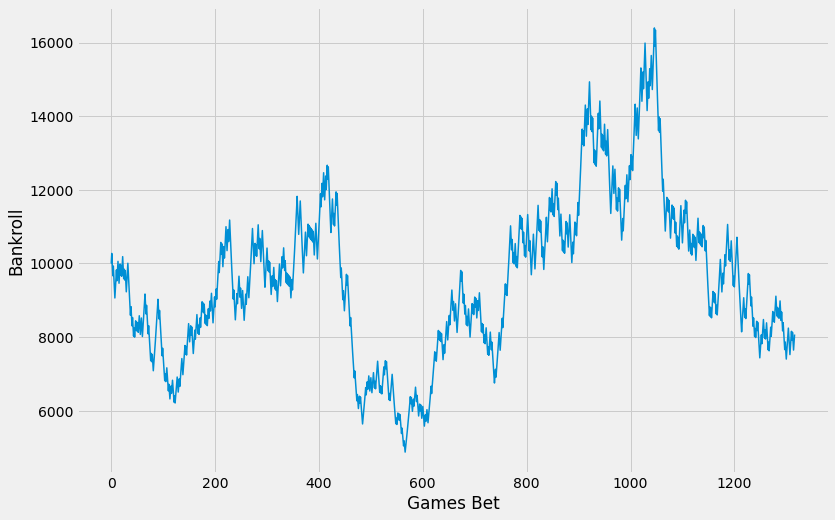

min balance: 4875.739831208471 
max balance: 16396.2152736751 
final balance: 7827.458065332492 
win percentage 52.769999999999996


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0         3  21700082  UTA vs. LAL         -6.5               56   
1         5  21700085  ATL vs. MIL          3.0               48   
2         9  21700089  SAC vs. WAS          4.0               32   
3        12  21700093  MIA vs. MIN          1.0               62   
4        13  21700094  NYK vs. DEN          2.0               65   
...     ...       ...          ...          ...              ...   
1312   3443  41900236  DEN vs. LAC          6.0               47   
1313   3457  41900402  LAL vs. MIA         -6.5               68   
1314   3458  41900403  MIA vs. LAL          6.0               58   
1315   3459  41900404  MIA vs. LAL          5.0               47   
1316   3461  41900406  MIA vs. LAL          3.5               36   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                  45             11.0           1   0.544405   0.455595   
1                  61            -13.0           0   0.531358   0.468642   
2                  63            -31.0           0   0.550637   0.449363   
3                  60              2.0           1   0.606184   0.393816   
4                  43             22.0           1   0.469550   0.530450   
...               ...              ...         ...        ...        ...   
1312               63            -16.0           0   0.536238   0.463762   
1313               54             14.0           1   0.468507   0.531493   
1314               54              4.0           1   0.544920   0.455080   
1315               49             -2.0           1   0.540666   0.459334   
1316               64            -28.0           0   0.530662   0.469338   

      prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0     0.544405          1          1          1  10000.000000  10272.727273   
1     0.531358          1          1          1  10272.727273   9964.545455   
2     0.550637          1          1          1   9964.545455   9665.609091   
3     0.606184          1          1          1   9665.609091   9929.216612   
4     0.469550          0          0          0   9929.216612   9631.340113   
...        ...        ...        ...        ...           ...           ...   
1312  0.536238          1          1          1   8127.070556   7883.258440   
1313  0.468507          0          0          0   7883.258440   7646.760687   
1314  0.544920          1          1          1   7646.760687   7855.308705   
1315  0.540666          1          1          1   7855.308705   8069.544397   
1316  0.530662          1          1          1   8069.544397   7827.458065   

        bet_size  bet_won  
0     300.000000        1  
1     308.181818        0  
2     298.936364        0  
3     289.968273        1  
4     297.876498        0  
...          ...      ...  
1312  243.812117        0  
1313  236.497753        0  
1314  229.402821        1  
1315  235.659261        1  
1316  242.086332        0  

[1317 rows x 18 columns]

In [327]:
lr_probs = best_lr.predict_proba(X_test1)
select_bets_lr, bet_thresholds_lr = find_optimal_threshold(full_df_ewm_9, lr_probs, test_idx1)
simulate_bets(select_bets_lr)

In [171]:
bet_thresholds_lr.loc[bet_thresholds_lr['strategy'] ==3]
# bet_thresholds_lr
create_betting_df(df_19, lr_probs, test_idx1, 3)
bet_thresholds_lr.loc[0, 'strategy']

2

In [336]:
ex = X_test1.loc[25622:25623]
ex2 = ex.copy(deep=True)
ex2.iloc[0, -1] = -20
ex2.iloc[1, -1] = +20

print("old_spread:", ex.iloc[0, -1], "new:", ex2.iloc[0, -1])
print("old_spread:", ex.iloc[1, -1], "new:", ex2.iloc[1, -1])

print("old_pred:", best_lr.predict_proba(ex))
# print(best_lr.predict(ex))


print("new_pred:", best_lr.predict_proba(ex2))
# print(best_lr.predict(ex2))

ex

old_spread: 7.5 new: -20.0
old_spread: -7.5 new: 20.0
old_pred: [[0.48837046 0.51162954]
 [0.51162952 0.48837048]]
new_pred: [[0.66079528 0.33920472]
 [0.33920471 0.66079529]]


FG2M_team  FG2A_team  FG3M_team  FG3A_team  FTM_team   FTA_team  \
25622  14.333333  27.866667   5.000000  13.933333       9.0  12.166667   
25623  12.800000  21.433333   8.333333  21.033333      10.8  13.200000   

       OREB_team  DREB_team   REB_team   AST_team  STL_team  BLK_team  \
25622   4.633333  17.133333  21.766667  10.533333  3.566667  2.433333   
25623   4.166667  18.066667  22.233333  12.300000  4.400000  2.333333   

       TOV_team   PF_team   PTS_team  PLUS_MINUS_team  E_OFF_RATING_team  \
25622  7.933333  9.866667  52.666667        -1.500000         104.703333   
25623  7.600000  9.600000  61.400000         7.333333         118.613333   

       E_DEF_RATING_team  E_NET_RATING_team  POSS_team  PIE_team  \
25622         107.476667              -2.77  49.700000    0.4781   
25623         104.536667              14.07  50.966667    0.5689   

       PTS_2PT_MR_team  PTS_FB_team  PTS_OFF_TOV_team  PTS_PAINT_team  \
25622              4.1     5.033333          7.366667       23.633333   
25623              2.3     6.066667          9.400000       22.333333   

       AST_2PM_team  UAST_2PM_team  AST_3PM_team  UAST_3PM_team  \
25622      6.833333       6.866667      3.400000       1.333333   
25623      6.100000       6.033333      5.433333       2.333333   

       team_covered_opp  RECORD_opp  FG2M_opp   FG2A_opp  FG3M_opp   FG3A_opp  \
25622          0.533333    0.600000      15.6  30.000000  4.866667  14.166667   
25623          0.400000    0.166667      14.9  28.733333  5.633333  14.833333   

        FTM_opp  FTA_opp  OREB_opp   DREB_opp    REB_opp  AST_opp   STL_opp  \
25622  8.366667     10.9  5.166667  16.666667  21.833333     12.8  4.433333   
25623  7.366667      9.8  3.600000  15.400000  19.000000     11.7  4.233333   

        BLK_opp  TOV_opp     PF_opp    PTS_opp  PLUS_MINUS_opp  \
25622  2.466667      6.8  10.633333  54.166667        1.500000   
25623  2.266667      7.4  10.566667  54.066667       -7.333333   

       E_OFF_RATING_opp  E_DEF_RATING_opp  E_NET_RATING_opp   POSS_opp  \
25622        107.476667        104.703333              2.77  49.800000   
25623        104.536667        118.613333            -14.07  50.966667   

       PIE_opp  PTS_2PT_MR_opp  PTS_FB_opp  PTS_OFF_TOV_opp  PTS_PAINT_opp  \
25622   0.5219        8.000000    6.966667         9.066667      22.166667   
25623   0.4311        5.333333    6.000000         9.166667      23.366667   

       AST_2PM_opp  UAST_2PM_opp  AST_3PM_opp  UAST_3PM_opp  WL_record  \
25622     8.400000      6.366667     3.900000      0.666667   0.400000   
25623     6.833333      7.500000     4.466667      0.833333   0.833333   

       ATS_record  OREB_PCT_team  OREB_PCT_opp  DREB_PCT_team  DREB_PCT_opp  \
25622    0.433333       0.217527      0.231689       0.768311      0.782473   
25623    0.533333       0.212947      0.166154       0.833846      0.787053   

       REB_PCT_team  REB_PCT_opp  TS_PCT_team  TS_PCT_opp  EFG_PCT_team  \
25622      0.499235     0.500765     0.592071    0.581628      0.522329   
25623      0.539208     0.460792     0.676649    0.591246      0.595761   

       EFG_PCT_opp  AST_RATIO_team  AST_RATIO_opp  TOV_PCT_team  TOV_PCT_opp  \
25622     0.518491       21.193830      25.702811     14.401549    12.194539   
25623     0.535960       24.133421      22.956181     13.601871    13.386719   

       rest  FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
25622   2.0        1.533333        6.433333       -3.333333            -7.1   
25623   2.0       -1.533333       -6.433333        3.333333             7.1   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
25622           -1.8      -1.033333        0.466667       -0.933333   
25623            1.8       1.033333       -0.466667        0.933333   

       REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
25622      -0.466667      -1.766667      -0.833333            0.1   
25623       0.466667       1.766667       0.833333 

In [332]:
X_train1

FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0            0.493099        6.667777        0.491195        0.768682   
1           -0.493099       -6.667777       -0.491195       -0.768682   
2           -0.808187       -1.969538        1.790576        2.985721   
3            0.808187        1.969538       -1.790576       -2.985721   
4           -2.067111       -5.203713       -0.508805        1.177535   
...               ...             ...             ...             ...   
17951       -0.229862        2.650886        1.331050        1.272874   
17952       -1.016110       -2.720709       -1.064840       -0.218299   
17953        1.016110        2.720709        1.064840        0.218299   
17954        2.012888        1.976567        1.251872        0.774639   
17955       -2.012888       -1.976567       -1.251872       -0.774639   

       FTM_team_diff  FTA_team_diff  OREB_team_diff  DREB_team_diff  \
0          -2.840076      -5.554498        1.394574        3.051880   
1           2.840076       5.554498       -1.394574       -3.051880   
2          -0.801047      -2.021894        3.075202       -1.027130   
3           0.801047       2.021894       -3.075202        1.027130   
4           0.165159      -0.722037       -3.250357       -1.209900   
...              ...            ...             ...             ...   
17951       0.770153       0.710266        1.895434        1.648096   
17952      -2.416122      -2.568213       -1.316347       -2.318477   
17953       2.416122       2.568213        1.316347        2.318477   
17954       2.132898       1.654571        1.253078        3.854782   
17955      -2.132898      -1.654571       -1.253078       -3.854782   

       REB_team_diff  AST_team_diff  STL_team_diff  BLK_team_diff  \
0           4.446454       0.960495       0.481199       0.137078   
1          -4.446454      -0.960495      -0.481199      -0.137078   
2           2.048072       0.474060       1.190861      -0.210852   
3          -2.048072      -0.474060      -1.190861       0.210852   
4          -4.460257      -2.774869       0.613041       0.837696   
...              ...            ...            ...            ...   
17951       3.543530       2.082297      -0.039046       0.103741   
17952      -3.634824      -2.465837      -0.968763      -0.282993   
17953       3.634824       2.465837       0.968763       0.282993   
17954       5.107859       3.572670       0.975011       0.426394   
17955      -5.107859      -3.572670      -0.975011      -0.426394   

       TOV_team_diff  PF_team_diff  PTS_team_diff  PLUS_MINUS_team_diff  \
0          -0.689196      0.360781      -0.380295              0.259876   
1           0.689196     -0.360781       0.380295             -0.259876   
2          -1.740124      0.912899       2.954307             10.972394   
3           1.740124     -0.912899      -2.954307            -10.972394   
4          -0.825797      0.136126      -5.495478             -7.568301   
...              ...           ...            ...                   ...   
17951       0.251645     -0.551474       4.303579             -1.377043   
17952       0.798684      0.841179      -7.642863             -7.298366   
17953      -0.798684     -0.841179       7.642863              7.298366   
17954      -0.638947     -0.872943       9.914291             13.438693   
17955       0.638947      0.872943      -9.914291            -13.438693   

       E_OFF_RATING_team_diff  E_DEF_RATING_team_diff  E_NET_RATING_team_diff  \
0                   -6.396621               -7.489767                1.116944   
1                    6.396621                7.489767               -1.116944   
2                   16.541218               -4.085483               20.575488   
3                  -16.541218                4.085483              -20.575488   
4                   -7.789862                9.935554              -17.738505   
...                       ...                     ...        

<AxesSubplot:ylabel='feature'>

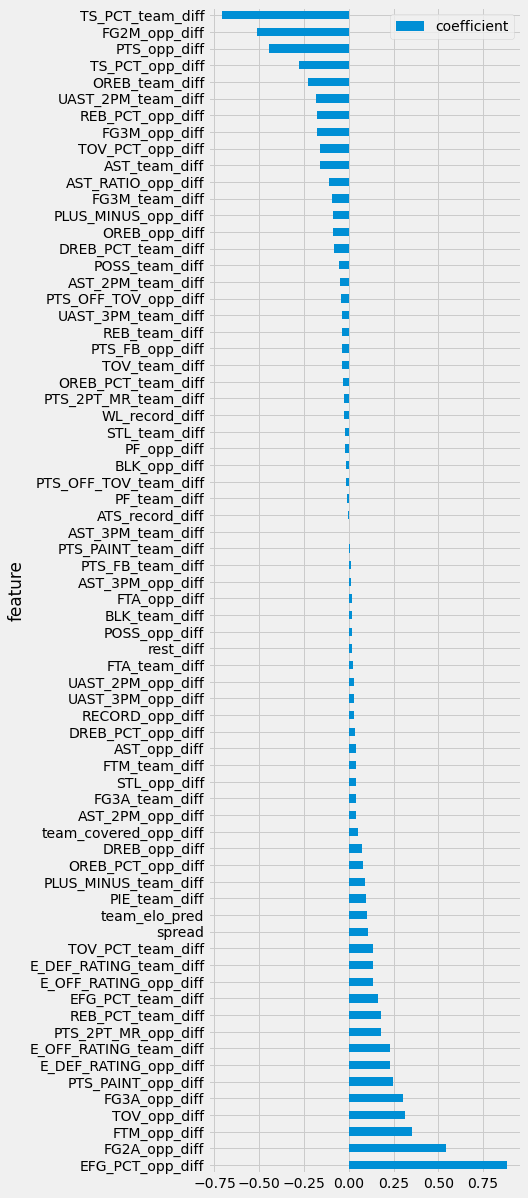

In [337]:
features = X_train1.columns
logistic_coefs = best_lr.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({'feature':features,
                       'coefficient':logistic_coefs})


coef_df.loc[coef_df['coefficient']!=0].sort_values('coefficient', ascending=False).plot.barh(x = 'feature', 
                                                                                             figsize=(5,20))


best_log_reg: Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.07943282347242814, max_iter=1000,
                                    penalty='l1', solver='saga'))])
train_score: 0.5382994497990401
test_score: 0.5060068649885584
Train Betting Overall Accuracy: 0.536848792884371
Test Betting Overall Accuracy: 0.503810082063306


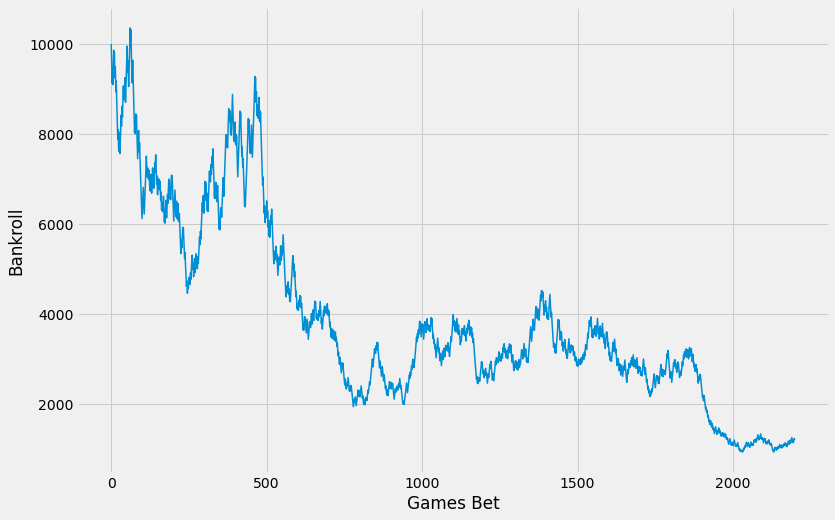

min balance: 926.5139137132533 
max balance: 10357.109890144402 
final balance: 1226.8878401865675 
win percentage 51.43


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21700077  NOP vs. CLE          2.5  2.150000  1.740741   
1         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
2         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
3         3  21700082  UTA vs. LAL        -11.0  1.181818  5.160000   
4         4  21700083  POR vs. PHX        -12.0  1.133333  6.000000   
...     ...       ...          ...          ...       ...       ...   
2194   3488  41900315  LAL vs. DEN         -5.5  1.487805  2.360000   
2195   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
2196   3490  41900401  LAL vs. MIA         -4.5  1.512821  2.600000   
2197   3494  41900405  LAL vs. MIA         -7.5  1.289855  3.070000   
2198   3495  41900406  MIA vs. LAL          5.5  3.100000  1.400000   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 123              101               22           1   
1                 103               89               14           1   
2                 110              112               -2           0   
3                  96               81               15           1   
4                 114              107                7           0   
...               ...              ...              ...         ...   
2194              117              107               10           1   
2195              125              113               12           1   
2196              116               98               18           1   
2197              108              111               -3           0   
2198               93              106              -13           0   

      prob_home  prob_away  prob_avg  bet_home1  bet_home2  bet_home3  \
0      0.426620   0.549739  0.438441          0          0          0   
1      0.409733   0.583148  0.413293          0          0          0   
2      0.554551   0.451653  0.551449          1          1          1   
3      0.569132   0.406562  0.581285          1          1          1   
4      0.525320   0.454034  0.535643          1          1          1   
...         ...        ...       ...        ...        ...        ...   
2194   0.553126   0.427171  0.562978          1          1          1   
2195   0.555413   0.438855  0.558279          1          1          1   
2196   0.523780   0.461295  0.531242          1          1          1   
2197   0.526183   0.459269  0.533457          1          1          1   
2198   0.448644   0.536944  0.455850          0          0          0   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9126.730000  282.270000        0  
3      9126.730000  9375.640818  273.801900        1  
4      9375.640818  9094.371594  281.269225        0  
...            ...          ...         ...      ...  
2194   1135.769219  1166.744743   34.073077        1  
2195   1166.744743  1198.565055   35.002342        1  
2196   1198.565055  1231.253192   35.956952        1  
2197   1231.253192  1194.315597   36.937596        0  
2198   1194.315597  1226.887840   35.829468        1  

[2199 rows x 20 columns]

In [135]:

best_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.07943282347242814, max_iter=1000,
                                    penalty='l1', solver='saga'))])


lr_pipeline_cover = Pipeline([('scaler', StandardScaler()),
                    ('logreg', LogisticRegression(solver='saga', penalty='l1', max_iter=1000))])

param_grid={'logreg__C':np.logspace(-2, -1, 11)}

lr_gs = GridSearchCV(lr_pipeline_cover, param_grid=param_grid, cv=tscv, n_jobs=-1)
lr_gs.fit(X_train1, cover_train1)

print("best_log_reg:", lr_gs.best_estimator_)
best_lr = lr_gs.best_estimator_


best_lr.fit(X_train2, cover_train2)


preds_lr_train2 = best_lr.predict_proba(X_train2)
preds_lr_test2 = best_lr.predict_proba(X_test2)

print("train_score:", best_lr.score(X_train2, cover_train2))
print("test_score:", best_lr.score(X_test2, cover_test2))

# print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)

bets_train = create_betting_df(df_19, preds_lr_train2, train_idx2, 2)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, preds_lr_test2, test_idx2, 2)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


select_bets = bets_test.loc[~bets_test['prob_away'].between(1-0.524, 0.524)] 
simulate_bets(select_bets)

In [134]:
bets_test

GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  team_score_home  \
0     21700077  NOP vs. CLE          2.5  2.150000  1.740741              123   
1     21700080  MEM vs. HOU         -2.0  1.800000  2.050000              103   
2     21700081  DAL vs. PHI          1.0  2.000000  1.833333              110   
3     21700082  UTA vs. LAL        -11.0  1.181818  5.160000               96   
4     21700083  POR vs. PHX        -12.0  1.133333  6.000000              114   
...        ...          ...          ...       ...       ...              ...   
3491  41900402  LAL vs. MIA        -11.0  1.157480  4.930000              124   
3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526              115   
3493  41900404  MIA vs. LAL          7.5  3.520000  1.273973               96   
3494  41900405  LAL vs. MIA         -7.5  1.289855  3.070000              108   
3495  41900406  MIA vs. LAL          5.5  3.100000  1.400000               93   

      team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                 101               22           1   0.426620   0.549739   
1                  89               14           1   0.409733   0.583148   
2                 112               -2           0   0.554550   0.451653   
3                  81               15           1   0.569132   0.406563   
4                 107                7           0   0.525320   0.454034   
...               ...              ...         ...        ...        ...   
3491              114               10           0   0.504006   0.482871   
3492              104               11           1   0.485766   0.501647   
3493              102               -6           1   0.466341   0.518406   
3494              111               -3           0   0.526183   0.459269   
3495              106              -13           0   0.448644   0.536944   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.438440          0          0          0     10000.0         NaN   
1     0.413293          0          0          0         NaN         NaN   
2     0.551449          1          1          1         NaN         NaN   
3     0.581284          1          1          1         NaN         NaN   
4     0.535643          1          1          1         NaN         NaN   
...        ...        ...        ...        ...         ...         ...   
3491  0.510567          1          1          1         NaN         NaN   
3492  0.492059          0          0          0         NaN         NaN   
3493  0.473967          0          0          0         NaN         NaN   
3494  0.533457          1          1          1         NaN         NaN   
3495  0.455850          0          0          0         NaN         NaN   

      bet_size  bet_won  
0          NaN        0  
1          NaN        0  
2          NaN        0  
3          NaN        1  
4          NaN        0  
...        ...      ...  
3491       NaN        0  
3492       NaN        0  
3493       NaN        0  
3494       NaN        0  
3495       NaN        1  

[3412 rows x 19 columns]

#### Linear Regression RFE

In [ ]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

lr = LinearRegression()

rfe_lr = RFECV(lr, cv=tscv, scoring='neg_mean_absolute_error')
rfe_lr.fit(X_train1_sc, point_diff_train1)

In [ ]:
lr_pipeline_diff_reduced = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff_reduced.fit(X_train1.loc[:, rfe_lr.support_], point_diff_train1)


diff_preds_lr_reduced = lr_pipeline_diff_reduced.predict(X_test1.loc[:, rfe_lr.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

select_bets_lr, bet_thresholds_lr = find_optimal_confidence_thresholds(diff_preds_lr_reduced, score_preds_lr, test_idx1)
simulate_bets(select_bets_lr)

In [ ]:
lr_pipeline_diff_reduced = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff_reduced.fit(X_train2.loc[:, rfe_lr.support_], point_diff_train2)


diff_preds_lr2_reduced = lr_pipeline_diff_reduced.predict(X_test2.loc[:, rfe_lr.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_lr2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_lr2_reduced, score_preds_lr2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) >2.1]    
simulate_bets(select_bets)

In [ ]:
lr_feature_names = X_train1.loc[:, rfe_lr.support_].columns
lr_diff_coefs = lr_pipeline_diff_reduced.named_steps['linreg'].coef_

coef_df = pd.DataFrame({'feature':lr_feature_names,
                       'lr_diff_coef':lr_diff_coefs})
coef_df.sort_values('lr_diff_coef', ascending=False)

### SGD

In [658]:
tscv = TimeSeriesSplit()

In [379]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(loss='log',
                               max_iter=10000, penalty='l1'))])

sgd_pipe.fit(X_train1, cover_train1)
preds_train_sgd = sgd_pipe.predict(X_train1)   
preds_test_sgd = sgd_pipe.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_sgd)
test_acc = accuracy_score(cover_test1, preds_test_sgd)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.5191146881287726 test_acc: 0.5157423454650492


In [351]:
sgd_pipe = Pipeline([('scaler',StandardScaler()),
                          ('sgd', SGDClassifier(loss='log', max_iter=10000))])

for df in [full_df_ewm_9, full_df_ewm_19, full_df_ewm_29,
          full_df_avg_5, full_df_avg_10, full_df_avg_all]:
    X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(df, cutoff_17)
    sgd_pipe.fit(X_train1, cover_train1)
    preds_train_sgd = sgd_pipe.predict(X_train1)   
    preds_test_sgd = sgd_pipe.predict(X_test1)
    
    train_acc = accuracy_score(cover_train1, preds_train_sgd)
    test_acc = accuracy_score(cover_test1, preds_test_sgd)

    print("train_acc:", train_acc,
         "test_acc:", test_acc)

train_acc: 0.5077665995975855 test_acc: 0.5025996533795494
train_acc: 0.5017706237424547 test_acc: 0.49552281917966495
train_acc: 0.514728370221328 test_acc: 0.5034662045060658
train_acc: 0.5096981891348088 test_acc: 0.4927787406123628
train_acc: 0.5070020120724346 test_acc: 0.49855574812247255
train_acc: 0.5138028169014085 test_acc: 0.5041883304448296


In [343]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.3min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


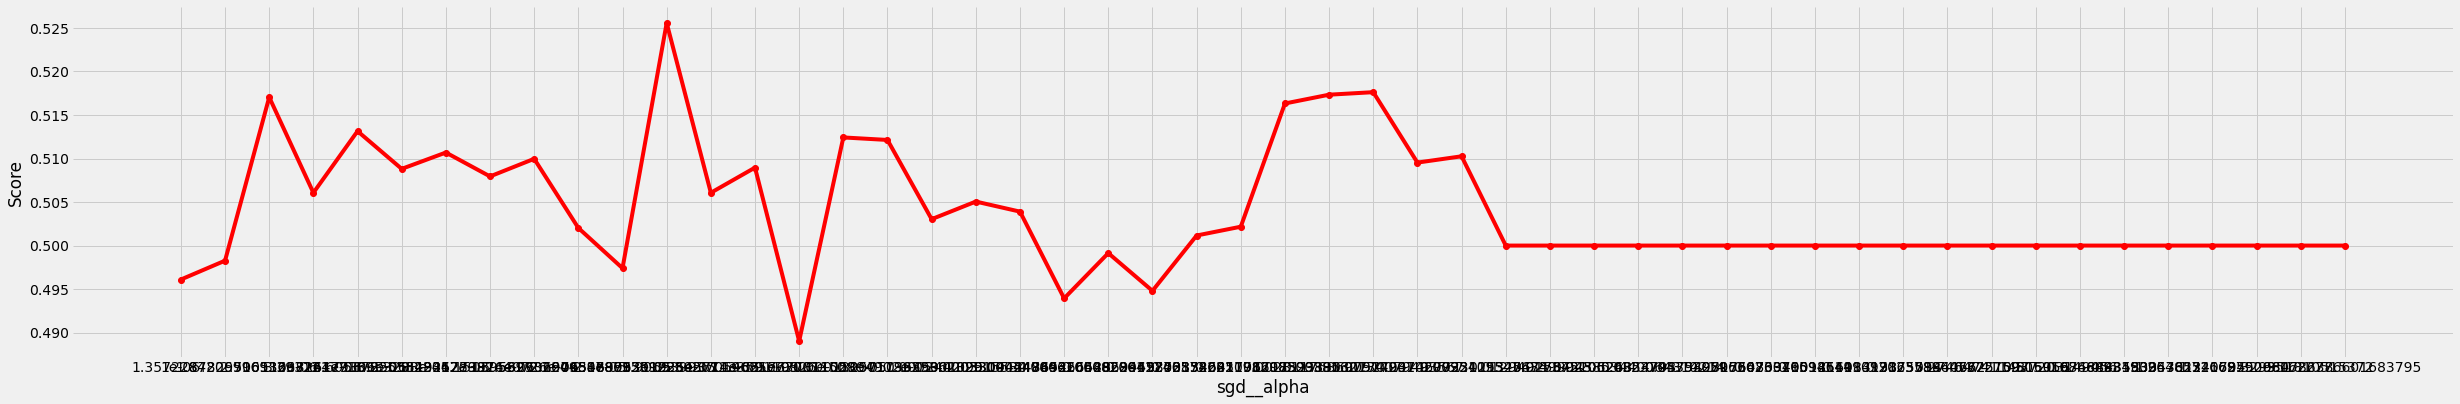

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=2.8786155923545714e-05, loss='log',
                               penalty='l1', random_state=23))]) 0.5255632582322357


In [348]:
# X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


sgd_pipe = Pipeline([('scaler',StandardScaler()),
                          ('sgd', SGDClassifier(max_iter=1000, loss='log', penalty='l1',
                                                random_state=23))])
grid = {
        'sgd__alpha':np.logspace(-6, 0.5, 50)}

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(sgd_pipe, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)



In [359]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=2.8786155923545714e-05, loss='log',
                               penalty='l1', random_state=23))])


sgd_pipe.fit(X_train1, cover_train1)
preds_train_sgd = sgd_pipe.predict(X_train1)   
preds_test_sgd = sgd_pipe.predict(X_test1)
probs_test_sgd = sgd_pipe.predict_proba(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_sgd)
test_acc = accuracy_score(cover_test1, preds_test_sgd)

print("train_acc:", train_acc,
     "test_acc:", test_acc)


train_acc: 0.5222535211267606 test_acc: 0.5255632582322357


test_season  2017-18
0.5132780082987551


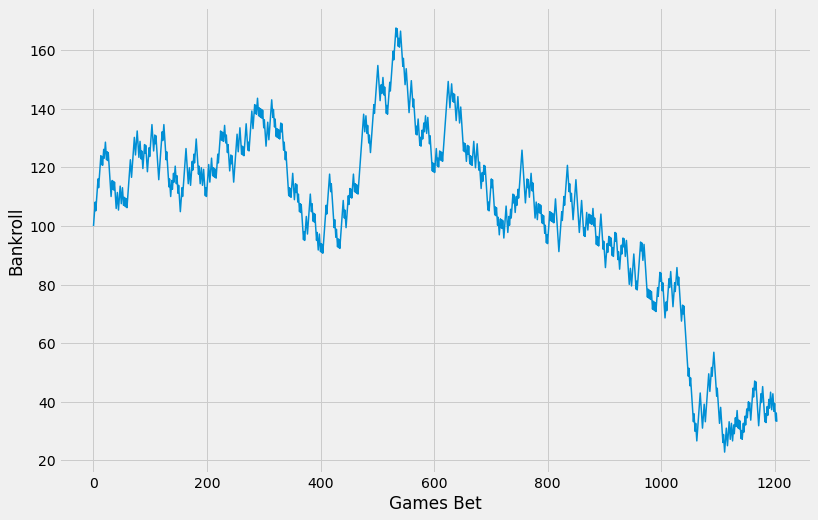

min balance: 22.818181818183284 
max balance: 167.63636363636417 
final balance: 35.90909090909234 
win percentage 51.449999999999996
test_season  2018-19
0.5119834710743801


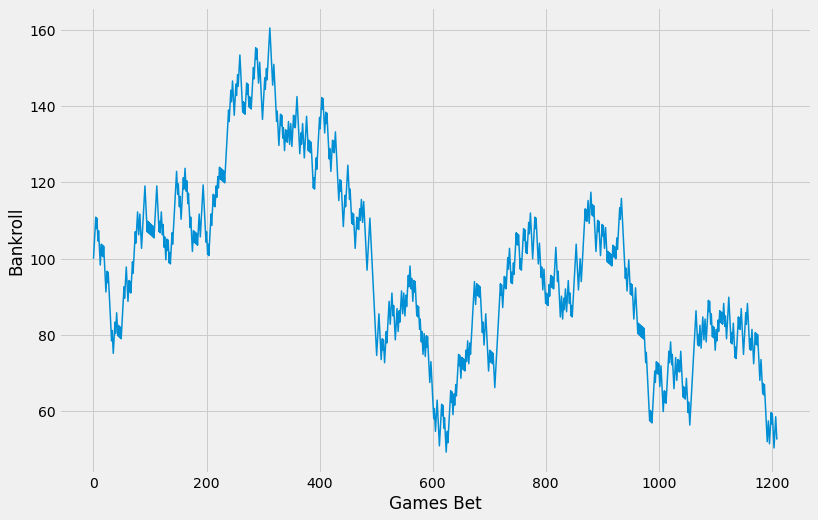

min balance: 49.27272727272792 
max balance: 160.54545454545502 
final balance: 49.545454545456984 
win percentage 51.65
test_season  2019-20
0.5023877745940784


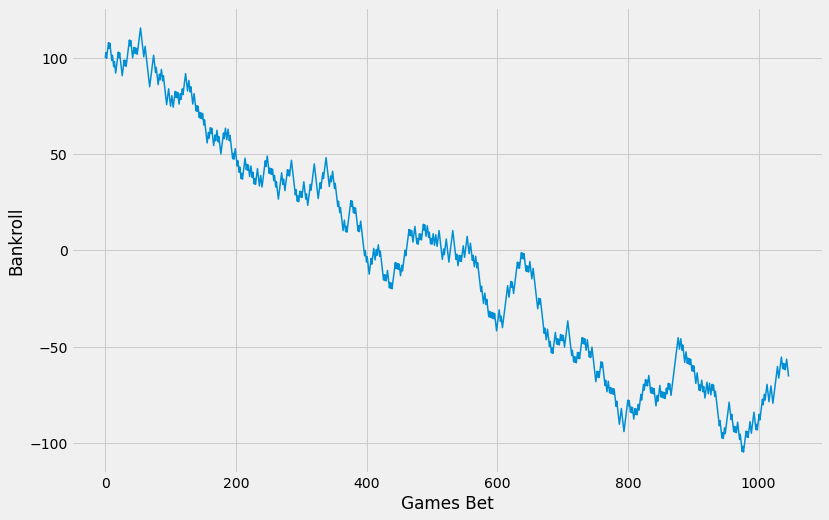

min balance: -104.81818181818096 
max balance: 115.54545454545475 
final balance: -62.818181818180754 
win percentage 49.669999999999995


season  accuracy
0  2017-18  0.514523
1  2018-19  0.516529
2  2019-20  0.496657

In [368]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=2.8786155923545714e-05, loss='log',
                               penalty='l1', random_state=23))])

accuracy_per_season(full_df_combined, sgd_pipe, cutoffs)

In [324]:
print(cutoff_19)
full_df_combined.loc[cutoff_19, 'SEASON_YEAR_team']

33659


'2018-19'

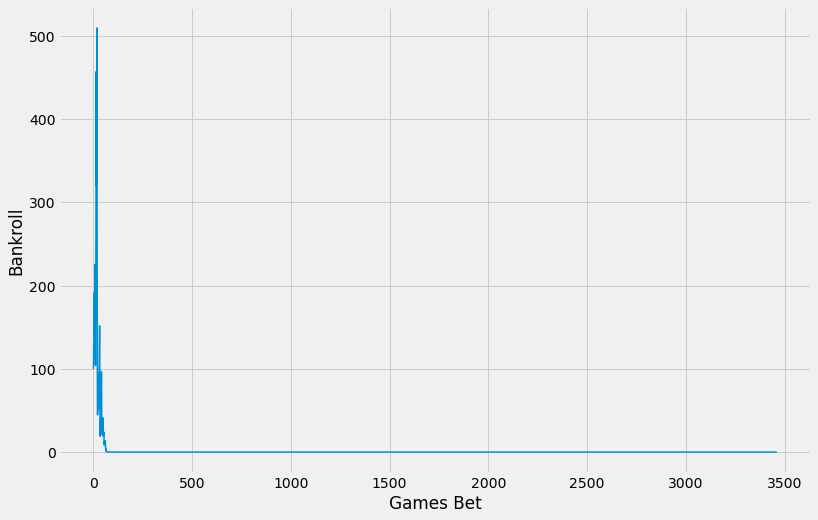

min balance: 2.5757938498748153e-90 
max balance: 509.76022157465326 
final balance: 2.9884469394666126e-90 
win percentage 52.370000000000005


index   GAME_ID MATCHUP_home spread_home team_score_home  \
0         0  21700077  NOP vs. CLE           1              65   
1         1  21700080  MEM vs. HOU          -1              54   
2         2  21700081  DAL vs. PHI         0.5              56   
3         3  21700082  UTA vs. LAL        -6.5              56   
4         4  21700083  POR vs. PHX        -6.5              61   
...     ...       ...          ...         ...             ...   
3457   3457  41900402  LAL vs. MIA        -6.5              68   
3458   3458  41900403  MIA vs. LAL           6              58   
3459   3459  41900404  MIA vs. LAL           5              47   
3460   3460  41900405  LAL vs. MIA          -4              56   
3461   3461  41900406  MIA vs. LAL         3.5              36   

     team_score_away point_diff_home  cover_home  prob_home  prob_away  \
0                 52              13           1   0.649904   0.283214   
1                 49               5           1   0.491763   0.503010   
2                 57              -1           0   0.387297   0.579151   
3                 45              11           1   0.657499   0.304285   
4                 57               4           0   0.626037   0.323876   
...              ...             ...         ...        ...        ...   
3457              54              14           1   0.542707   0.467036   
3458              54               4           1   0.463021   0.560038   
3459              49              -2           1   0.504706   0.516647   
3460              60              -4           0   0.626587   0.396222   
3461              64             -28           0   0.489506   0.523160   

      prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0     0.683345          1          1          1  1.000000e+02  1.304567e+02   
1     0.494376          0          0          0  1.304567e+02  1.304567e+02   
2     0.404073          0          0          0  1.304567e+02  1.484179e+02   
3     0.676607          1          1          1  1.484179e+02  1.917122e+02   
4     0.651081          1          1          1  1.917122e+02  1.404733e+02   
...        ...        ...        ...        ...           ...           ...   
3457  0.537835          1          1          1  3.798631e-90  3.900344e-90   
3458  0.451491          0          0          0  3.900344e-90  3.698038e-90   
3459  0.494029          1          0          0  3.698038e-90  3.698038e-90   
3460  0.615182          1          1          1  3.698038e-90  2.988447e-90   
3461  0.483173          0          0          0  2.988447e-90  2.988447e-90   

          bet_size  bet_won  
0     3.350241e+01        1  
1     0.000000e+00        0  
2     1.975730e+01        1  
3     4.762366e+01        1  
4     5.123884e+01        0  
...            ...      ...  
3457  1.118845e-91        1  
3458  2.023061e-91        0  
3459  0.000000e+00        0  
3460  7.095911e-91        0  
3461  0.000000e+00        1  

[3462 rows x 18 columns]

In [365]:
sgd_bets = create_betting_df(full_df_combined, probs_test_sgd, test_idx1, 3)
# simulate_bets_1(sgd_bets)
simulate_bets_kelly(sgd_bets)
# sgd_bets['bet_won'].mean()
# # sgd_bets

In [357]:
sgd_bets

GAME_ID MATCHUP_home spread_home team_score_home team_score_away  \
0     21700077  NOP vs. CLE           1              65              52   
1     21700080  MEM vs. HOU          -1              54              49   
2     21700081  DAL vs. PHI         0.5              56              57   
3     21700082  UTA vs. LAL        -6.5              56              45   
4     21700083  POR vs. PHX        -6.5              61              57   
...        ...          ...         ...             ...             ...   
3457  41900402  LAL vs. MIA        -6.5              68              54   
3458  41900403  MIA vs. LAL           6              58              54   
3459  41900404  MIA vs. LAL           5              47              49   
3460  41900405  LAL vs. MIA          -4              56              60   
3461  41900406  MIA vs. LAL         3.5              36              64   

     point_diff_home  cover_home  pred_home  bet_won  bankroll_i  bankroll_n  \
0                 13           1          1        1     10000.0         NaN   
1                  5           1          0        0         NaN         NaN   
2                 -1           0          0        1         NaN         NaN   
3                 11           1          1        1         NaN         NaN   
4                  4           0          1        0         NaN         NaN   
...              ...         ...        ...      ...         ...         ...   
3457              14           1          1        1         NaN         NaN   
3458               4           1          0        0         NaN         NaN   
3459              -2           1          1        1         NaN         NaN   
3460              -4           0          1        0         NaN         NaN   
3461             -28           0          0        1         NaN         NaN   

      bet_size  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
3457       NaN  
3458       NaN  
3459       NaN  
3460       NaN  
3461       NaN  

[3462 rows x 12 columns]

### Linear SVM with SGD

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.4s finished


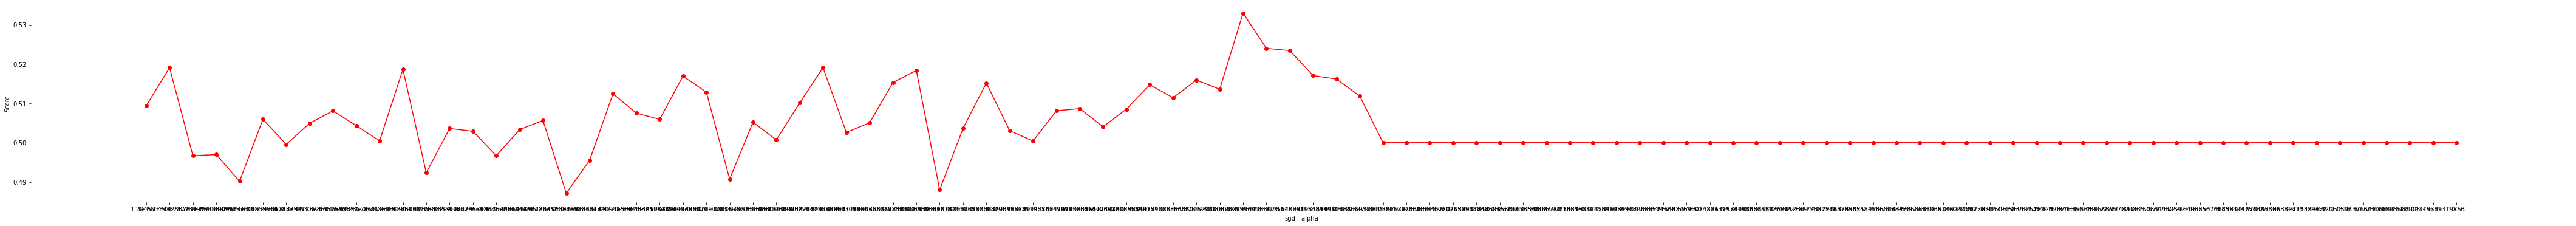

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                               random_state=23))]) 0.5329289428076257


In [73]:
sgd_pipe = Pipeline([('scaler',StandardScaler()),
                          ('sgd', SGDClassifier(max_iter=1000, loss='hinge', penalty='l1',
                                                random_state=23))])
grid = {
        'sgd__alpha':np.logspace(-6, 2, 100)}

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(sgd_pipe, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)
# sgd_cv.fit(X_train1, cover_train1)

# best_sgd = sgd_cv.best_estimator_
# print("best_sgd:", best_sgd)

# sgd_preds_train = best_sgd.predict(X_train1)
# sgd_preds_test = best_sgd.predict(X_test1)

# print(accuracy_score(cover_train1, sgd_preds_train))
# print(accuracy_score(cover_test1, sgd_preds_test))

# print(confusion_matrix(cover_test1, sgd_preds_test))

# select_bets_sgd, bet_thresholds_sgd = find_optimal_threshold(df_19, sgd_probs, test_idx1)
# simulate_bets(select_bets_sgd)


In [126]:
best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                               random_state=23))])

best_sgd_svm.fit(X_train1, cover_train1)

sgd_svm_preds_train = best_sgd_svm.predict(X_train1)

sgd_svm_preds_test = best_sgd.predict(X_test1)
print(accuracy_score(cover_train1, sgd_svm_preds_train))
print(accuracy_score(cover_test1, sgd_svm_preds_test))

print(confusion_matrix(cover_test1, sgd_svm_preds_test))


0.5265593561368209
0.5278740612362796
[[1809 1653]
 [1616 1846]]


In [153]:
results = (cover_test1 == sgd_svm_preds_test).astype(int)
results.reset_index(inplace=True, drop=True)

results.loc[results]
# results
# cover_test1
# full_df_combined

0       1
1       1
2       1
3       1
4       0
       ..
6919    1
6920    0
6921    0
6922    1
6923    1
Length: 6924, dtype: int32

In [138]:
sgd_svm_bets = create_betting_df_with_preds(full_df_combined, sgd_svm_preds_test, test_idx1)
# simulate_bets(sgd_svm_bets)
sgd_svm_bets['bet_won'].mean()
sgd_svm_bets['model_results'] = results

sgd_svm_bets[['bet_won', 'model_results']]

bet_won  model_results
0           1            NaN
1           1            NaN
2           0            NaN
3           1            NaN
4           0            NaN
...       ...            ...
3457        0            NaN
3458        1            NaN
3459        1            NaN
3460        0            NaN
3461        1            NaN

[3462 rows x 2 columns]

In [39]:
best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(
                               epsilon=2.782559402207126,
                               l1_ratio=0.6735612574911102, max_iter=10000))])
params = {
    'sgd__loss': ['log'],
    'sgd__alpha':np.logspace(-5, 2, 20)
}

sgd_cv = GridSearchCV(best_sgd, param_grid=params, scoring='accuracy', cv=tscv, n_jobs=-1)

sgd_cv.fit(X_train1, cover_train1)

print(sgd_cv.best_estimator_)

best_sgd = sgd_cv.best_estimator_


sgd_preds = best_sgd.predict(X_test1)
sgd_probs = best_sgd.predict_proba(X_test1)

print(accuracy_score(cover_test1, sgd_preds))



Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.11288378916846883,
                               epsilon=2.782559402207126,
                               l1_ratio=0.6735612574911102, loss='log',
                               max_iter=10000))])
0.5229226361031518


In [45]:
sgd_probs = best_sgd.predict_proba(X_test1)
sgd_probs
# bet_df_sgd = create_betting_df(df_ewm_9_diffs, sgd_preds, test_idx1)
# simulate_bets(bet_df_sgd)

array([[0.48692677, 0.51307323],
       [0.51316886, 0.48683114],
       [0.51790843, 0.48209157],
       ...,
       [0.50300115, 0.49699885],
       [0.51426938, 0.48573062],
       [0.48545597, 0.51454403]])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 1
best threshold: 0.521
num_games_bet: 798
win percetange at threshold: 0.531328320802005
best_threshold: 0.521
season  2015-16


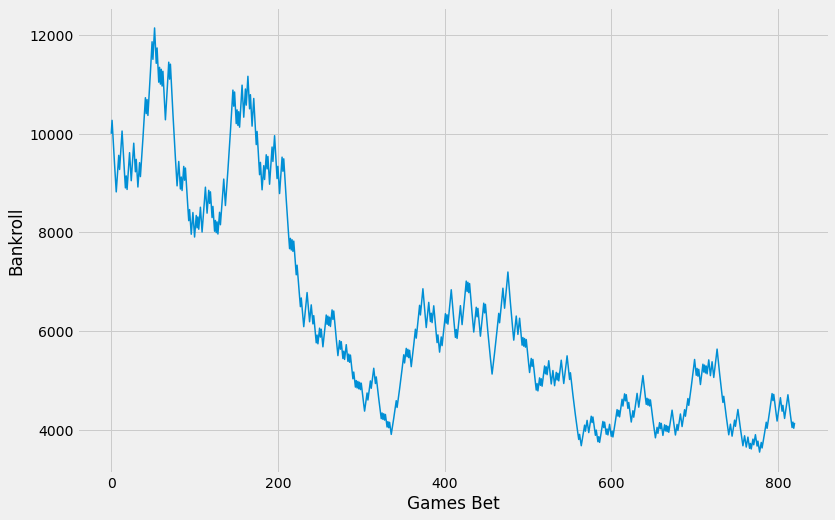

min balance: 3543.633204272429 
max balance: 12146.885218858903 
final balance: 4250.08838163438 
win percentage 51.28
2015-16


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.532
num_games_bet: 594
win percetange at threshold: 0.5420875420875421
best_threshold: 0.532
season  2016-17


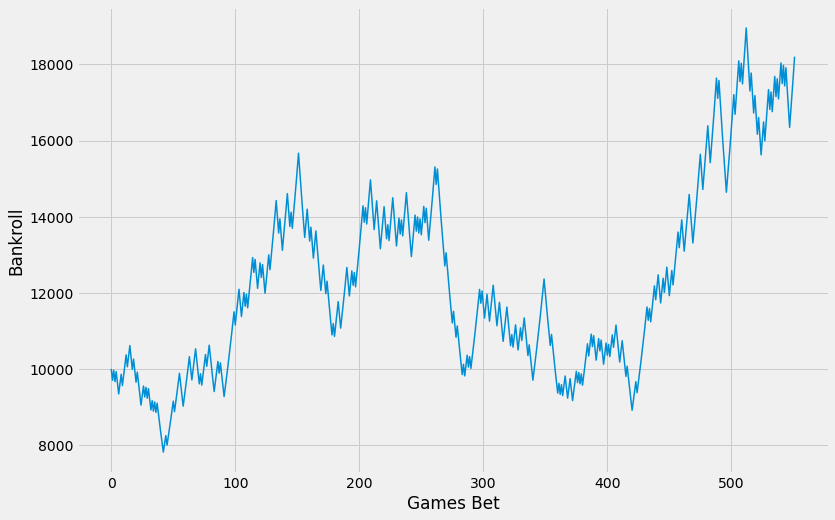

min balance: 7813.853639577773 
max balance: 18958.184828197223 
final balance: 17658.207051140038 
win percentage 54.89000000000001
2016-17


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.544
num_games_bet: 426
win percetange at threshold: 0.5633802816901409
best_threshold: 0.544
season  2017-18


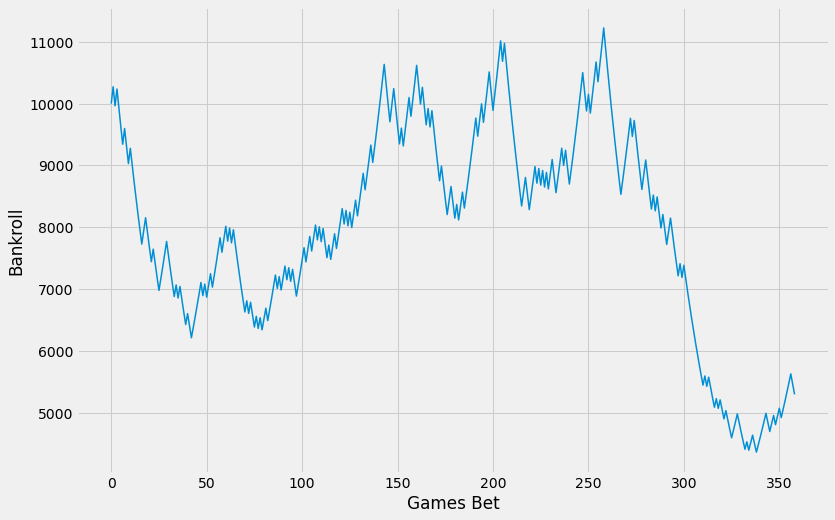

min balance: 4361.743793012198 
max balance: 11224.235879137925 
final balance: 5439.724840605743 
win percentage 50.13999999999999
2017-18


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


no best threshold
The except block executed
season  2018-19


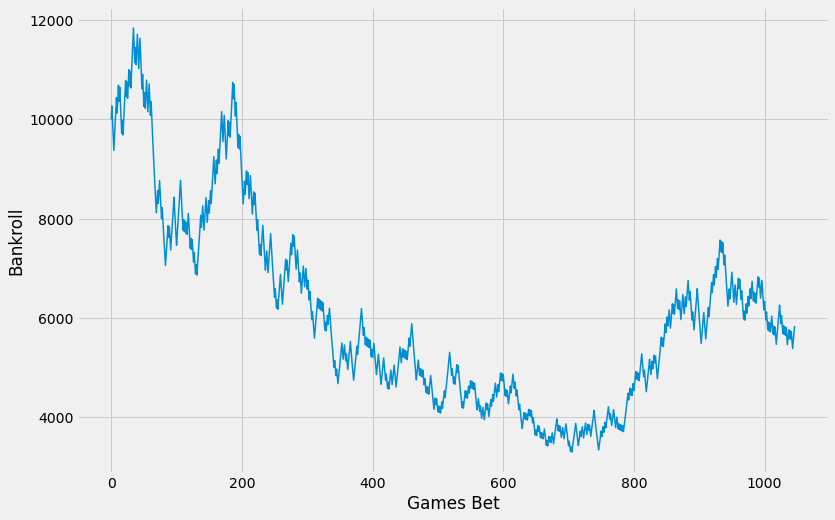

min balance: 3300.283123918946 
max balance: 11842.229416123691 
final balance: 5663.213217674547 
win percentage 52.15
2018-19


season  accuracy
0  2015-16  0.512789
1  2016-17  0.548913
2  2017-18  0.501393
3  2018-19  0.521490

In [132]:
accuracy_per_season(full_df_diffs, 
                    Pipeline(steps=[('scaler', StandardScaler()),
            ('sgd',
             SGDClassifier(alpha=0.11288378916846883,
                           epsilon=2.782559402207126,
                           l1_ratio=0.6735612574911102, loss='log',
                           max_iter=10000))]),
                    cutoffs)

In [ ]:
full_df_combined

best_sgd: Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.018329807108324356,
                               epsilon=0.6951927961775606, loss='log',
                               max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.535
num_games_bet: 1931
win percetange at threshold: 0.525116519937856


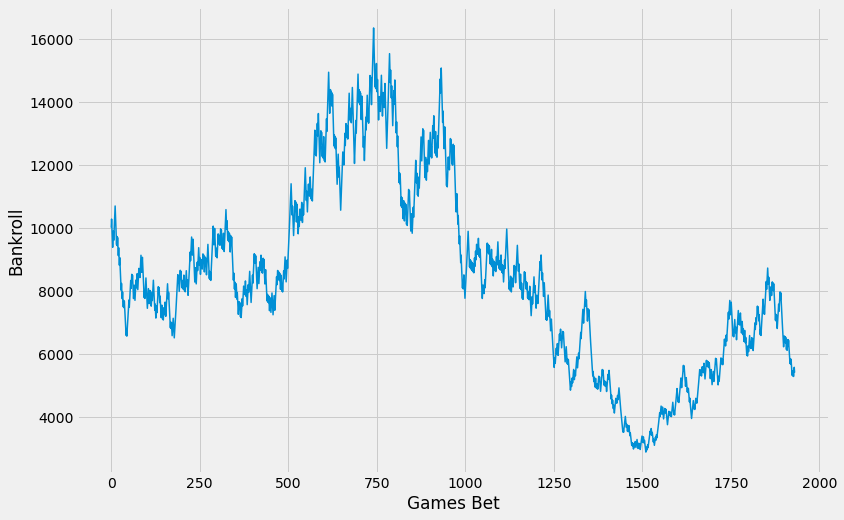

min balance: 2872.4832704852474 
max balance: 16341.531784301758 
final balance: 5236.477766331764 
win percentage 52.51


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21400073  PHI vs. CHI         10.0  5.500000  1.166667   
1         2  21400078  OKC vs. MEM          7.0  3.600000  1.307692   
2         3  21400079  PHX vs. SAC         -5.0  1.487805  2.750000   
3         4  21400080  UTA vs. DAL          3.0  2.300000  1.666667   
4         5  21400082  LAC vs. POR         -4.5  1.526316  2.650000   
...     ...       ...          ...          ...       ...       ...   
1926   3666  41600305  BOS vs. CLE         10.0  4.900000  1.172414   
1927   3668  41600402  GSW vs. CLE         -9.0  1.250000  4.300000   
1928   3669  41600403  CLE vs. GSW          3.0  2.200000  1.666667   
1929   3670  41600404  CLE vs. GSW          5.0  2.650000  1.526316   
1930   3671  41600405  GSW vs. CLE         -9.5  1.250000  3.600000   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 115              118               -3           1   
1                  89               91               -2           1   
2                 112              114               -2           0   
3                  82              105              -23           0   
4                 106              102                4           0   
...               ...              ...              ...         ...   
1926              102              135              -33           0   
1927              132              113               19           1   
1928              113              118               -5           0   
1929              137              116               21           1   
1930              129              120                9           0   

      prob_home  prob_away  prob_avg  bet_home1  bet_home2  bet_home3  \
0      0.545720   0.469778  0.537971          1          1          1   
1      0.357353   0.657799  0.349777          0          0          0   
2      0.597032   0.324918  0.636057          1          1          1   
3      0.634946   0.383194  0.625876          1          1          1   
4      0.385207   0.573659  0.405774          0          0          0   
...         ...        ...       ...        ...        ...        ...   
1926   0.584923   0.459304  0.562810          1          1          1   
1927   0.543721   0.439739  0.551991          1          1          1   
1928   0.434251   0.564084  0.435084          0          0          0   
1929   0.450197   0.560030  0.445084          0          0          0   
1930   0.576223   0.443243  0.566490          1          1          1   

        bankroll_i    bankroll_n    bet_size  bet_won  
0     10000.000000  10272.727273  300.000000        1  
1     10272.727273   9964.545455  308.181818        0  
2      9964.545455   9665.609091  298.936364        0  
3      9665.609091   9375.640818  289.968273        0  
4      9375.640818   9631.340113  281.269225        1  
...            ...           ...         ...      ...  
1926   5436.915014   5273.807563  163.107450        0  
1927   5273.807563   5417.638679  158.214227        1  
1928   5417.638679   5565.392461  162.529160        1  
1929   5565.392461   5398.430687  166.961774        0  
1930   5398.430687   5236.477766  161.952921        0  

[1931 rows x 20 columns]

In [213]:
sgd_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd', SGDClassifier(alpha=0.018329807108324356,
                                      epsilon=0.6951927961775606,
                               max_iter=10000))])

params = {
    'sgd__loss': ['log', 'modified_huber',
    'squared_hinge', 'perceptron']
}

sgd_cv = GridSearchCV(sgd_pipe, param_grid=params, scoring='accuracy', cv=tscv, n_jobs=-1)


sgd_cv.fit(X_train1, cover_train1)

best_sgd = sgd_cv.best_estimator_
print("best_sgd:", best_sgd)

sgd_probs = best_sgd.predict_proba(X_test1)

select_bets_sgd, bet_thresholds_sgd = find_optimal_threshold(df_19, sgd_probs, test_idx1)
simulate_bets(select_bets_sgd)


In [214]:
bet_thresholds_sgd

index  strategy  confidence_range  num_games_bet  win_percentage  \
0      533         2             0.535           2122        0.529218   
1      534         2             0.536           2083        0.529045   
2      532         2             0.534           2153        0.527636   
3     1041         3             0.544           1483        0.531355   
4      535         2             0.537           2048        0.527832   
..     ...       ...               ...            ...             ...   
304    682         2             0.684             13        0.538462   
305    678         2             0.680             15        0.533333   
306   1134         3             0.637             42        0.523810   
307   1135         3             0.638             42        0.523810   
308   1147         3             0.650             21        0.523810   

     expected_profit  
0               4408  
1               4252  
2               3764  
3               3740  
4               3664  
..               ...  
304               52  
305               44  
306               40  
307               40  
308               20  

[309 rows x 6 columns]

Train Betting Overall Accuracy: 0.5371664548919949
Test Betting Overall Accuracy: 0.5158264947245017


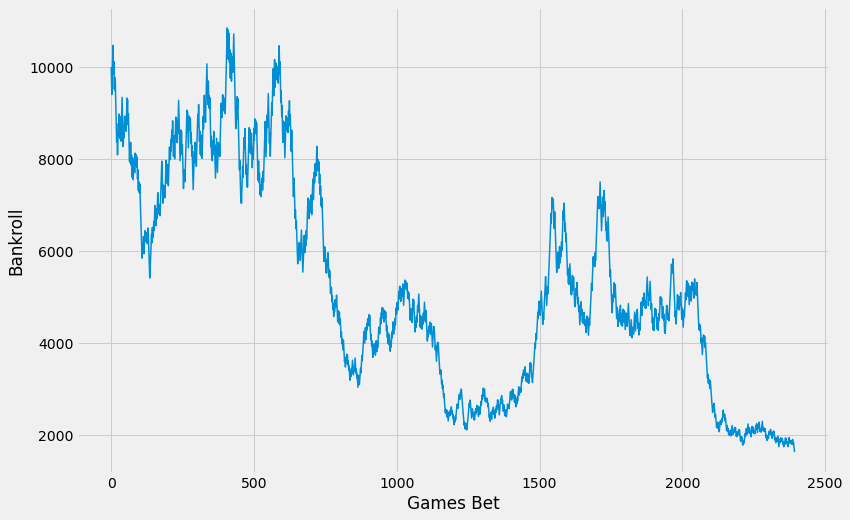

min balance: 1633.9392604286886 
max balance: 10855.937463922277 
final balance: 1678.501240258562 
win percentage 51.800000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21700077  NOP vs. CLE          2.5  2.150000  1.740741   
1         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
2         3  21700082  UTA vs. LAL        -11.0  1.181818  5.160000   
3         5  21700085  ATL vs. MIL          6.0  2.950000  1.416667   
4         7  21700087  BKN vs. DEN          5.5  2.750000  1.454545   
...     ...       ...          ...          ...       ...       ...   
2389   3491  41900402  LAL vs. MIA        -11.0  1.157480  4.930000   
2390   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   
2391   3493  41900404  MIA vs. LAL          7.5  3.520000  1.273973   
2392   3494  41900405  LAL vs. MIA         -7.5  1.289855  3.070000   
2393   3495  41900406  MIA vs. LAL          5.5  3.100000  1.400000   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 123              101               22           1   
1                 103               89               14           1   
2                  96               81               15           1   
3                 106              117              -11           0   
4                 111              124              -13           0   
...               ...              ...              ...         ...   
2389              124              114               10           0   
2390              115              104               11           1   
2391               96              102               -6           1   
2392              108              111               -3           0   
2393               93              106              -13           0   

      prob_home  prob_away  prob_avg  bet_home1  bet_home2  bet_home3  \
0      0.353688   0.497444  0.428122          0          1          0   
1      0.346641   0.500182  0.423230          0          0          0   
2      0.554737   0.335833  0.609452          1          1          1   
3      0.392677   0.484817  0.453930          0          1          0   
4      0.371665   0.553006  0.409329          0          0          0   
...         ...        ...       ...        ...        ...        ...   
2389   0.422021   0.403002  0.509509          0          1          1   
2390   0.402033   0.424403  0.488815          0          1          0   
2391   0.379051   0.440205  0.469423          0          1          0   
2392   0.446823   0.367592  0.539616          0          1          1   
2393   0.358095   0.464994  0.446550          0          1          0   

        bankroll_i    bankroll_n    bet_size  bet_won  
0     10000.000000   9700.000000  300.000000        0  
1      9700.000000   9409.000000  291.000000        0  
2      9409.000000   9665.609091  282.270000        1  
3      9665.609091   9929.216612  289.968273        1  
4      9929.216612  10200.013428  297.876498        1  
...            ...           ...         ...      ...  
2389   1845.648402   1790.278950   55.369452        0  
2390   1790.278950   1736.570582   53.708369        0  
2391   1736.570582   1684.473464   52.097117        0  
2392   1684.473464   1633.939260   50.534204        0  
2393   1633.939260   1678.501240   49.018178        1  

[2394 rows x 20 columns]

In [215]:
best_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.06216789465208998,
                               epsilon=0.0012606391088660915, loss='log',
                               max_iter=5000))])

best_sgd =  Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.018329807108324356,
                               epsilon=0.6951927961775606, loss='log',
                               max_iter=10000))])

# search_spaces = {
#     'sgdregressor__alpha':Real(1e-3, 1e+0, prior='log-uniform'),
#     'sgdregressor__epsilon':Real(1, 10)
# }

# sgd_cv_diff = BayesSearchCV(sgd_pipe_diff, search_spaces=search_spaces, scoring='neg_mean_absolute_error', cv=tscv, n_iter=50)


best_sgd.fit(X_train2, cover_train2)

sgd_probs_train2 = best_sgd.predict_proba(X_train2)

sgd_prob_test2 = best_sgd.predict_proba(X_test2)

bets_train = create_betting_df(df_19, sgd_probs_train2, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, sgd_prob_test2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())

select_bets = bets_test.loc[~bets_test['prob_home'].between(1-0.544, .544)]    
simulate_bets(select_bets)


<AxesSubplot:ylabel='feature'>

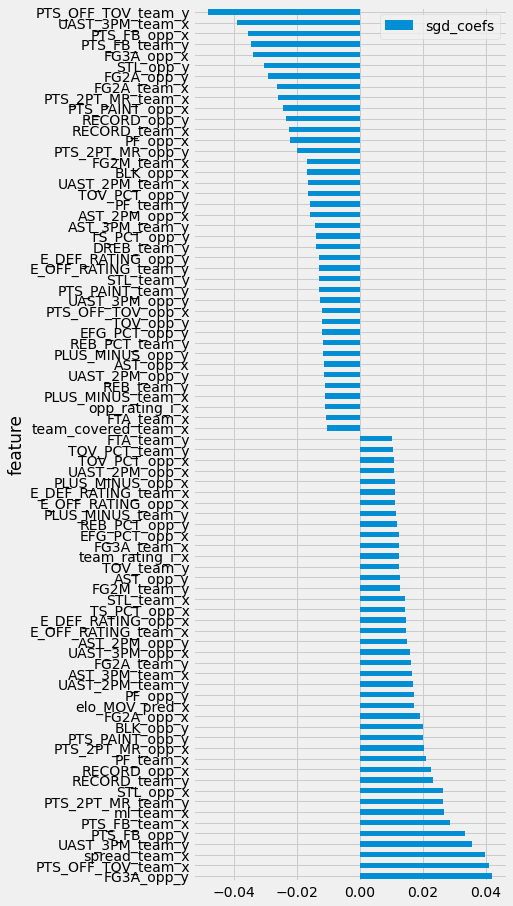

In [200]:
feature_names = X_train1.columns
sgd_coefs = best_sgd.named_steps['sgd'].coef_[0]

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_coefs':sgd_coefs
                           })
coef_df_sgd.loc[abs(coef_df_sgd['sgd_coefs'])>0.01].sort_values('sgd_coefs', ascending=False).plot.barh(figsize=(5,15),
                                                                                                           x='feature')

#### SGD RFE

In [867]:
scaler = StandardScaler()
X_train1_sc = scaler.fit_transform(X_train1)
X_test1_sc = scaler.transform(X_test1)

best_sgd_diff= SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet')

rfe_sgd = RFECV(best_sgd_diff, cv=tscv, scoring='neg_mean_absolute_error')
rfe_sgd.fit(X_train1_sc, point_diff_train1)


RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                             l1_ratio=1.0, loss='huber', max_iter=5000,
                             penalty='elasticnet'),
      scoring='neg_mean_absolute_error')

mae_diff_sgd_reduced: 13.483472170841289


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.25
best prediction strat: 2
num_games_bet: 454
win percetange at threshold: 0.5440528634361234


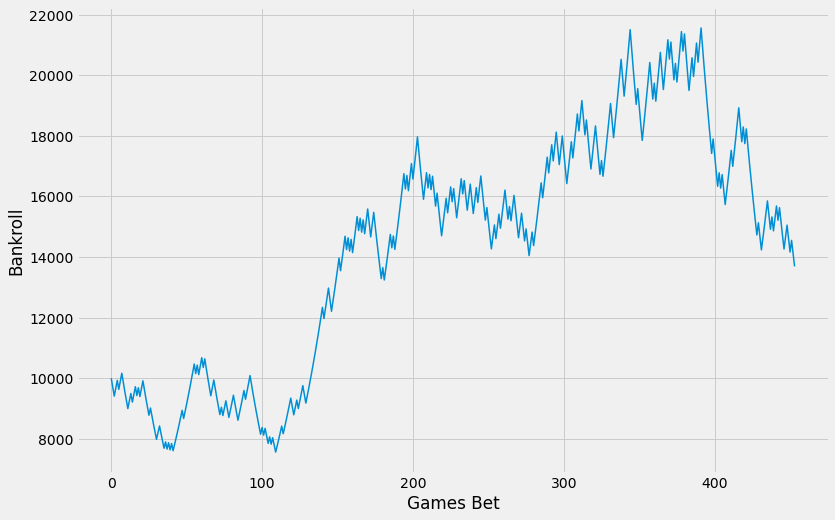

min balance: 7560.705293314098 
max balance: 21564.898338453335 
final balance: 14064.726761039305 
win percentage 54.410000000000004


index   GAME_ID MATCHUP_home  spread_home   ml_home  ml_away  \
0       11  21600096  CHI vs. ORL         -7.0  1.333333     3.40   
1       12  21600097  OKC vs. MIA         -5.5  1.425532     2.95   
2       14  21600099  GSW vs. NOP        -16.5  1.020000    14.00   
3       18  21600104  LAL vs. DAL         -4.0  1.571429     2.55   
4       20  21600106  NYK vs. BKN         -8.0  1.277778     3.80   
..     ...       ...          ...          ...       ...      ...   
449   2440  41700313  GSW vs. HOU         -7.5  1.250000     3.85   
450   2442  41700314  GSW vs. HOU         -7.5  1.232558     4.40   
451   2445  41700306  CLE vs. BOS         -7.0  1.322581     3.50   
452   2446  41700316  GSW vs. HOU        -12.5  1.094340     6.50   
453   2449  41700401  GSW vs. CLE        -13.0  1.100000     7.20   

     team_score_home  team_score_away  point_diff_home  cover_home  \
0                112               80               32           1   
1                 97               85               12           1   
2                116              106               10           0   
3                 97              109              -12           0   
4                110               96               14           1   
..               ...              ...              ...         ...   
449              126               85               41           1   
450               92               95               -3           0   
451              109               99               10           1   
452              115               86               29           1   
453              124              114               10           0   

     score_pred_home  score_pred_away  score_pred_diff  diff_preds_home  \
0         100.075529       105.306658        -5.231129         5.235371   
1         101.156827       101.580772        -0.423945         4.211420   
2         102.447470       105.595805        -3.148336        14.129172   
3         105.568476       101.949743         3.618733         1.200852   
4         104.692782       110.632741        -5.939959         6.739925   
..               ...              ...              ...              ...   
449       104.091055       107.778061        -3.687006         5.412862   
450       101.102738       108.105243        -7.002505         5.846622   
451        97.901593        99.727420        -1.825827         5.531878   
452        98.246613       106.274410        -8.027797         9.869949   
453        97.112530       104.877126        -7.764596        11.569969   

     diff_preds_away  point_diff_avg  bet_home1  bet_home2  bet_home3  \
0          -5.470670        5.353020          0          0          0   
1          -4.503992        4.357706          0          0          0   
2         -14.789008       14.459090          0          0          0   
3          -1.572029        1.386440          0          0          0   
4          -7.189000        6.964463          0          0          0   
..               ...             ...        ...        ...        ...   
449        -6.190781        5.801822          0          0          0   
450        -6.688231        6.267426          0          0          0   
451        -6.075165        5.803521          0          0          0   
452       -10.782762       10.326356          0          0          0   
453       -12.436212       12.003090          0          0          0   

     bet_home4  confidence_pred1  confidence_pred2  confidence_pred3  \
0            0        -12.231129         -1.764629         -1.529330   
1            0         -5.923945         -1.288580         -0.996008   
2            0        -19.648336         -2.370828         -1.710992   
3            0         -0.381267         -2.799148         -2.427971   
4            0        -13.939959         -1.260075         -0.811000   
..         ...               ...               ...               ...   
449          0        -11.187006         -2.087138   

In [872]:
best_sgd_diff_reduced = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])

best_sgd_diff_reduced.fit(X_train1.loc[:, rfe_sgd.support_], point_diff_train1)


diff_preds_sgd_reduced = best_sgd_diff_reduced.predict(X_test1.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)

print("mae_diff_sgd_reduced:", mae_diff)

select_bets_sgd, bet_thresholds_lr_sgd = find_optimal_confidence_thresholds(diff_preds_sgd_reduced, sgd_preds_score, test_idx1)
simulate_bets(select_bets_sgd)

<AxesSubplot:ylabel='feature'>

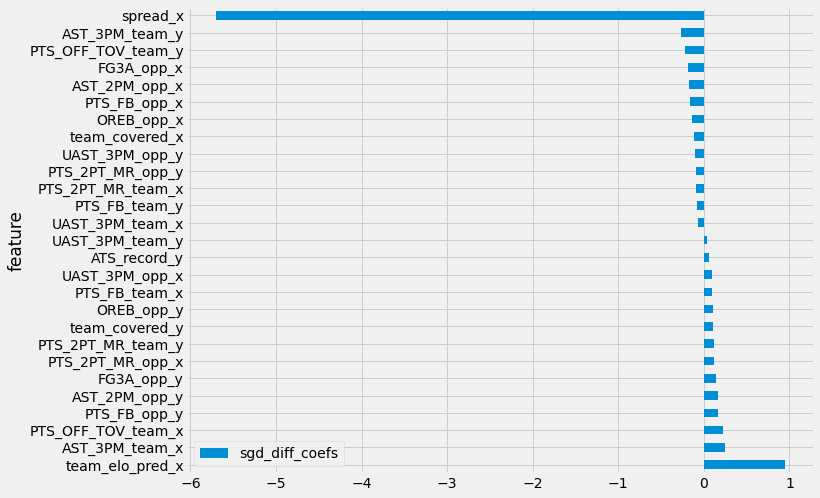

In [874]:
feature_names = X_train1.loc[:, rfe_sgd.support_].columns
sgd_diff_coefs = best_sgd_diff_reduced.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_diff_coefs':sgd_diff_coefs})

coef_df_sgd.loc[coef_df_sgd['sgd_diff_coefs']!=0].sort_values('sgd_diff_coefs', ascending=False).plot.barh(figsize=(10,8), x='feature')

mae_diff: 9.933691663701811


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


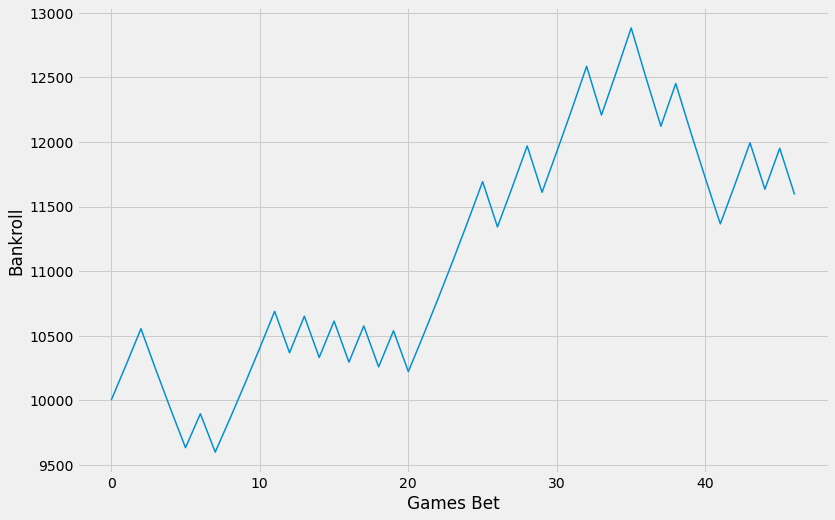

min balance: 9597.192634639892 
max balance: 12883.481930176657 
final balance: 11244.759210318141 
win percentage 57.45


index   GAME_ID MATCHUP_home  spread_home   ml_home    ml_away  \
0      14  21800094  SAS vs. DAL         -7.0  1.333333   3.500000   
1      71  21800151  PHX vs. BKN          2.5  2.200000   1.714286   
2     115  21800195  MIN vs. BKN         -4.0  1.571429   2.550000   
3     144  21800224  BKN vs. LAC          4.0  2.550000   1.526316   
4     250  21800330  NYK vs. MIL          8.0  4.000000   1.250000   
5     251  21800331  DET vs. GSW          4.5  2.600000   1.476190   
6     297  21800377  MIL vs. GSW         -2.0  1.800000   2.050000   
7     306  21800386  LAC vs. MIA         -9.5  1.175439   5.000000   
8     313  21800393  BOS vs. NOP         -2.5  1.740741   2.150000   
9     335  21800415  GSW vs. TOR         -8.0  1.238095   3.890000   
10    348  21800428  SAC vs. GSW          7.5  3.700000   1.294118   
11    446  21800526  LAL vs. LAC          7.0  3.400000   1.344828   
12    584  21800664  LAC vs. UTA         -1.0  1.869565   1.952381   
13    653  21800733  DEN vs. PHI        -10.5  1.149254   4.750000   
14    718  21800798  IND vs. LAL          2.5  2.200000   1.714286   
15    860  21800940  SAS vs. OKC         -5.0  1.526316   2.650000   
16    928  21801008  PHI vs. CLE        -15.5  1.066667   8.750000   
17    952  21801032  SAS vs. NYK        -13.5  1.083333   8.000000   
18   1149  21801229  LAC vs. UTA         -8.0  1.294118   3.700000   
19   1155  41800101  MIL vs. DET        -15.0  1.047619  11.700000   
20   1251  21900096  GSW vs. POR         11.5  6.500000   1.100000   
21   1255  21900100  CHI vs. LAL          7.0  3.700000   1.294118   
22   1278  21900123  DEN vs. PHI         -5.0  1.476190   2.750000   
23   1280  21900125  POR vs. BKN         -4.0  1.606061   2.450000   
24   1294  21900139  LAL vs. TOR        -10.5  1.161290   4.750000   
25   1306  21900151  PHX vs. LAL          3.5  2.400000   1.571429   
26   1329  21900174  LAL vs. SAC        -10.5  1.153846   5.250000   
27   1356  21900201  LAL vs. OKC        -11.5  1.117647   6.200000   
28   1547  21900406  LAC vs. PHX        -14.5  1.071429   6.560000   
29   1633  21900506  MIL vs. MIN        -18.0  1.020000  13.750000   
30   1707  21900580  OKC vs. LAL         -9.0  1.222222   4.000000   
31   1844  21900719  LAC vs. SAC        -14.5  1.066667   8.000000   
32   1852  21900727  LAC vs. MIN        -10.5  1.153846   5.000000   
33   1907  21900782  MIN vs. LAC         10.0  5.000000   1.165289   
34   1969  21900844  DEN vs. MIN        -14.5  1.052002   9.500000   
35   1979  21900854  DAL vs. MIN        -14.0  1.076923   8.900000   
36   2050  21900925  POR vs. WAS         -8.0  1.285714   3.750000   
37   2063  21900938  PHX vs. POR          3.5  2.440000   1.571429   
38   2082  21900958  DEN vs. MIL         -7.5  1.312500   3.400000   
39   2090  21900966  POR vs. PHX         -6.5  1.377358   3.000000   
40   2118  21901252  WAS vs. IND          8.5  4.150000   1.232558   
41   2140  21901274  SAS vs. UTA         -9.0  1.235294   3.900000   
42   2146  21901280  POR vs. LAC         -4.5  1.282486   2.600000   
43   2149  21901283  MIA vs. PHX          4.0  2.380000   1.571429   
44   2174  21901309  BKN vs. POR         10.5  5.300000   1.151515   
45   2241  41900223  HOU vs. LAL          4.5  2.440000   1.526316   
46   2244  41900224  HOU vs. LAL          5.5  2.750000   1.322581   

    team_score_home  team_score_away  point_diff_home  cover_home  \
0               113              108                5           0   
1                82              104              -22           0   
2               120              113                7           1   
3               119              127               -8           0   
4               136              134                2           1   
5               111              102                9           1   
6                95              105              -10           0   
7                98              121              -23           0   
8               113   

In [876]:
best_sgd_diff_reduced.fit(X_train2.loc[:, rfe_sgd.support_], point_diff_train2)


diff_preds_sgd2_reduced = best_sgd_diff_reduced.predict(X_test2.loc[:, rfe_sgd.support_])

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_sgd2_reduced)

print("mae_diff:", mae_diff)

bets = create_betting_df(final_df_ewm_19, diff_preds_sgd2_reduced, score_preds_sgd2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > 1.5]    
simulate_bets(select_bets)

In [695]:
### Light Gradient Boost

In [ ]:
lgbc = lgb.LGBMClassifier()


X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(df, cutoff_17)
lgbc.fit(X_train1, cover_train1)
preds_train_lgbc = lgbc.predict(X_train1)   
preds_test_lgbc = lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

In [415]:


X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)
X_train1 = X_train1.astype(float)
X_test1 = X_test1.astype(float)
cover_train1 = cover_train1.astype(int)
cover_test1 = cover_test1.astype(int)

In [429]:
X_train1['FG2A_team']

FG2A_team  FG2A_team
0      29.683866       30.0
1      35.902615       35.8
2      30.049742       29.8
3      28.255452       28.2
4      37.570975       37.6
...          ...        ...
24845  26.240134       24.6
24846  29.249894       31.0
24847  25.916110       26.6
24848  25.724494       26.6
24849  29.124900       30.6

[24850 rows x 2 columns]

In [442]:
lgbc = lgb.LGBMClassifier()

search_spaces = {'min_child_weight':Integer(1,16),
              'subsample': Real(0.6, 1),
              'max_depth': Integer(3, 20),
              'reg_lambda': Integer(1, 20),
              'reg_alpha': Integer(0, 1),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)
                }
    
    
lgbc_bs = BayesSearchCV(lgb.LGBMClassifier(objective='binary', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=100)


lgbc_bs.fit(X_train1, cover_train1)

best_lgbc = lgbc_bs.best_estimator_

print("best_lgbr:", best_lgbc)

preds_train_lgbc = best_lgbc.predict(X_train1)   
preds_test_lgbc = best_lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   25.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


[LightGBM] [Warning] feature_fraction is set=0.8091701319933615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8091701319933615
best_lgbr: LGBMClassifier(feature_fraction=0.8091701319933615, max_depth=3,
               min_child_weight=3, num_leaves=1461, objective='binary',
               reg_alpha=0, reg_lambda=2, subsample=0.7695035174798582,
               subsample_freq=1)
train_acc: 0.6349295774647887 test_acc: 0.5194974003466204


In [166]:
np.logspace(-4, 1, 20)

array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  1.1min remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    2.2s finished


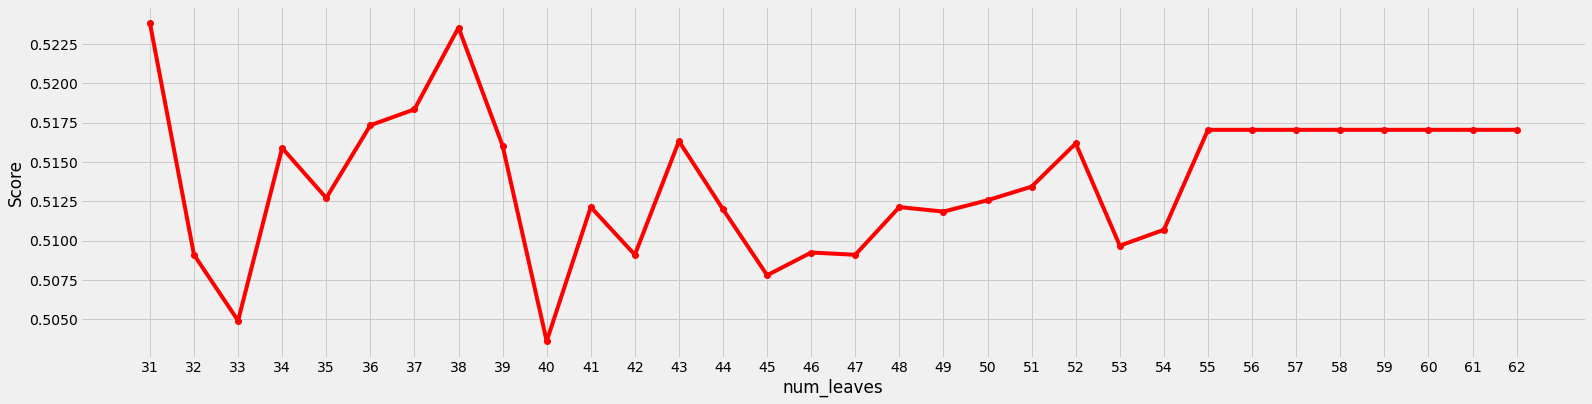

LGBMClassifier(feature_fraction=1, max_depth=6, min_child_weight=5.544,
               random_state=23, reg_alpha=0, reg_lambda=1, subsample=0.6) 0.5238301559792028


In [384]:
lgbc = lgb.LGBMClassifier(feature_fraction=1, max_depth=6, num_leaves=31, min_child_weight=5.544,
               reg_lambda=1, reg_alpha=0, subsample=0.6, random_state=23)

grid = {
#     'min_child_weight':np.logspace(-4, 1, 10),
#     'reg_lambda':np.logspace(-4, 1, 11),
#     'reg_alpha':np.logspace(-4, 1, 11)
#     'feature_fraction':np.linspace(0.01, 1.0, 10),
    'boosting_type':['gbdt'],
#     'max_depth':np.arange(6,11,1),
    
                }


param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(lgbc, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)

In [376]:
best_lgbc = lgb.LGBMClassifier(feature_fraction=0.34, max_depth=19, min_child_weight=7,
               num_leaves=57, random_state=23, reg_lambda=0.0001,
               subsample=0.6)

best_lgbc.fit(X_train1, cover_train1)

preds_train_lgbc = best_lgbc.predict(X_train1)   
preds_test_lgbc = best_lgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_lgbc)
test_acc = accuracy_score(cover_test1, preds_test_lgbc)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

[LightGBM] [Warning] feature_fraction is set=0.34, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34
train_acc: 0.9355734406438632 test_acc: 0.5059214326978625


0.5109837631327603


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 1
best threshold: 0.518
num_games_bet: 485
win percetange at threshold: 0.5381443298969072


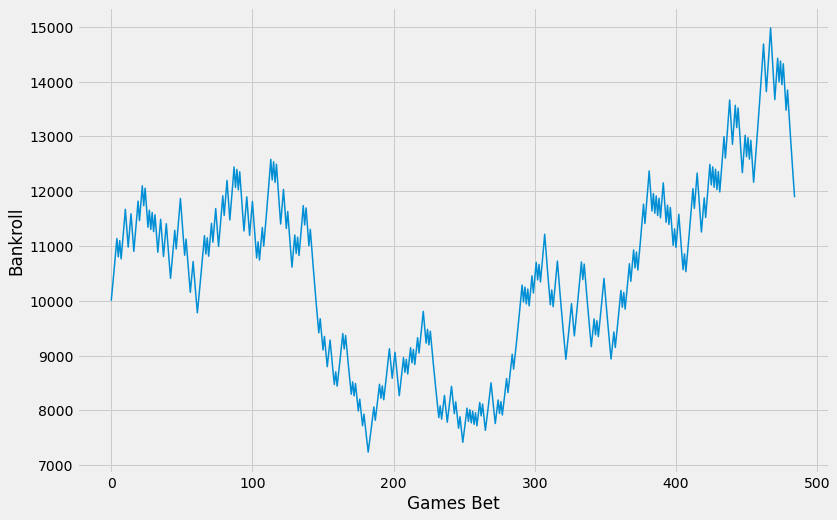

min balance: 7238.220780151876 
max balance: 14978.766039283293 
final balance: 12213.816714654682 
win percentage 53.81


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0        0  21900073  CHI vs. DET         -2.5               57   
1        3  21900078  DET vs. BKN          2.0               46   
2        4  21900079  ORL vs. DEN          1.5               45   
3        5  21900082  MIL vs. TOR         -3.5               66   
4        8  21900086  MIA vs. HOU          1.5               71   
..     ...       ...          ...          ...              ...   
480   1026  41900235  LAC vs. DEN         -4.5               56   
481   1027  41900225  LAL vs. HOU         -3.5               62   
482   1031  41900302  BOS vs. MIA         -1.5               60   
483   1033  41900303  MIA vs. BOS          3.0               50   
484   1036  41900304  MIA vs. BOS          3.0               50   

     team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                 52              5.0           1   0.528354   0.480279   
1                 54             -8.0           0   0.478481   0.522165   
2                 40              5.0           1   0.521815   0.496812   
3                 50             16.0           1   0.529880   0.459982   
4                 46             25.0           1   0.464053   0.539146   
..               ...              ...         ...        ...        ...   
480               44             12.0           1   0.472172   0.529422   
481               51             11.0           1   0.481278   0.525189   
482               47             13.0           1   0.477905   0.517117   
483               63            -13.0           0   0.550506   0.461680   
484               44              6.0           1   0.543983   0.472710   

     prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0    0.524037          1          1          1  10000.000000  10272.727273   
1    0.478158          0          0          0  10272.727273  10552.892562   
2    0.512501          1          1          1  10552.892562  10840.698723   
3    0.534949          1          1          1  10840.698723  11136.354142   
4    0.462453          0          0          0  11136.354142  10802.263518   
..        ...        ...        ...        ...           ...           ...   
480  0.471375          0          0          0  13430.083199  13027.180703   
481  0.478045          0          0          0  13027.180703  12636.365282   
482  0.480394          0          0          0  12636.365282  12257.274324   
483  0.544413          1          1          1  12257.274324  11889.556094   
484  0.535637          1          1          1  11889.556094  12213.816715   

       bet_size  bet_won  
0    300.000000        1  
1    308.181818        1  
2    316.586777        1  
3    325.220962        1  
4    334.090624        0  
..          ...      ...  
480  402.902496        0  
481  390.815421        0  
482  379.090958        0  
483  367.718230        0  
484  356.686683        1  

[485 rows x 18 columns]

In [62]:
print(accuracy_score(cover_test1, lgbr_preds))

select_bets_lgbr, bet_thresholds_lgbr = find_optimal_threshold(df_ewm_9_diffs, lgbr_probs,
                                                                               test_idx1)
simulate_bets(select_bets_lgbr)


In [1206]:
bet_thresholds_lgbr

index  prediction_num  confidence_thresholds  num_games_bet  \
0      1220               2                   2.21            252   
1      1221               2                   2.22            251   
2      2216               3                   2.17            238   
3      1222               2                   2.23            249   
4      1223               2                   2.24            249   
...     ...             ...                    ...            ...   
1463    420               1                   4.21             15   
1464    421               1                   4.22             15   
1465    422               1                   4.23             15   
1466    423               1                   4.24             15   
1467    424               1                   4.25             15   

      win_percentage  expected_profits  
0           0.563492              2320  
1           0.561753              2220  
2           0.563025              2168  
3           0.558233              2020  
4           0.558233              2020  
...              ...               ...  
1463        0.533333                44  
1464        0.533333                44  
1465        0.533333                44  
1466        0.533333                44  
1467        0.533333                44  

[1468 rows x 6 columns]

### XGB

In [422]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed: 16.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 18.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.9s finished


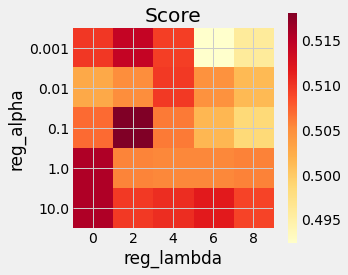

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, subsample=1,
              subsample_bytree=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None) 0.5181975736568457


In [430]:

# xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints='',
#               learning_rate=0.2, max_delta_step=0, max_depth=6,
#               min_child_weight=1, monotone_constraints='()',
#               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
#               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#               tree_method='exact', validate_parameters=1, verbosity=None)


xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=20, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=1,
              subsample_bytree=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)

grid = {
#      "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
#   "min_child_weight" : [8, 9, 10, 11, 12, 15, 20],
#  "gamma"            : np.linspace(0, 3, 10)
#  "colsample_bytree" : [0.8, 0.9, 0.95, 1.0],
# "subsample_bytree":[0.5, 0.6, 0.7, 0.8, 0.9, 1],
"reg_alpha":np.logspace(-3,1, 5),
"reg_lambda":np.arange(0, 10, 2),
#     'learning_rate':np.logspace(-3,-.5, 20)
}   
 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(xgbc, param_grid,
                                                            X_train1, cover_train1, 
                                                            X_test1, cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)


In [428]:
best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=20, missing=np.nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0, reg_lambda=4, scale_pos_weight=1, subsample=1,
              subsample_bytree=0.5, tree_method='exact', validate_parameters=1,
              verbosity=None)


best_xgbc.fit(X_train1, cover_train1)


preds_train_xgb = best_xgbc.predict(X_train1)   
preds_test_xgb = best_xgbc.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_train_xgb)
test_acc = accuracy_score(cover_test1, preds_test_xgb)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

[07:38:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { subsample_bytree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


train_acc: 0.8302213279678068 test_acc: 0.523108030040439


accuracy: 0.4894937917860554


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best_strategy: 2
best threshold: 0.732
num_games_bet: 24
win percetange at threshold: 0.5833333333333334


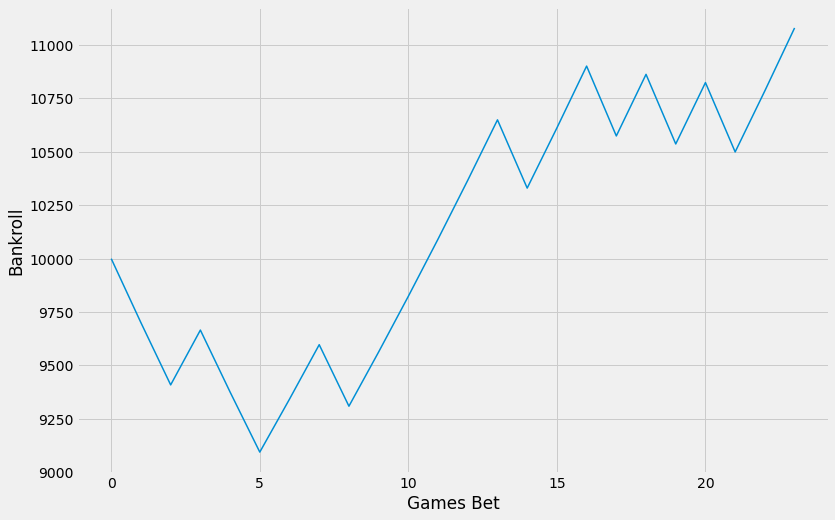

min balance: 9094.371593636364 
max balance: 11080.164929149007 
final balance: 10747.759981274536 
win percentage 58.330000000000005


index   GAME_ID MATCHUP_home  spread_home  team_score_home  \
0     103  21900184  SAC vs. BOS          1.0               50   
1     140  21900222  DEN vs. BOS         -2.5               45   
2     154  21900236  NYK vs. BKN          1.0               46   
3     220  21900302  NOP vs. DAL          2.0               53   
4     228  21900310  BOS vs. MIA         -3.0               52   
5     240  21900322  DET vs. IND          0.5               55   
6     397  21900482  GSW vs. DAL          6.5               74   
7     413  21900499  SAC vs. LAC          3.0               40   
8     429  21900516  LAC vs. DET         -7.5               69   
9     449  21900536  CLE vs. MIN          3.0               48   
10    479  21900566  OKC vs. HOU          1.5               60   
11    517  21900604  BOS vs. DET         -6.0               59   
12    526  21900613  LAL vs. ORL         -6.5               58   
13    562  21900649  MIN vs. DEN         -1.5               54   
14    577  21900664  PHX vs. IND          0.5               48   
15    631  21900719  LAC vs. SAC         -8.0               47   
16    703  21900792  POR vs. MIA         -3.5               63   
17    719  21900809  BKN vs. TOR          1.5               52   
18    817  21900908  SAS vs. IND          0.5               57   
19    852  21900944  GSW vs. PHI          1.5               55   
20    883  21901235  WAS vs. PHX          4.0               52   
21    892  21901244  BKN vs. WAS         -2.5               54   
22   1018  41900215  TOR vs. BOS          0.5               35   
23   1019  41900233  DEN vs. LAC          5.0               59   

    team_score_away  point_diff_home  cover_home  prob_home  prob_away  \
0                46              4.0           1   0.260377   0.657327   
1                34             11.0           1   0.259044   0.684801   
2                52             -6.0           0   0.224145   0.642053   
3                59             -6.0           0   0.748982   0.337911   
4                44              8.0           1   0.258953   0.519840   
5                44             11.0           1   0.814541   0.322009   
6                72              2.0           1   0.752786   0.346833   
7                57            -17.0           0   0.741847   0.191008   
8                63              6.0           0   0.247013   0.498271   
9                66            -18.0           0   0.264887   0.606064   
10               48             12.0           1   0.794323   0.449885   
11               57              2.0           0   0.244509   0.581333   
12               65             -7.0           0   0.261467   0.665554   
13               55             -1.0           0   0.760303   0.334019   
14               54             -6.0           0   0.256423   0.517853   
15               64            -17.0           0   0.257611   0.490032   
16               60              3.0           0   0.734071   0.515923   
17               40             12.0           1   0.834522   0.209760   
18               66             -9.0           0   0.776965   0.415000   
19               57             -2.0           0   0.262336   0.440277   
20               67            -15.0           0   0.744075   0.389068   
21               54              0.0           0   0.232312   0.679765   
22               62            -27.0           0   0.265190   0.630785   
23               57              2.0           1   0.250465   0.703518   

    prob_avg  bet_home1  bet_home2  bet_home3    bankroll_i    bankroll_n  \
0   0.301525          0          0          0  10000.000000   9700.000000   
1   0.287121          0          0          0   9700.000000   9409.000000   
2   0.291046          0          0          0   9409.000000   9665.609091   
3   0.705535          1          1          1   9665.609091   9375.640818   
4   0.369557          0          0          0   9375.640818   9094.371594   
5   0.746266          1          1      

In [64]:
xgb_preds = best_xgb.predict(X_test1)
xgb_probs = best_xgb.predict_proba(X_test1)

print("accuracy:", accuracy_score(cover_test1, xgb_preds))

select_bets_xgb, bet_thresholds_xgb = find_optimal_threshold(df_ewm_9_diffs, xgb_probs,
                                                                               test_idx1)
simulate_bets(select_bets_xgb)

In [182]:
xgb.XGBClassifier()

dtrain = xgb.DMatrix(X_train1, label=cover_train1)
dtest = xgb.DMatrix(X_test1, label=cover_test1)

baseline_preds = np.ones(cover_test1.shape)
baseline_acc = accuracy_score(cover_test1, baseline_preds)
print("Baseline_Accuracy:", baseline_acc)

params = {
    'max_depth':6,
    'min_child_weight':1,
    'eta':0.3,
    'subsample':1,
    'colsample_bytree':1,
    'eval_metric':'error'
}
num_boost_round=999
model = xgb.train(params,
                 dtrain,
                 num_boost_round=num_boost_round,
                 evals=[(dtest, "Test")],
                 early_stopping_rounds=10
                 )
print("Best accuracy: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Baseline_Accuracy: 0.5
[0]	Test-error:0.48426
Will train until Test-error hasn't improved in 10 rounds.
[1]	Test-error:0.49191
[2]	Test-error:0.48931
[3]	Test-error:0.49581
[4]	Test-error:0.49552
[5]	Test-error:0.50101
[6]	Test-error:0.49422
[7]	Test-error:0.48859
[8]	Test-error:0.48917
[9]	Test-error:0.48729
[10]	Test-error:0.48686
Stopping. Best iteration:
[0]	Test-error:0.48426

Best accuracy: 0.48 with 1 rounds


In [184]:
gridsearch_params = 


cv_results = xgb.cv(
params,
dtrain,
num_boost_round=num_boost_round,
seed=23,
folds=tscv,
metrics='error',
early_stopping_rounds=10)

cv_results

train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.418994         0.020154         0.496547        0.006958
1          0.391851         0.020279         0.495098        0.007923

In [304]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [305]:
rf = RandomForestClassifier(max_features='auto',
                                 max_depth=11)

    
    
grid = {
     "max_depth":np.arange(3, 16, 3),
#   "min_samples_split":np.linspace(0.01, 0.5, 5)
#  "min_samples_leaf":np.linspace(0, 3, 20)
"max_features":[0.5, 0.6, 0.7, 0.8, 0.9, 1, 'log2', 'auto']
} 

param_grid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(rf, param_grid,
                                                            X_train1.iloc[:, 1:], cover_train1, 
                                                            X_test1.iloc[:, 1:], cover_test1,
                                                            metric=accuracy_score)

print(best_model, best_score)

rf_bs = BayesSearchCV(RandomForestClassifier(), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1, n_iter=50)

rf_bs.fit(X_train1, cover_train1)

best_rf = rf_bs.best_estimator_

print("best_rf:", best_rf)

preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [25]:
np.linspace(0.01, 0.5, 5)

array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ])

In [240]:
best_rf = RandomForestClassifier(max_features='auto',
                                 max_depth=11)
params = {
    'min_samples_leaf':np.linspace(0.01, 0.5, 5),
         'min_samples_split':np.linspace(0.01, 0.5, 5)}

rf_gs = GridSearchCV(best_rf, param_grid = params,
                        cv=model, verbose=1, n_jobs=-1)

rf_gs.fit(X_train1, cover_train1)
best_rf = rf_gs.best_estimator_

print("best_rf:", best_rf)

preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.7min finished


best_rf: RandomForestClassifier(max_depth=11, min_samples_leaf=0.01,
                       min_samples_split=0.255)
train_acc: 0.5465995975855131 test_acc: 0.5171865973425765


In [308]:
best_rf = RandomForestClassifier(max_depth=11, min_samples_leaf=0.255, max_features='log2',
                       min_samples_split=0.1325, random_state=23)

best_rf.fit(X_train1, cover_train1)


preds_rf_train = best_rf.predict(X_train1)
preds_rf_test = best_rf.predict(X_test1)

train_acc = accuracy_score(cover_train1, preds_rf_train)
test_acc = accuracy_score(cover_test1, preds_rf_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)

train_acc: 0.5268812877263581 test_acc: 0.5229636048526863


### Stacked Classifier

In [223]:
X_train1

FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  FTM_team_ewm  \
150        29.683866       1.865937       5.853899      8.240605   
151        35.902615       2.518229       7.054724      5.409611   
156        30.049742       2.331225       6.385485     11.590950   
157        28.255452       4.040023       9.304779     10.890894   
158        37.570975       2.318893       6.383092      8.105028   
...              ...            ...            ...           ...   
28407      26.240134       6.913866      16.587010      9.555997   
28408      29.249894       6.766958      16.272068      7.893058   
28409      25.916110       6.722473      16.728314     10.000412   
28410      25.724494       7.350244      17.255498     10.700391   
28411      29.124900       6.690260      16.244860      8.503772   

       FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  AST_team_ewm  \
150       13.531367       5.635149      14.545237     20.180386     11.058948   
151        8.130033       7.012527      17.679886     24.692413     11.863276   
156       16.485654       4.353838      16.568973     20.922810      9.400527   
157       14.867793       7.073454      15.231692     22.305145      9.750849   
158       11.381505       8.776684      15.510952     24.287636     11.378526   
...             ...            ...            ...           ...           ...   
28407     11.839105       4.193624      18.419891     22.613515     12.561225   
28408      9.937359       4.749156      18.056017     22.805172     16.626294   
28409     12.355211       3.974254      17.877884     21.852139     11.905081   
28410     13.719730       4.276838      17.390081     21.666919     12.514591   
28411     10.743649       4.974248      17.250388     22.224636     16.663666   

       STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  PTS_team_ewm  \
150        3.731460      2.309174     11.259798    11.674074     47.957876   
151        4.282630      2.384337     10.496740    11.745330     46.557813   
156        3.345755      1.596786     10.212376    12.085810     43.645845   
157        4.863471      1.604405      8.558912    12.967058     46.865962   
158        3.980000      1.630070      8.582672    11.757515     52.038143   
...             ...           ...           ...          ...           ...   
28407      3.964638      2.474170      7.423562     8.229057     59.540355   
28408      4.947909      2.993926      8.093800    10.619272     60.819005   
28409      4.068178      2.426752      7.581211     8.506160     59.686324   
28410      4.161363      2.184070      7.223079     8.855555     62.317770   
28411      4.553105      3.094537      8.184423    11.357369     61.537128   

       PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  E_DEF_RATING_team_ewm  \
150              -0.690874             101.700105             101.432297   
151              -0.961661              93.218803              93.525518   
156              -6.778711              87.986347              99.275468   
157               2.899270             103.620388              96.894193   
158               6.427511             106.959579              92.396926   
...                    ...                    ...                    ...   
28407             5.862437             116.463388             103.887120   
28408             6.748616             114.249501             101.394138   
28409             4.676154             115.807027             105.258453   
28410             6.008578             120.026449             107.342669   
28411             4.273673             115.434590             107.054910   

       E_NET_RATING_team_ewm  POSS_team_ewm  PIE_team_ewm  \
150                 0.267808      46.685453      0.482559   
151                -0.284738      49.423067      0.524247   
156               -11.249342      49.006276      0.419082   
157                 6.710173      45.348075      0.556933   
158                14.584630      47.869698      0.585109   
.

In [225]:
full_df_combined.loc[full_df_combined['SEASON_YEAR_team'] == '2010-11']

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
10504          2010-11   1610612748                    MIA   
10505          2010-11   1610612738                    BOS   
10506          2010-11   1610612756                    PHX   
10507          2010-11   1610612757                    POR   
10508          2010-11   1610612745                    HOU   
...                ...          ...                    ...   
13121          2010-11   1610612742                    DAL   
13122          2010-11   1610612748                    MIA   
13123          2010-11   1610612742                    DAL   
13124          2010-11   1610612742                    DAL   
13125          2010-11   1610612748                    MIA   

               TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
10504              Miami Heat  21000001     2010-10-26    MIA @ BOS   
10505          Boston Celtics  21000001     2010-10-26  BOS vs. MIA   
10506            Phoenix Suns  21000002     2010-10-26    PHX @ POR   
10507  Portland Trail Blazers  21000002     2010-10-26  POR vs. PHX   
10508         Houston Rockets  21000003     2010-10-26    HOU @ LAL   
...                       ...       ...            ...          ...   
13121        Dallas Mavericks  41000404     2011-06-07  DAL vs. MIA   
13122              Miami Heat  41000405     2011-06-09    MIA @ DAL   
13123        Dallas Mavericks  41000405     2011-06-09  DAL vs. MIA   
13124        Dallas Mavericks  41000406     2011-06-12    DAL @ MIA   
13125              Miami Heat  41000406     2011-06-12  MIA vs. DAL   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
10504              0              30             -15       0          -0   
10505              1              45              15       1           0   
10506              0              46              -4       0           4   
10507              1              50               4       1          -4   
10508              0              62              11       0         3.5   
...              ...             ...             ...     ...         ...   
13121              1              45              -2       1        -1.5   
13122              0              57              -3       0         0.5   
13123              1              60               3       1        -0.5   
13124              0              53               2       1         2.5   
13125              1              51              -2       0        -2.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
10504                 0           NaN           NaN           NaN   
10505                 1           NaN           NaN           NaN   
10506                 0           NaN           NaN           NaN   
10507                 0           NaN           NaN           NaN   
10508                 1           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
13121                 0       13.9016       28.0883       4.29096   
13122                 0       14.4038       29.7122       2.91121   
13123                 1       13.7114       27.9795       4.26186   
13124                 1       14.1403       27.9816       4.33568   
13125                 0       14.4634        29.541       3.12009   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
10504           NaN          NaN          NaN           NaN           NaN   
10505           NaN          NaN          NaN           NaN           NaN   
10506           NaN          NaN          NaN           NaN           NaN   
10507           NaN          NaN          NaN           NaN           NaN   
10508           NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
13121       10.5616      9.27999      11.5801       4.41758       14.3836   
13122       8.64777      9.75126      12.4462     

In [235]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
import numpy as np

class TimeSeriesSplitImproved(TimeSeriesSplit):
    def split(self, X, y=None, groups=None, fixed_length=False,
              train_splits=1, test_splits=1):
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        train_splits, test_splits = int(train_splits), int(test_splits)
        if n_folds > n_samples:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of samples: {1}.").format(n_folds,
                                                             n_samples))
        if (n_folds - train_splits - test_splits) <= 0 and test_splits > 0:
            raise ValueError(
                ("Both train_splits and test_splits must be positive"
                 " integers."))
        indices = np.arange(n_samples)
        split_size = (n_samples // n_folds)
        test_size = split_size * test_splits
        train_size = split_size * train_splits
        test_starts = range(train_size + n_samples % n_folds,
                            n_samples - (test_size - split_size),
                            split_size)
        if fixed_length:
            for i, test_start in zip(range(len(test_starts)),
                                     test_starts):
                rem = 0
                if i == 0:
                    rem = n_samples % n_folds
                yield (indices[(test_start - train_size - rem):test_start],indices[test_start:test_start + test_size])
        else:
            for test_start in test_starts:
                yield (indices[:test_start],indices[test_start:test_start + test_size])


model = TimeSeriesSplitImproved(n_splits=10)
for train_index, test_index in model.split(X_train1,fixed_length=True,train_splits=2, test_splits=1):
    print("TRAIN:", train_index, "TEST:", test_index)
    train, test = X_train1.iloc[train_index], X_train1.iloc[test_index]

TRAIN: [   0    1    2 ... 4516 4517 4518] TEST: [4519 4520 4521 ... 6775 6776 6777]
TRAIN: [2260 2261 2262 ... 6775 6776 6777] TEST: [6778 6779 6780 ... 9034 9035 9036]
TRAIN: [4519 4520 4521 ... 9034 9035 9036] TEST: [ 9037  9038  9039 ... 11293 11294 11295]
TRAIN: [ 6778  6779  6780 ... 11293 11294 11295] TEST: [11296 11297 11298 ... 13552 13553 13554]
TRAIN: [ 9037  9038  9039 ... 13552 13553 13554] TEST: [13555 13556 13557 ... 15811 15812 15813]
TRAIN: [11296 11297 11298 ... 15811 15812 15813] TEST: [15814 15815 15816 ... 18070 18071 18072]
TRAIN: [13555 13556 13557 ... 18070 18071 18072] TEST: [18073 18074 18075 ... 20329 20330 20331]
TRAIN: [15814 15815 15816 ... 20329 20330 20331] TEST: [20332 20333 20334 ... 22588 22589 22590]
TRAIN: [18073 18074 18075 ... 22588 22589 22590] TEST: [22591 22592 22593 ... 24847 24848 24849]


In [236]:
model

TimeSeriesSplitImproved(max_train_size=None, n_splits=10)

In [232]:
data = list(range(X_train1.shape[0]))

window_size = 2460*4
splits = []

for i in range(window_size, X_train1.shape[0], window_size):
    train = X_train1.iloc[i-window_size:i]
    test = X_train1.iloc[i:i+2622]
    splits.append((train, test))
    
    
for a_tuple in splits:
    print(a_tuple[0].shape, a_tuple[1].shape)

(9840, 298) (2622, 298)
(9840, 298) (2622, 298)


In [311]:
X_train1

FG2M_team_ewm  FG2A_team_ewm  FG3M_team_ewm  FG3A_team_ewm  \
150        17.059730      29.683866       1.865937       5.853899   
151        16.796757      35.902615       2.518229       7.054724   
156        12.530610      30.049742       2.331225       6.385485   
157        11.927499      28.255452       4.040023       9.304779   
158        18.488218      37.570975       2.318893       6.383092   
...              ...            ...            ...            ...   
28407      14.621380      26.240134       6.913866      16.587010   
28408      16.312537      29.249894       6.766958      16.272068   
28409      14.759247      25.916110       6.722473      16.728314   
28410      14.783323      25.724494       7.350244      17.255498   
28411      16.481289      29.124900       6.690260      16.244860   

       FTM_team_ewm  FTA_team_ewm  OREB_team_ewm  DREB_team_ewm  REB_team_ewm  \
150        8.240605     13.531367       5.635149      14.545237     20.180386   
151        5.409611      8.130033       7.012527      17.679886     24.692413   
156       11.590950     16.485654       4.353838      16.568973     20.922810   
157       10.890894     14.867793       7.073454      15.231692     22.305145   
158        8.105028     11.381505       8.776684      15.510952     24.287636   
...             ...           ...            ...            ...           ...   
28407      9.555997     11.839105       4.193624      18.419891     22.613515   
28408      7.893058      9.937359       4.749156      18.056017     22.805172   
28409     10.000412     12.355211       3.974254      17.877884     21.852139   
28410     10.700391     13.719730       4.276838      17.390081     21.666919   
28411      8.503772     10.743649       4.974248      17.250388     22.224636   

       AST_team_ewm  STL_team_ewm  BLK_team_ewm  TOV_team_ewm  PF_team_ewm  \
150       11.058948      3.731460      2.309174     11.259798    11.674074   
151       11.863276      4.282630      2.384337     10.496740    11.745330   
156        9.400527      3.345755      1.596786     10.212376    12.085810   
157        9.750849      4.863471      1.604405      8.558912    12.967058   
158       11.378526      3.980000      1.630070      8.582672    11.757515   
...             ...           ...           ...           ...          ...   
28407     12.561225      3.964638      2.474170      7.423562     8.229057   
28408     16.626294      4.947909      2.993926      8.093800    10.619272   
28409     11.905081      4.068178      2.426752      7.581211     8.506160   
28410     12.514591      4.161363      2.184070      7.223079     8.855555   
28411     16.663666      4.553105      3.094537      8.184423    11.357369   

       PTS_team_ewm  PLUS_MINUS_team_ewm  E_OFF_RATING_team_ewm  \
150       47.957876            -0.690874             101.700105   
151       46.557813            -0.961661              93.218803   
156       43.645845            -6.778711              87.986347   
157       46.865962             2.899270             103.620388   
158       52.038143             6.427511             106.959579   
...             ...                  ...                    ...   
28407     59.540355             5.862437             116.463388   
28408     60.819005             6.748616             114.249501   
28409     59.686324             4.676154             115.807027   
28410     62.317770             6.008578             120.026449   
28411     61.537128             4.273673             115.434590   

       E_DEF_RATING_team_ewm  E_NET_RATING_team_ewm  POSS_team_ewm  \
150               101.432297               0.267808      46.685453   
151                93.525518              -0.284738      49.423067   
156                99.275468             -11.249342      49.006276   
157                96.894193               6.710173      45.348075   
158                92.396926              14.584630      47.869698   
...                      ...               

In [385]:
best_sgd_lr = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=3.511191734215127e-05, loss='log',
                               penalty='l1', random_state=23))])


best_sgd_svm = Pipeline(steps=[('scaler', StandardScaler()),
                ('sgd',
                 SGDClassifier(alpha=0.00628029144183426, penalty='l1',
                               random_state=23))])

best_rf = RandomForestClassifier(max_depth=11, min_samples_leaf=0.255, max_features='log2',
                       min_samples_split=0.1325, random_state=23)

best_lgbc = lgb.LGBMClassifier(feature_fraction=1, max_depth=6, min_child_weight=5.544,
               random_state=23, reg_alpha=0, reg_lambda=1, subsample=0.6)


best_xgbc = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=23,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


estimators = [('sgd', best_sgd_lr), ('svr', best_sgd_svm),
              ('rf', best_rf), ('lgbr', best_lgbc), 
              ('xgbr', best_xgbc)]



stacked_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(), n_jobs=-1, verbose=1)

stacked_clf.fit(X_train1, cover_train1)

stacked_preds_train = stacked_clf.predict(X_train1)
stacked_preds_test = stacked_clf.predict(X_test1)

stacked_probs_test = stacked_clf.predict_proba(X_test1)


train_acc = accuracy_score(cover_train1, stacked_preds_train)
test_acc = accuracy_score(cover_test1, stacked_preds_test)

print("train_acc:", train_acc,
     "test_acc:", test_acc)





train_acc: 0.5607243460764587 test_acc: 0.529896013864818


In [395]:
full_df_combined.loc[cutoff_17+1:cutoff_18]

SEASON_YEAR_team TEAM_ID_team TEAM_ABBREVIATION_team  \
28412          2017-18   1610612738                    BOS   
28413          2017-18   1610612739                    CLE   
28414          2017-18   1610612745                    HOU   
28415          2017-18   1610612744                    GSW   
28416          2017-18   1610612766                    CHA   
...                ...          ...                    ...   
31031          2017-18   1610612744                    GSW   
31032          2017-18   1610612744                    GSW   
31033          2017-18   1610612739                    CLE   
31034          2017-18   1610612744                    GSW   
31035          2017-18   1610612739                    CLE   

              TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
28412         Boston Celtics  21700001     2017-10-17    BOS @ CLE   
28413    Cleveland Cavaliers  21700001     2017-10-17  CLE vs. BOS   
28414        Houston Rockets  21700002     2017-10-17    HOU @ GSW   
28415  Golden State Warriors  21700002     2017-10-17  GSW vs. HOU   
28416      Charlotte Hornets  21700003     2017-10-18    CHA @ DET   
...                      ...       ...            ...          ...   
31031  Golden State Warriors  41700402     2018-06-03  GSW vs. CLE   
31032  Golden State Warriors  41700403     2018-06-06    GSW @ CLE   
31033    Cleveland Cavaliers  41700403     2018-06-06  CLE vs. GSW   
31034  Golden State Warriors  41700404     2018-06-08    GSW @ CLE   
31035    Cleveland Cavaliers  41700404     2018-06-08  CLE vs. GSW   

      HOME_GAME_team TEAM_SCORE_team point_diff_team WL_team spread_team  \
28412              0              38             -16       0           3   
28413              1              54              16       1          -3   
28414              0              62              -9       1         5.5   
28415              1              71               9       0        -5.5   
28416              0              45             -11       0         1.5   
...              ...             ...             ...     ...         ...   
31031              1              59              13       1          -6   
31032              0              52              -6       1         0.5   
31033              1              58               6       0        -0.5   
31034              0              61               9       1        -0.5   
31035              1              52              -9       0         0.5   

      team_covered_team FG2M_team_ewm FG2A_team_ewm FG3M_team_ewm  \
28412                 0           NaN           NaN           NaN   
28413                 1           NaN           NaN           NaN   
28414                 0           NaN           NaN           NaN   
28415                 1           NaN           NaN           NaN   
28416                 0           NaN           NaN           NaN   
...                 ...           ...           ...           ...   
31031                 1       15.8894       28.6295       4.77293   
31032                 0       16.2005       28.0665       4.89564   
31033                 1       14.9522       28.5408       4.68729   
31034                 1       15.9804       27.9599       4.80607   
31035                 0       15.4569       29.4868       4.81856   

      FG3A_team_ewm FTM_team_ewm FTA_team_ewm OREB_team_ewm DREB_team_ewm  \
28412           NaN          NaN          NaN           NaN           NaN   
28413           NaN          NaN          NaN           NaN           NaN   
28414           NaN          NaN          NaN           NaN           NaN   
28415           NaN          NaN          NaN           NaN           NaN   
28416           NaN          NaN          NaN           NaN           NaN   
...             ...          ...          ...           ...           ...   
31031       15.4533      6.24046      7.78817       4.12671       17.1565   
31032        15.808      5.91641      7.60935       4.11404   

In [209]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [242]:
torch_scaler = StandardScaler()

X_train1_scaled = torch_scaler.fit_transform(X_train1)
X_test1_scaled = torch_scaler.transform(X_test1)

# X_train2_scaled = torch_scaler.fit_transform(X_train2)
# X_test2_scaled = torch_scaler.transform(X_test2)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 64

training_set1 = MatchupDataset(X_train1_scaled, cover_train1.values)
validation_set1 = MatchupDataset(X_test1_scaled, cover_test1.values)

train_loader1 = DataLoader(training_set1, batch_size = batch_size, shuffle=False)
val_loader1 = DataLoader(validation_set1, batch_size = batch_size, shuffle=False)

# training_set2 = MatchupDataset(X_train2_scaled, cover_train2.values)
# validation_set2 = MatchupDataset(X_test2_scaled, cover_test2.values)

# train_loader2 = DataLoader(training_set2, batch_size = batch_size, shuffle=False)
# val_loader2 = DataLoader(validation_set2, batch_size = batch_size, shuffle=False)



In [243]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train1.shape[1], 256)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(256, 128)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(128, 64)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(64, 32)
    
        self.fc5 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        x = (torch.relu(self.fc1(x)))
        x = (torch.relu(self.fc2(x)))
        x = (torch.relu(self.fc3(x)))
        x = (torch.relu(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=298, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [212]:
data, target = next(iter(train_loader1))

data.shape, target.shape


(torch.Size([64, 298]), torch.Size([64]))

In [280]:
torch.sigmoid(torch.tensor([4.3]))
torch.round(torch.tensor([0.51]))

X_test1
X_train1.shape

(24850, 298)

In [ ]:
torch.manual_seed(23)

# net = Net()

learning_rate = 0.000001
# def my_loss(output, target):
#     residual = (output-target).float()
#     output*
#     return

loss_function = nn.BCELoss()

optimizer = optim.AdamW(net.parameters(), lr=learning_rate)

epochs = 64

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader1:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train1.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader1):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.round(outputs)==target).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test1.shape[0])
        
    if e % 5 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.7f}.. ".format(train_loss / X_train1.shape[0]),
             "Test Loss: {:.7f}.. ".format(val_loss / X_test1.shape[0]),
             "Train Accuracy: {:.4f}..".format(train_accuracies[-1]),
             "Test Accuracy: {:.4f}..".format(val_accuracies[-1]))


Epoch: 1/64..  Training Loss: 0.0098375..  Test Loss: 0.0167290..  Train Accuracy: 0.5509.. Test Accuracy: 0.5178..


In [263]:
min(val_losses)
val_losses[64]

0.010905955910062872

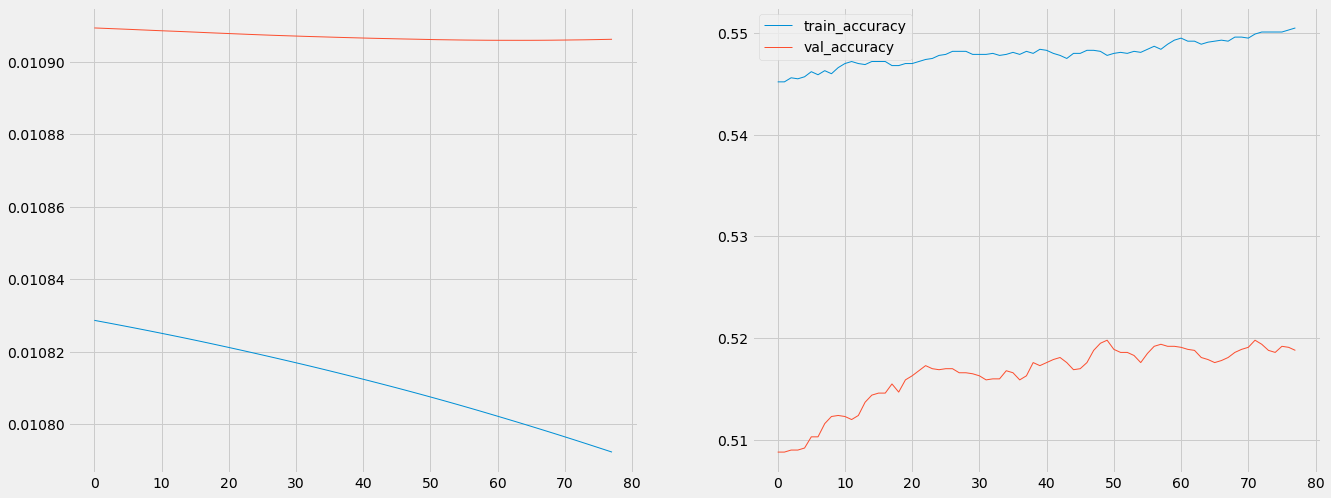

In [264]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, linewidth=1, label='train_loss')
axs[0].plot(val_losses, linewidth=1, label='val_loss')

axs[1].plot(train_accuracies, linewidth=1, label='train_accuracy')
axs[1].plot(val_accuracies, linewidth=1, label='val_accuracy')
plt.legend()
plt.show()

In [279]:
# preds_train1 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()[0]
preds_test1 = net(torch.tensor(X_test1_scaled).float()).detach().numpy()

preds = pd.DataFrame({'probs':preds_test1[:, 0], 'target':cover_test1})

print(preds_test1.shape, cover_test1.shape)
preds['prediction'] = np.round(preds['probs'])
preds['bet_won'] = (preds['prediction'] == preds['target']).astype(int)
preds_test1 = np.concatenate([np.zeros_like(preds_test1), preds_test1], axis=1) 

nn_betting_df = create_betting_df(full_df_combined, preds_test1, test_idx1, 1)
# t = 0.504
# select_bets = nn_betting_df.loc[~nn_betting_df['prob_avg'].between(1-t, t)]
# print(select_bets['bet_won'].mean())
# simulate_bets(select_bets)
# # betting_df

# select_bets, thresholds = find_optimal_threshold(full_df_diffs, preds_test1, test_idx2)
# simulate_bets(select_bets)
# preds

# select_bets
# nn_betting_df
nn_betting_df['bet_won'].mean()

(6924, 1) (6924,)


0.5184864240323512

### Bet Functions

In [482]:
def simulate_bets_1(selected_bets, unit_size):
    """This function simulates betting unit_size of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(-20, 350)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

def simulate_bets_2(selected_bets, unit_pct=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_pct
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(20, 600)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_3(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            bet_size = 5
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            bet_size = 4
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            bet_size = 3
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            bet_size = 2
        else:
            bet_size = 1
            
        selected_bets.at[idx, 'bet_size'] = bet_size
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(15, 200)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_4(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        if abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.04:
            pct = .05
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.03:
            pct = .04
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.02:
            pct = .03
        elif abs(selected_bets.at[idx, 'prob_avg']-0.5) > 0.01:
            pct = .02
        else:
            pct = .01
            
        selected_bets.at[idx, 'bet_size'] = selected_bets.at[idx, 'bankroll_i'] * pct
        if selected_bets.at[idx, 'bet_won'] == 1:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.at[idx, 'bet_won'] == 0:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i'] - selected_bets.at[idx, 'bet_size']
        else:
            selected_bets.at[idx, 'bankroll_n'] = selected_bets.at[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    ax.set_ylim(15, 200)
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets


def simulate_bets_kelly(selected_bets):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 100
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']
        
        b = 1/1.1
        if selected_bets.loc[idx, 'prob_avg'] > 0.5:
            p = selected_bets.loc[idx, 'prob_avg']
        else:
            p = 1 - selected_bets.loc[idx, 'prob_avg']
        q = 1-p
        
        K = (b*p-q)/b
        if K < 0:
            bet_size=0
        else:
            bet_size=selected_bets.loc[idx, 'bankroll_i']*K
            
        
        selected_bets.loc[idx, 'bet_size'] = bet_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    
    amt_won = selected_bets.loc[selected_bets['bet_won'] ==1, 'bet_size'].sum() * 1/1.1
    amt_lost = selected_bets.loc[selected_bets['bet_won']==0, 'bet_size'].sum()
    amt_risked = selected_bets['bet_size'].sum()

    profit = amt_won - amt_lost
    roi = profit/amt_risked
    
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100,
         "\nprofit:", profit, "risk:", amt_risked,
         "\nROI:", round(roi, 4) * 100)
    return selected_bets

In [390]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_17)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_17+1:cutoff_18], cover_test1.loc[cutoff_17+1:cutoff_18]))

stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_17+1:cutoff_18])


0.5435684647302904


TypeError: create_betting_df() missing 1 required positional argument: 'strat_num'

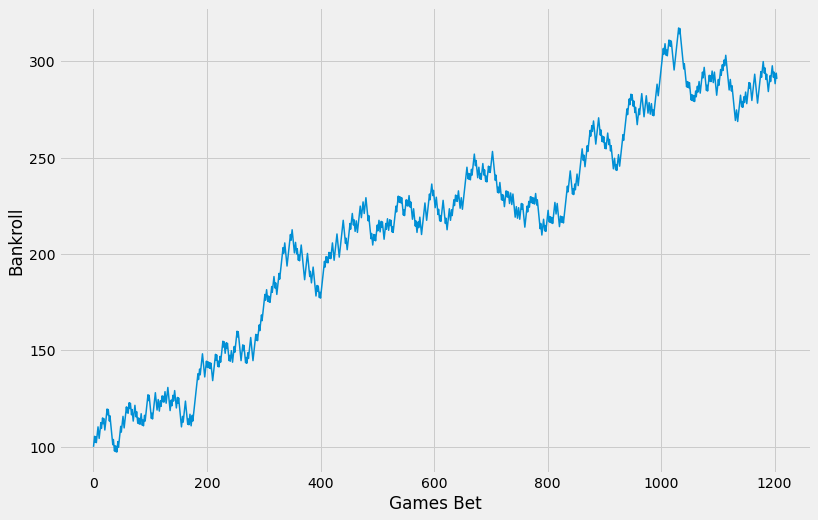

min balance: 97.27272727272741 
max balance: 317.36363636363564 
final balance: 287.90909090909196 
win percentage 55.1


index   GAME_ID MATCHUP_home spread_home team_score_home  \
0         0  21700077  NOP vs. CLE           1              65   
1         1  21700080  MEM vs. HOU          -1              54   
2         2  21700081  DAL vs. PHI         0.5              56   
3         3  21700082  UTA vs. LAL        -6.5              56   
4         4  21700083  POR vs. PHX        -6.5              61   
...     ...       ...          ...         ...             ...   
1200   1200  41700317  HOU vs. GSW           2              54   
1201   1201  41700401  GSW vs. CLE          -7              56   
1202   1202  41700402  GSW vs. CLE          -6              59   
1203   1203  41700403  CLE vs. GSW        -0.5              58   
1204   1204  41700404  CLE vs. GSW         0.5              52   

     team_score_away point_diff_home  cover_home  prob_home  prob_away  \
0                 52              13           1   0.510201   0.487737   
1                 49               5           1   0.509774   0.495129   
2                 57              -1           0   0.507534   0.497644   
3                 45              11           1   0.505493   0.488872   
4                 57               4           0   0.502198   0.495682   
...              ...             ...         ...        ...        ...   
1200              43              11           1   0.496690   0.504013   
1201              56               0           0   0.497732   0.499984   
1202              46              13           1   0.505879   0.493277   
1203              52               6           1   0.498085   0.503937   
1204              61              -9           0   0.507099   0.496980   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.511232          1          1          1  100.000000  102.727273   
1     0.507322          1          1          1  102.727273  105.454545   
2     0.504945          1          1          1  105.454545  102.454545   
3     0.508311          1          1          1  102.454545  105.181818   
4     0.503258          1          1          1  105.181818  102.181818   
...        ...        ...        ...        ...         ...         ...   
1200  0.496338          0          0          0  291.454545  288.454545   
1201  0.498874          0          1          0  288.454545  291.181818   
1202  0.506301          1          1          1  291.181818  293.909091   
1203  0.497074          0          0          0  293.909091  290.909091   
1204  0.505059          1          1          1  290.909091  287.909091   

      bet_size  bet_won  
0          3.0        1  
1          3.0        1  
2          3.0        0  
3          3.0        1  
4          3.0        0  
...        ...      ...  
1200       3.0        0  
1201       3.0        1  
1202       3.0        1  
1203       3.0        0  
1204       3.0        0  

[1205 rows x 18 columns]

In [392]:
stacked_bets_2018 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_17+1:cutoff_18].index, 3)

simulate_bets_1(stacked_bets_2018)

In [431]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_18)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_18+1:cutoff_19], cover_test1.loc[cutoff_18+1:cutoff_19]))


stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_18+1:cutoff_19])

stacked_bets_2019 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_18+1:cutoff_19].index, 3)

simulate_bets_1(stacked_bets_2019)

0.5243801652892562


TypeError: simulate_bets_1() missing 1 required positional argument: 'unit_size'

0.5296084049665711


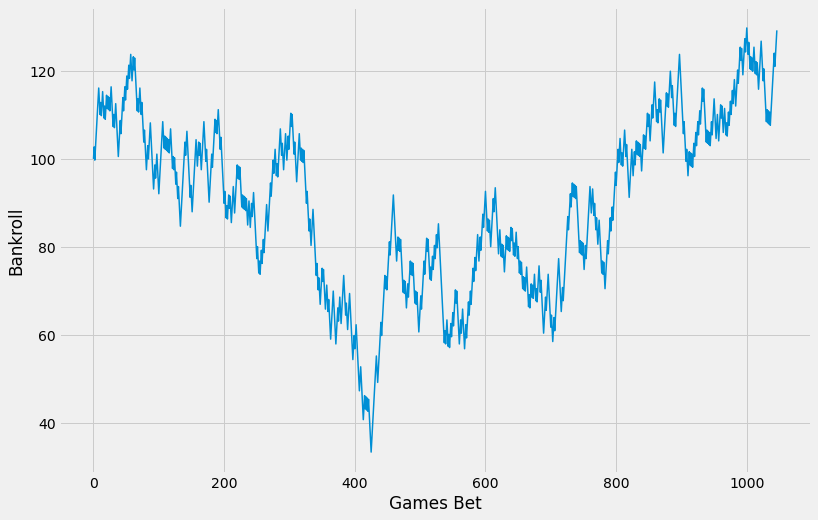

min balance: 33.45454545454671 
max balance: 129.72727272727576 
final balance: 126.18181818182137 
win percentage 52.82


index   GAME_ID MATCHUP_home spread_home team_score_home  \
0         0  21900073  CHI vs. DET        -2.5              57   
1         1  21900075  SAC vs. UTA         1.5              51   
2         2  21900077  OKC vs. NOP          -1              65   
3         3  21900078  DET vs. BKN           2              46   
4         4  21900079  ORL vs. DEN         1.5              45   
...     ...       ...          ...         ...             ...   
1042   1042  41900402  LAL vs. MIA        -6.5              68   
1043   1043  41900403  MIA vs. LAL           6              58   
1044   1044  41900404  MIA vs. LAL           5              47   
1045   1045  41900405  LAL vs. MIA          -4              56   
1046   1046  41900406  MIA vs. LAL         3.5              36   

     team_score_away point_diff_home  cover_home  prob_home  prob_away  \
0                 52               5           1   0.515416   0.467708   
1                 48               3           1   0.479526   0.530196   
2                 60               5           1   0.515247   0.479080   
3                 54              -8           0   0.496346   0.508690   
4                 40               5           1   0.523670   0.482219   
...              ...             ...         ...        ...        ...   
1042              54              14           1   0.494639   0.500903   
1043              54               4           1   0.507937   0.490023   
1044              49              -2           1   0.511147   0.496903   
1045              60              -4           0   0.493468   0.507722   
1046              64             -28           0   0.506280   0.497665   

      prob_avg  bet_home1  bet_home2  bet_home3  bankroll_i  bankroll_n  \
0     0.523854          1          1          1  100.000000  102.727273   
1     0.474665          0          0          0  102.727273   99.727273   
2     0.518084          1          1          1   99.727273  102.454545   
3     0.493828          0          0          0  102.454545  105.181818   
4     0.520725          1          1          1  105.181818  107.909091   
...        ...        ...        ...        ...         ...         ...   
1042  0.496868          0          0          0  124.000000  121.000000   
1043  0.508957          1          1          1  121.000000  123.727273   
1044  0.507122          1          1          1  123.727273  126.454545   
1045  0.492873          0          0          0  126.454545  129.181818   
1046  0.504308          1          1          1  129.181818  126.181818   

      bet_size  bet_won  
0          3.0        1  
1          3.0        0  
2          3.0        1  
3          3.0        1  
4          3.0        1  
...        ...      ...  
1042       3.0        0  
1043       3.0        1  
1044       3.0        1  
1045       3.0        1  
1046       3.0        0  

[1047 rows x 18 columns]

In [394]:
X_train1, X_test1, cover_train1, cover_test1, train_idx1, test_idx1 = split_prep_data(full_df_combined, cutoff_19)

stacked_clf.fit(X_train1, cover_train1)

print(stacked_clf.score(X_test1.loc[cutoff_19+1:cutoff_20], cover_test1.loc[cutoff_19+1:cutoff_20]))


stacked_probs = stacked_clf.predict_proba(X_test1.loc[cutoff_19+1:cutoff_20])

stacked_bets_2020 = create_betting_df(full_df_combined, stacked_probs, X_test1.loc[cutoff_19+1:cutoff_20].index, 3)

simulate_bets_1(stacked_bets_2020)

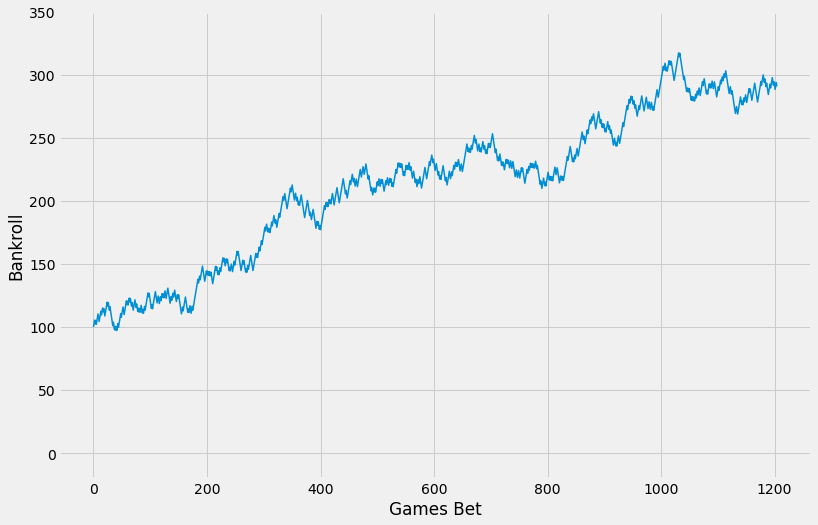

min balance: 97.27272727272741 
max balance: 317.36363636363564 
final balance: 287.90909090909196 
win percentage 55.1 
profit: 187.90909090909076 risk: 3615.0 
ROI: 5.2


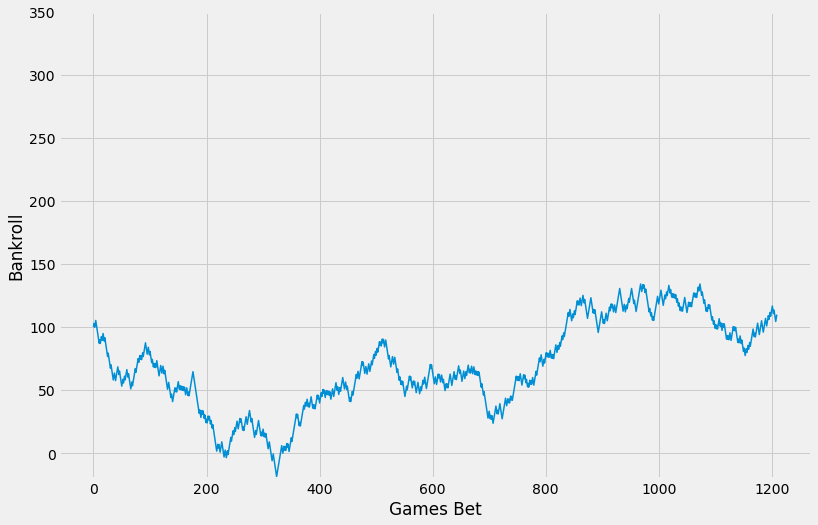

min balance: -18.636363636363413 
max balance: 134.0909090909104 
final balance: 106.81818181818356 
win percentage 52.480000000000004 
profit: 6.818181818181756 risk: 3630.0 
ROI: 0.19


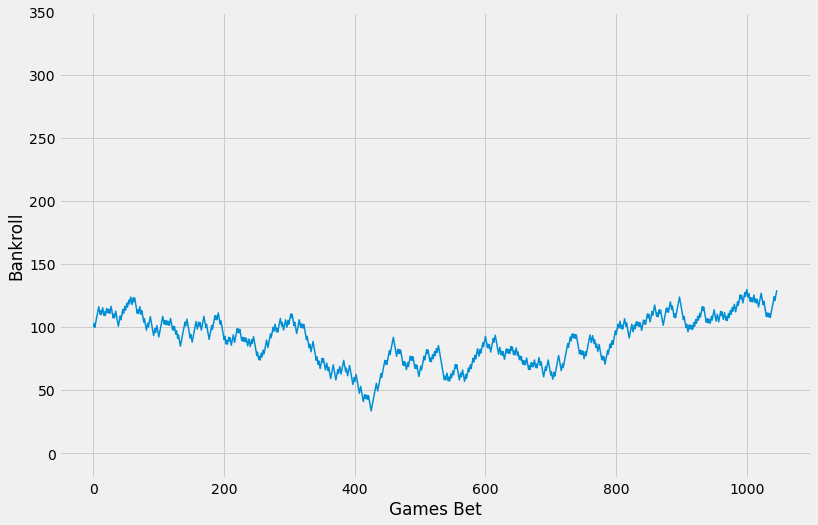

min balance: 33.45454545454671 
max balance: 129.72727272727576 
final balance: 126.18181818182137 
win percentage 52.82 
profit: 26.181818181818016 risk: 3141.0 
ROI: 0.83


(      index   GAME_ID MATCHUP_home spread_home team_score_home  \
 0         0  21700077  NOP vs. CLE           1              65   
 1         1  21700080  MEM vs. HOU          -1              54   
 2         2  21700081  DAL vs. PHI         0.5              56   
 3         3  21700082  UTA vs. LAL        -6.5              56   
 4         4  21700083  POR vs. PHX        -6.5              61   
 ...     ...       ...          ...         ...             ...   
 1200   1200  41700317  HOU vs. GSW           2              54   
 1201   1201  41700401  GSW vs. CLE          -7              56   
 1202   1202  41700402  GSW vs. CLE          -6              59   
 1203   1203  41700403  CLE vs. GSW        -0.5              58   
 1204   1204  41700404  CLE vs. GSW         0.5              52   
 
      team_score_away point_diff_home  cover_home  prob_home  prob_away  \
 0                 52              13           1   0.510201   0.487737   
 1                 49               5       

In [475]:
simulate_bets_1(stacked_bets_2018, 3), simulate_bets_1(stacked_bets_2019, 3), simulate_bets_1(stacked_bets_2020, 3)

### Percentage of Bankroll

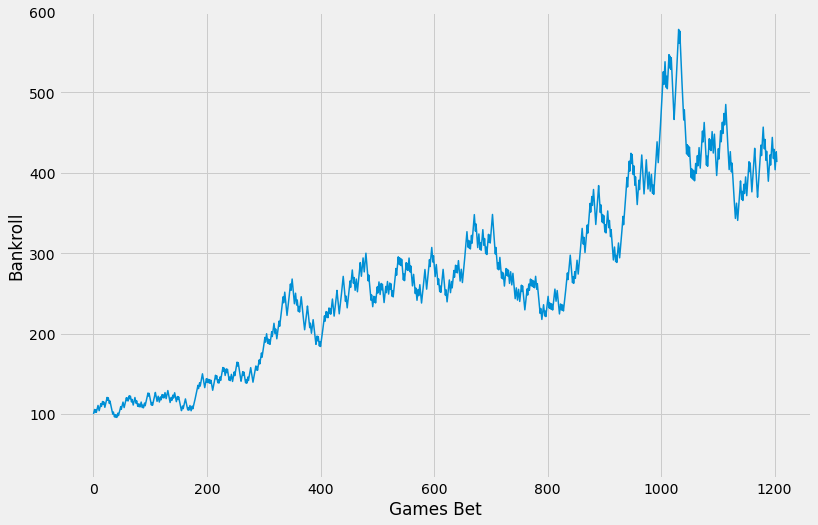

min balance: 95.68318212190407 
max balance: 578.0480421537792 
final balance: 400.72991655667664 
win percentage 55.1 
profit: 300.72991655667647 risk: 9662.178087305165 
ROI: 3.11


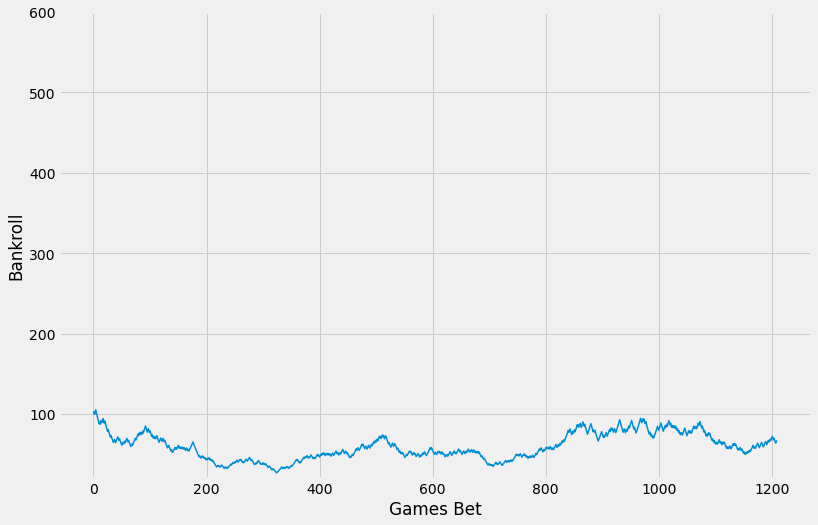

min balance: 26.682805287618105 
max balance: 105.15477761081894 
final balance: 65.19341627342773 
win percentage 52.480000000000004 
profit: -34.806583726572285 risk: 2159.6743823766155 
ROI: -1.6099999999999999


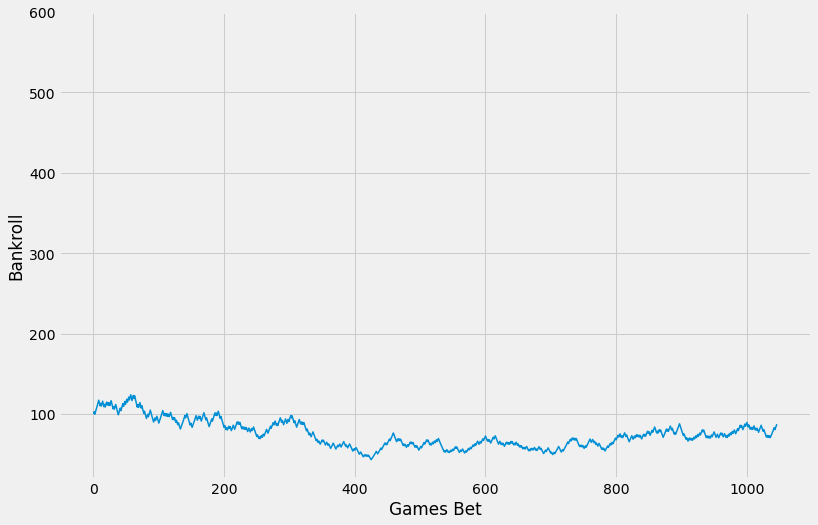

min balance: 43.136622675874555 
max balance: 123.89839234376545 
final balance: 84.61767365625646 
win percentage 52.82 
profit: -15.38232634374367 risk: 2351.30389105035 
ROI: -0.65


In [476]:
bets_2_18, bets2_19, bets_2_20 = simulate_bets_2(stacked_bets_2018, 0.03), simulate_bets_2(stacked_bets_2019, 0.03), simulate_bets_2(stacked_bets_2020, 0.03)

### Bet Size Based on Confidence Thresholds

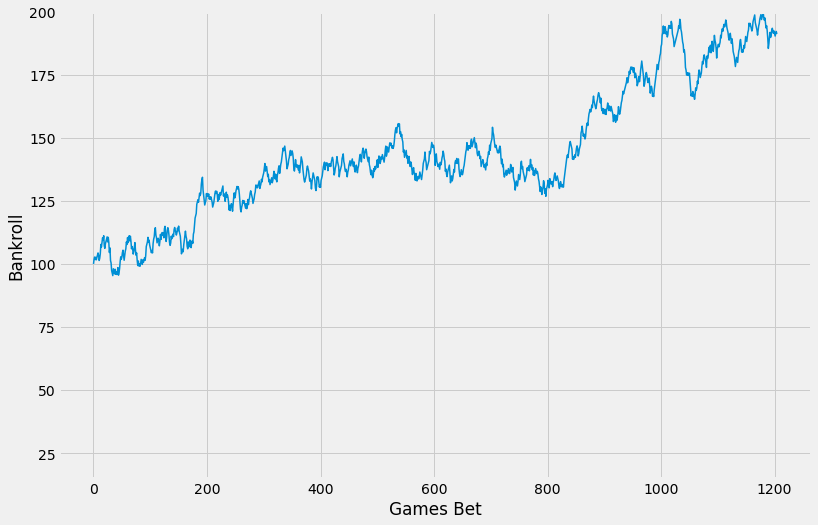

min balance: 95.3636363636363 
max balance: 199.6363636363612 
final balance: 190.18181818181571 
win percentage 55.1 
profit: 90.18181818181813 risk: 2027.0 
ROI: 4.45


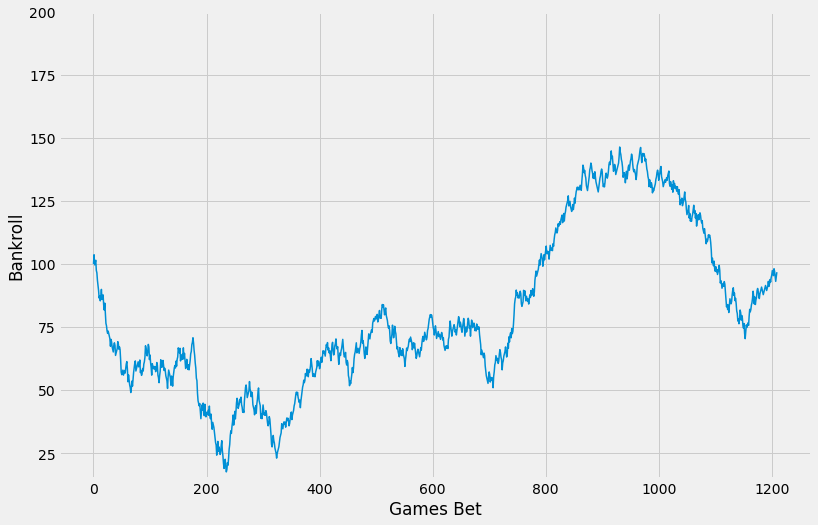

min balance: 17.545454545454493 
max balance: 146.36363636363566 
final balance: 95.72727272727158 
win percentage 52.480000000000004 
profit: -4.272727272727252 risk: 2320.0 
ROI: -0.18


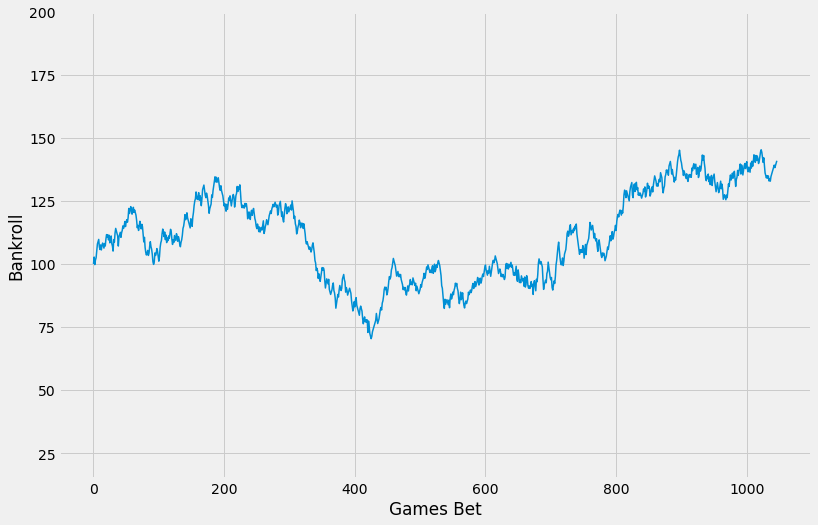

min balance: 70.3636363636359 
max balance: 145.27272727272583 
final balance: 139.90909090908943 
win percentage 52.82 
profit: 39.90909090909088 risk: 1915.0 
ROI: 2.08


In [477]:
bets3_18, bets3_19, bets3_20 = simulate_bets_3(stacked_bets_2018), simulate_bets_3(stacked_bets_2019), simulate_bets_3(stacked_bets_2020)

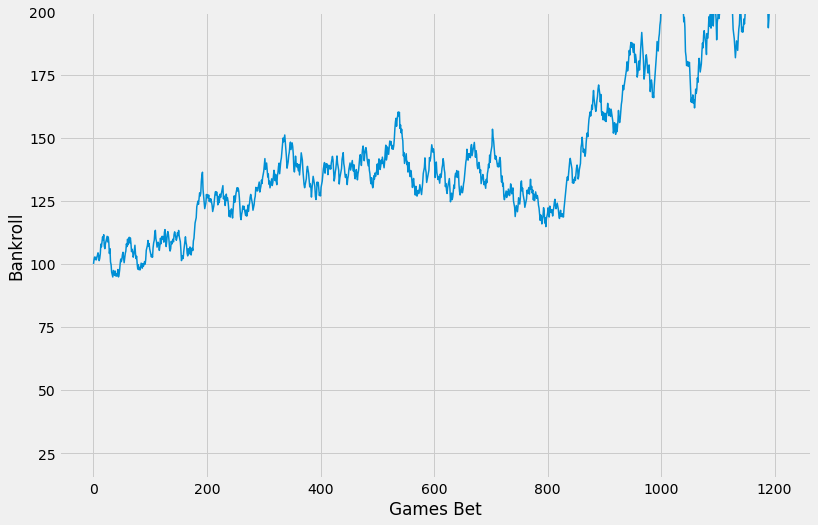

min balance: 94.82444140360094 
max balance: 223.6393935793457 
final balance: 202.69444196196258 
win percentage 55.1 
profit: 102.69444196196196 risk: 2935.2132827214677 
ROI: 3.5000000000000004


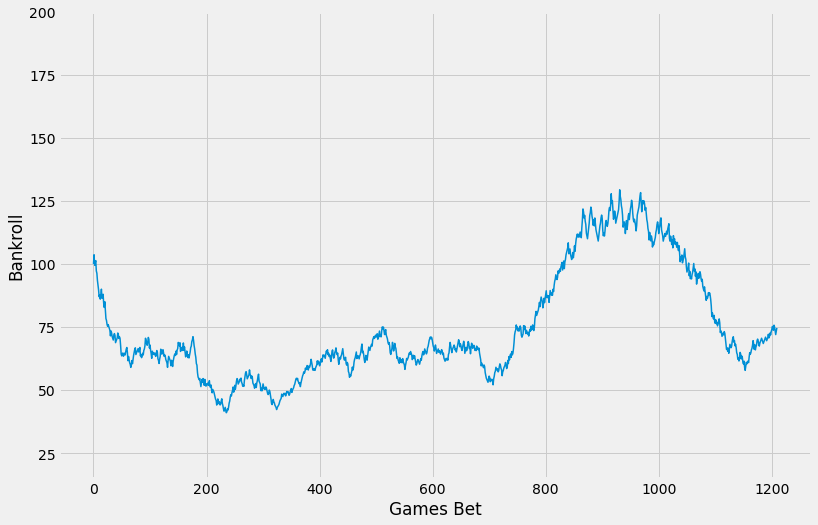

min balance: 41.00270893131908 
max balance: 129.39167068143553 
final balance: 73.88156950169045 
win percentage 52.480000000000004 
profit: -26.11843049830952 risk: 1704.595516493269 
ROI: -1.53


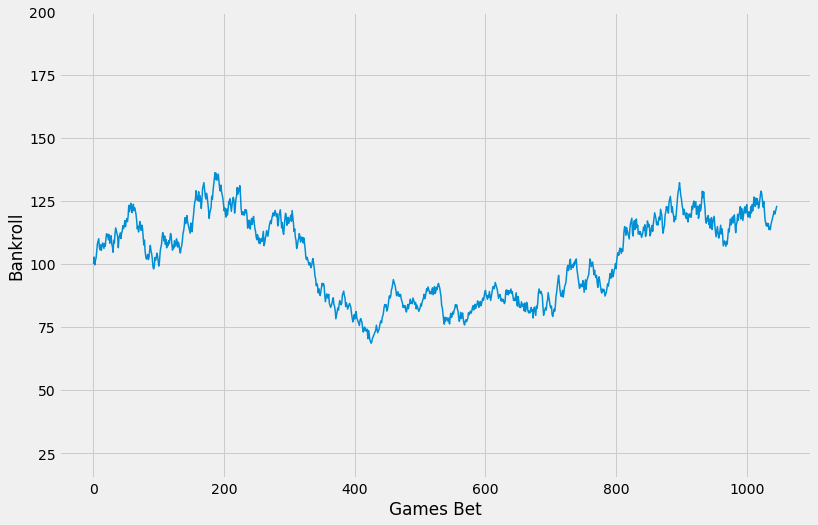

min balance: 68.55640194393014 
max balance: 136.19004965654736 
final balance: 121.83859492388021 
win percentage 52.82 
profit: 21.838594923879896 risk: 1968.875210016487 
ROI: 1.11


In [484]:
bets4_18, bets4_19, bets4_20 = simulate_bets_4(stacked_bets_2018), simulate_bets_4(stacked_bets_2019), simulate_bets_4(stacked_bets_2020)

In [303]:
thresholds

index  strategy  confidence_range  num_games_bet  win_percentage  \
0       2         1             0.503            483        0.542443   
1       1         1             0.502            658        0.534954   
2       3         1             0.504            328        0.548780   
3    1002         3             0.505            161        0.571429   
4     999         3             0.502            599        0.532554   
5       4         1             0.505            213        0.553991   
6    1001         3             0.504            260        0.542308   
7    1000         3             0.503            416        0.531250   
8     998         3             0.501            808        0.524752   
9     504         2             0.506            115        0.556522   
10    505         2             0.507             70        0.571429   
11    503         2             0.505            204        0.534314   
12    502         2             0.504            339        0.525074   
13   1005         3             0.508             12        0.666667   
14    506         2             0.508             38        0.552632   
15      5         1             0.506            125        0.528000   
16   1006         3             0.509              2        1.000000   
17    511         2             0.513              1        1.000000   
18    510         2             0.512              1        1.000000   
19    509         2             0.511              3        0.666667   
20    508         2             0.510              7        0.571429   
21      8         1             0.509             19        0.526316   

    expected_profit  
0              2332  
1              2152  
2              2016  
3              1748  
4              1660  
5              1540  
6              1248  
7              1040  
8               928  
9               892  
10              760  
11              640  
12              412  
13              368  
14              264  
15              228  
16              200  
17              100  
18              100  
19               92  
20               76  
21               28

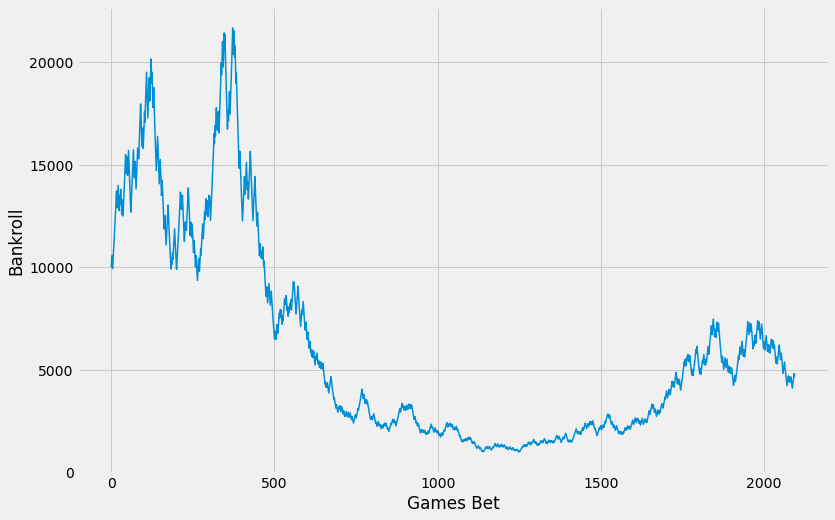

min balance: 971.9576200531907 
max balance: 21674.257240678697 
final balance: 4524.910257240836 
win percentage 52.44


index     preds  target  prediction  bet_won    bankroll_i    bet_size  \
0     29680  0.508200       1         1.0        1  10000.000000  300.000000   
1     29681  0.481677       0         0.0        1  10272.727273  308.181818   
2     29682  0.484904       1         0.0        0  10552.892562  316.586777   
3     29683  0.510528       0         1.0        0  10236.305785  307.089174   
4     29684  0.503367       1         1.0        1   9929.216612  297.876498   
...     ...       ...     ...         ...      ...           ...         ...   
2089  31769  0.487238       0         0.0        1   4436.180686  133.085421   
2090  31770  0.491201       0         0.0        1   4557.167432  136.715023   
2091  31771  0.508352       1         1.0        1   4681.453817  140.443615   
2092  31772  0.508180       0         1.0        0   4809.129830  144.273895   
2093  31773  0.493015       1         0.0        0   4664.855935  139.945678   

        bankroll_n  
0     10272.727273  
1     10552.892562  
2     10236.305785  
3      9929.216612  
4     10200.013428  
...            ...  
2089   4557.167432  
2090   4681.453817  
2091   4809.129830  
2092   4664.855935  
2093   4524.910257  

[2094 rows x 8 columns]

In [192]:
preds_train2 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()[0]
preds_test2 = net(torch.tensor(X_test2_scaled).float()).detach().numpy()[:, 0]

preds = pd.DataFrame({'preds':preds_test2, 'target':cover_test2})

preds_test1.shape, cover_test1.shape
preds['prediction'] = np.round(preds['preds'])
preds['bet_won'] = (preds['prediction'] == preds['target']).astype(int)
preds['bet_won'].mean()

simulate_bets(preds)
# preds

In [181]:
cover_test2.shape

(6924,)

In [217]:
net = Net()

learning_rate = 0.000005
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 160

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader2:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

#         n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#         train_correct_preds += n_correct_preds
#         train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train2.shape[0])
#     train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader2):
            target = target.reshape(-1, 1)
            outputs = net(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
#             n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
#             val_correct_preds += n_correct_preds
#             val_total_preds += outputs.shape[0]

#         val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test2.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train2.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test2.shape[0]))


Epoch: 0/160..  Training Loss: 5.806562..  Test Loss: 6.386216.. 
Epoch: 10/160..  Training Loss: 5.221600..  Test Loss: 5.761154.. 
Epoch: 20/160..  Training Loss: 4.836733..  Test Loss: 5.370768.. 
Epoch: 30/160..  Training Loss: 4.779824..  Test Loss: 5.300383.. 
Epoch: 40/160..  Training Loss: 4.698755..  Test Loss: 5.242830.. 
Epoch: 50/160..  Training Loss: 4.632791..  Test Loss: 5.191969.. 
Epoch: 60/160..  Training Loss: 4.594651..  Test Loss: 5.150405.. 
Epoch: 70/160..  Training Loss: 4.547083..  Test Loss: 5.117874.. 
Epoch: 80/160..  Training Loss: 4.509670..  Test Loss: 5.097426.. 
Epoch: 90/160..  Training Loss: 4.496081..  Test Loss: 5.084373.. 
Epoch: 100/160..  Training Loss: 4.461044..  Test Loss: 5.077161.. 
Epoch: 110/160..  Training Loss: 4.447700..  Test Loss: 5.073328.. 
Epoch: 120/160..  Training Loss: 4.429356..  Test Loss: 5.069898.. 
Epoch: 130/160..  Training Loss: 4.428498..  Test Loss: 5.068149.. 
Epoch: 140/160..  Training Loss: 4.414505..  Test Loss: 5.0

In [218]:
preds_train2 = net(torch.tensor(X_train2_scaled).float()).detach().numpy()
preds_test2 = net(torch.tensor(X_test2_scaled).float()).detach().numpy()

mae_diff_train: 9.165797430162671 mae_diff_test: 9.885434602811353
Train Betting Overall Accuracy: 0.5407401524777636
Test Betting Overall Accuracy: 0.5099648300117233


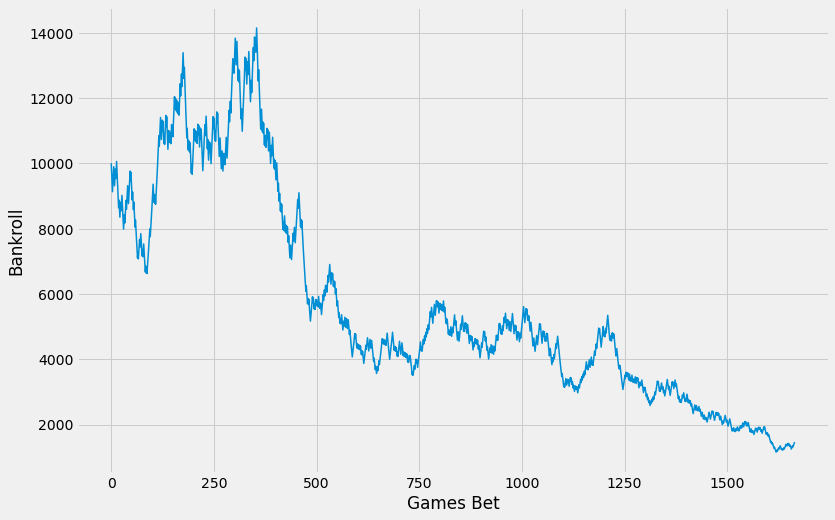

min balance: 1155.4883030792748 
max balance: 14142.122593625492 
final balance: 1502.3531346025138 
win percentage 51.11


index   GAME_ID MATCHUP_home  spread_home   ml_home   ml_away  \
0         0  21700077  NOP vs. CLE          2.5  2.150000  1.740741   
1         1  21700080  MEM vs. HOU         -2.0  1.800000  2.050000   
2         2  21700081  DAL vs. PHI          1.0  2.000000  1.833333   
3         4  21700083  POR vs. PHX        -12.0  1.133333  6.000000   
4         6  21700086  IND vs. SAS          6.5  3.110000  1.357143   
...     ...       ...          ...          ...       ...       ...   
1660   3485  41900304  MIA vs. BOS          3.5  2.380000  1.588235   
1661   3489  41900306  MIA vs. BOS          3.0  2.200000  1.714286   
1662   3491  41900402  LAL vs. MIA        -11.0  1.157480  4.930000   
1663   3492  41900403  MIA vs. LAL          9.5  4.300000  1.210526   
1664   3493  41900404  MIA vs. LAL          7.5  3.520000  1.273973   

      team_score_home  team_score_away  point_diff_home  cover_home  \
0                 123              101               22           1   
1                 103               89               14           1   
2                 110              112               -2           0   
3                 114              107                7           0   
4                  97               94                3           1   
...               ...              ...              ...         ...   
1660              112              109                3           1   
1661              125              113               12           1   
1662              124              114               10           0   
1663              115              104               11           1   
1664               96              102               -6           1   

      diff_preds_home  diff_preds_away  point_diff_avg  bet_home1  bet_home2  \
0           -6.313794         6.844114       -6.578954          0          0   
1           -1.591051         1.323781       -1.457416          0          0   
2           -0.577614        -3.686752        1.554569          1          1   
3            9.790244        -9.372024        9.581134          0          0   
4           -3.780788         2.469774       -3.125281          1          1   
...               ...              ...             ...        ...        ...   
1660        -1.046955        -0.073273       -0.486841          1          1   
1661        -1.202846         0.949766       -1.076306          1          1   
1662         7.784851        -8.259991        8.022421          0          0   
1663        -7.161108         6.006633       -6.583870          1          1   
1664        -6.400207         5.461344       -5.930775          1          1   

      bet_home3  confidence_pred1  confidence_pred2  confidence_pred3  \
0             0         -3.813794         -4.344114         -4.078954   
1             0         -3.591051         -3.323781         -3.457416   
2             1          0.422386          4.686752          2.554569   
3             0         -2.209756         -2.627976         -2.418866   
4             1          2.719212          4.030226          3.374719   
...         ...               ...               ...               ...   
1660          1          2.453045          3.573273          3.013159   
1661          1          1.797154          2.050234          1.923694   
1662          0         -3.215149         -2.740009         -2.977579   
1663          1          2.338892          3.493367          2.916130   
1664          1          1.099793          2.038656          1.569225   

        bankroll_i   bankroll_n    bet_size  bet_won  
0     10000.000000  9700.000000  300.000000        0  
1      9700.000000  9409.000000  291.000000        0  
2      9409.000000  9126.730000  282.270000        0  
3      9126.730000  9375.640818  273.801900        1  
4      9375.640818  9631.340113  281.269225        1  
...            ...          ...         ...      ...  
1660   1313.237380  1349.052944   39.397121        1  
1661   1349.052944  13

In [220]:
mae_diff_train = mean_absolute_error(point_diff_train2, preds_train2)
mae_diff_test = mean_absolute_error(point_diff_test2, preds_test2)

print("mae_diff_train:", mae_diff_train, "mae_diff_test:", mae_diff_test)


bets_train = create_betting_df(df_19, preds_train2, train_idx2, 3)
print("Train Betting Overall Accuracy:", bets_train['bet_won'].mean())


bets_test = create_betting_df(df_19, preds_test2, test_idx2, 3)
print("Test Betting Overall Accuracy:", bets_test['bet_won'].mean())


bets = create_betting_df(df_19, preds_test2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 1.47]    
simulate_bets(select_bets)


In [224]:
df_19.loc[test_idx2]

SEASON_YEAR_x  SEASON_ID_x   TEAM_ID_x TEAM_ABBREVIATION_x  \
25627       2017-18        22017  1610612739                 CLE   
25628       2017-18        22017  1610612740                 NOP   
25629       2017-18        22017  1610612745                 HOU   
25630       2017-18        22017  1610612763                 MEM   
25631       2017-18        22017  1610612742                 DAL   
...             ...          ...         ...                 ...   
32614       2019-20        42019  1610612748                 MIA   
32615       2019-20        42019  1610612747                 LAL   
32616       2019-20        42019  1610612748                 MIA   
32617       2019-20        42019  1610612747                 LAL   
32618       2019-20        42019  1610612748                 MIA   

                TEAM_NAME_x   GAME_ID GAME_DATE_x    MATCHUP_x  HOME_GAME_x  \
25627   Cleveland Cavaliers  21700077  2017-10-28    CLE @ NOP            0   
25628  New Orleans Pelicans  21700077  2017-10-28  NOP vs. CLE            1   
25629       Houston Rockets  21700080  2017-10-28    HOU @ MEM            0   
25630     Memphis Grizzlies  21700080  2017-10-28  MEM vs. HOU            1   
25631      Dallas Mavericks  21700081  2017-10-28  DAL vs. PHI            1   
...                     ...       ...         ...          ...          ...   
32614            Miami Heat  41900404  2020-10-06  MIA vs. LAL            1   
32615    Los Angeles Lakers  41900405  2020-10-09  LAL vs. MIA            1   
32616            Miami Heat  41900405  2020-10-09    MIA @ LAL            0   
32617    Los Angeles Lakers  41900406  2020-10-11    LAL @ MIA            0   
32618            Miami Heat  41900406  2020-10-11  MIA vs. LAL            1   

       SCORE_team_x  point_diff_team_x  WL_team_x  ml_team_x  spread_team_x  \
25627           101                -22          0   1.740741           -2.5   
25628           123                 22          1   2.150000            2.5   
25629            89                -14          0   2.050000            2.0   
25630           103                 14          1   1.800000           -2.0   
25631           110                 -2          0   2.000000            1.0   
...             ...                ...        ...        ...            ...   
32614            96                 -6          0   3.520000            7.5   
32615           108                 -3          0   1.289855           -7.5   
32616           111                  3          1   3.070000            7.5   
32617           106                 13          1   1.400000           -5.5   
32618            93                -13          0   3.100000            5.5   

       team_covered_team_x  RECORD_team_x  FG2M_team_x  FG2A_team_x  \
25627             0.178018       0.558008    28.831604    52.752582   
25628             0.620009       0.441992    27.862885    53.072550   
25629             0.495026       0.827130    23.330206    37.456167   
25630             0.536031       0.780225    23.483431    47.220898   
25631             0.405499       0.192078    22.757922    52.901191   
...                    ...            ...          ...          ...   
32614             0.667870       0.587760    26.009318    46.942907   
32615             0.411075       0.751238    28.137884    48.969500   
32616             0.701085       0.528980    25.508355    46.548592   
32617             0.369965       0.676109    27.724067    48.472516   
32618             0.730978       0.576085    25.357512    46.893752   

       FG3M_team_x  FG3A_team_x  FTM_team_x  FTA_team_x  OREB_team_x  \
25627    10.590584    29.996386   18.234256   23.556323     9.175820   
25628    11.100266    31.151010   18.730287   25.365657     9.919562   
25629    13.838076    45.005557   17.539535   21.238352     8.579517   
25630     9.488144    28.326512   24.316525   30.991624     7.581134   
25631    11.508141    32.378494   17.439494   23.879040    10.389110   
...   

In [227]:
test = df_19.loc[test_idx2]
(abs(test['spread_team_x'] + test['point_diff_team_x'])).mean()

9.767019450800916

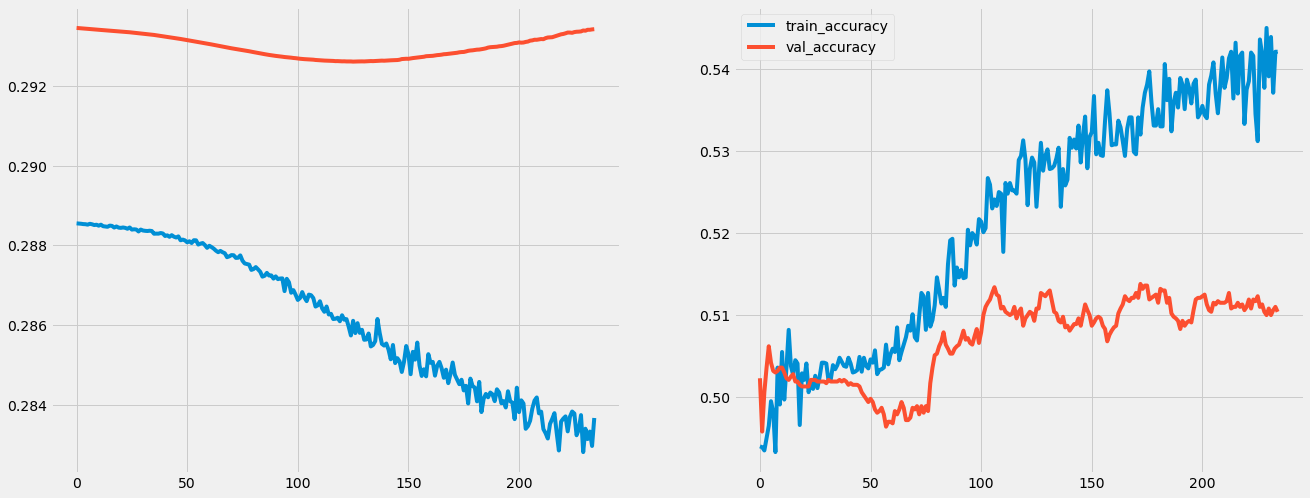

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')

axs[1].plot(train_accuracies, label='train_accuracy')
axs[1].plot(val_accuracies, label='val_accuracy')
plt.legend()
plt.show()

In [482]:
net2 =Net()

learning_rate = 0.000001
def my_loss(output, target):
    residual = (output-target).float()
    choicelist = [torch.where(output<=0, residual**2, 3*residual**2), torch.where(output<=0, 3*residual**2, residual**2)]
    loss = torch.where(target<=0, choicelist[0], choicelist[1])
#     loss = -torch.log(torch.sigmoid((torch.sign(target) * torch.clamp((output - target), -20, 20))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net2.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net2.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net2(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net2.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = net2(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 20 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 4.285663..  Test Loss: 4.377806..  Training Accuracy 0.510.. Validation Accuracy 0.503..
Epoch: 21/500..  Training Loss: 4.285192..  Test Loss: 4.377680..  Training Accuracy 0.512.. Validation Accuracy 0.501..
Epoch: 41/500..  Training Loss: 4.284325..  Test Loss: 4.377541..  Training Accuracy 0.509.. Validation Accuracy 0.503..
Epoch: 61/500..  Training Loss: 4.282853..  Test Loss: 4.377401..  Training Accuracy 0.517.. Validation Accuracy 0.502..
Epoch: 81/500..  Training Loss: 4.284114..  Test Loss: 4.377295..  Training Accuracy 0.510.. Validation Accuracy 0.501..
Epoch: 101/500..  Training Loss: 4.283797..  Test Loss: 4.377206..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 121/500..  Training Loss: 4.282302..  Test Loss: 4.377129..  Training Accuracy 0.512.. Validation Accuracy 0.500..
Epoch: 141/500..  Training Loss: 4.282051..  Test Loss: 4.377056..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 161/500..  Training Los

KeyboardInterrupt: 

In [493]:
train_outputs = np.array([])
train_outputs2 = np.array([])
train_targets = np.array([])
for data, target in train_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    train_outputs = np.concatenate([train_outputs, outputs.detach().numpy().flatten()])
    train_outputs2 = np.concatenate([train_outputs2, outputs2.detach().numpy().flatten()])

    train_targets = np.concatenate([train_targets, target.detach().numpy().flatten()])
# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
train_preds = pd.DataFrame({'preds':train_outputs, 'preds2':train_outputs2, 'target':train_targets})
# test_outputs.detach().numpy().flatten()
train_preds

preds    preds2  target
0     -1.569377 -0.411728     4.5
1      2.848549 -0.101551    -1.5
2     -0.019031 -0.067838     3.5
3      2.170247 -0.185665   -19.5
4     -3.343860 -0.671299   -10.0
...         ...       ...     ...
11767  0.601759  0.044105    28.5
11768  0.989692  0.048848   -13.5
11769  1.633067  0.119707   -20.5
11770  2.350058  0.031689    12.0
11771  0.950963 -0.028231    -9.0

[11772 rows x 3 columns]

In [481]:
train_preds['preds2'].describe()

count    11772.000000
mean        -0.051085
std          0.081908
min         -0.467047
25%         -0.102110
50%         -0.046459
75%          0.006428
max          0.208395
Name: preds2, dtype: float64

In [465]:
y_pred = net(data.float())

preds_df = pd.DataFrame({"y_true":target.detach().numpy().flatten(), "y_pred":y_pred.detach().numpy().flatten()})
preds_df

y_true    y_pred
0     -1.0 -0.362796
1      2.5  0.376909
2    -11.5  0.066797
3      3.0  0.101686
4     -9.5  0.647189
5     13.0  0.814767
6      8.5  0.058365
7     23.0  0.676957
8    -14.0  0.330269
9     20.0  1.236707
10    18.0  0.169000
11     7.5  1.259727
12    21.0  0.347002
13    30.0  0.505747
14    12.0  0.476720
15    25.5  0.541051
16    27.0  0.543965
17     1.5  0.216480
18   -19.5 -2.233496
19   -10.5 -1.027346
20     1.0  1.092786
21     9.0  0.106447
22    27.0  1.016205
23    28.5 -0.454392
24   -13.5  0.548404
25   -20.5  0.498868
26    12.0  1.003339
27    -9.0 -0.123695

In [494]:
test_outputs = np.array([])
test_outputs2 = np.array([])

for data, target in val_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])
    test_outputs2 = np.concatenate([test_outputs2, outputs2.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'preds2':test_outputs2, 'target':spread_point_diff_test_ewm_19})
# test_outputs.detach().numpy().flatten()

In [495]:
preds['bet_won'] = (np.sign(preds['preds']) == np.sign(preds['target'])).astype(int)
print(preds['bet_won'].mean())
preds['pred_probs'] = 1 / (1 + np.exp(-preds['preds']/10))
preds['pred_scaled'] = preds['preds']*10
preds['bet_home'] = (preds['preds'] > 0).astype(int)

0.5010620220900595


In [496]:
preds


preds    preds2  target  bet_won  pred_probs  pred_scaled  bet_home
11772  3.245110  0.129812   -10.5        0    0.580423    32.451100         1
11773 -5.352964 -0.005315    31.5        0    0.369282   -53.529644         0
11774 -0.912930 -0.088472    -3.5        1    0.477193    -9.129300         0
11775  2.345120  0.156321    13.5        1    0.558361    23.451197         1
11776 -0.504047 -0.434542    12.0        0    0.487401    -5.040472         0
...         ...       ...     ...      ...         ...          ...       ...
16475  3.186399  0.029901    -1.0        0    0.578993    31.863995         1
16476  1.176630  0.109124    20.5        1    0.529382    11.766295         1
16477  0.970830  0.048862     1.5        1    0.524252     9.708300         1
16478  1.041771  0.114306   -10.5        0    0.526021    10.417712         1
16479 -0.220044  0.011262    -7.5        1    0.494499    -2.200444         0

[4708 rows x 7 columns]

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.32
num_games_bet: 1623
win percetange at threshold: 0.5465187923598275


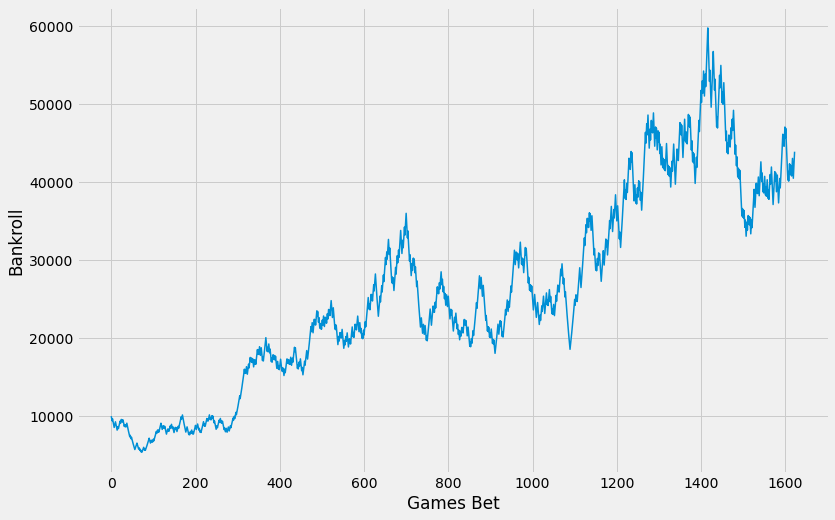

min balance: 5394.227702928191 
max balance: 59766.325969626225 
final balance: 42585.72589427221 
win percentage 54.65


index            GAME_DATE  spread  point_diff_team  confidence_preds  \
0     11772  2016-11-04 00:00:00     3.5            -14.0          3.245110   
1     11773  2016-11-04 00:00:00    11.5             20.0         -5.352964   
2     11775  2016-11-05 00:00:00    -3.5             17.0          2.345120   
3     11778  2016-11-05 00:00:00    -4.5            -24.0          2.687921   
4     11785  2016-11-07 00:00:00    -5.5             12.0         -6.921419   
...     ...                  ...     ...              ...               ...   
1618  16446  2020-09-04 00:00:00    -5.5            -15.0          3.672901   
1619  16448  2020-09-05 00:00:00    -9.0             -9.0         -4.396315   
1620  16450  2020-09-06 00:00:00    -6.0              8.0          2.686229   
1621  16464  2020-09-17 00:00:00    -3.0             -5.0         -4.081581   
1622  16475  2020-10-02 00:00:00   -11.0             10.0          3.186399   

      home_cover  bet_home  bet_won    bankroll_i    bankroll_n     bet_size  
0            0.0         1        0  10000.000000   9700.000000   300.000000  
1            1.0         0        0   9700.000000   9409.000000   291.000000  
2            1.0         1        1   9409.000000   9665.609091   282.270000  
3            0.0         1        0   9665.609091   9375.640818   289.968273  
4            1.0         0        0   9375.640818   9094.371594   281.269225  
...          ...       ...      ...           ...           ...          ...  
1618         0.0         1        0  41750.656697  40498.136996  1252.519701  
1619         0.0         0        1  40498.136996  41602.631641  1214.944110  
1620         1.0         1        1  41602.631641  42737.248868  1248.078949  
1621         0.0         0        1  42737.248868  43902.810200  1282.117466  
1622         0.0         1        0  43902.810200  42585.725894  1317.084306  

[1623 rows x 11 columns]

In [497]:
select_bets_nn, best_thresholds_nn = find_optimal_confidence_thresholds(test_outputs, test_indices)
simulate_bets(select_bets_nn)

In [459]:
(select_bets_nn['confidence_preds']>0).mean()

0.0

### Train NN on Full Data



In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

SEASON_YEAR  SEASON_ID     TEAM_ID TEAM_ABBREVIATION  \
0       2020-21      22020  1610612749               MIL   
1       2020-21      22020  1610612754               IND   
2       2020-21      22020  1610612755               PHI   
3       2020-21      22020  1610612737               ATL   
4       2020-21      22020  1610612750               MIN   
..          ...        ...         ...               ...   
598     2020-21      22020  1610612746               LAC   
599     2020-21      22020  1610612756               PHX   
600     2020-21      22020  1610612764               WAS   
601     2020-21      22020  1610612743               DEN   
602     2020-21      22020  1610612746               LAC   

                  TEAM_NAME   GAME_ID  GAME_DATE      MATCHUP  HOME_GAME  \
0           Milwaukee Bucks  22000073 2021-01-01  MIL vs. CHI          1   
1            Indiana Pacers  22000080 2021-01-02  IND vs. NYK          1   
2        Philadelphia 76ers  22000082 2021-01-02  PHI vs. CHA          1   
3             Atlanta Hawks  22000083 2021-01-02  ATL vs. CLE          1   
4    Minnesota Timberwolves  22000088 2021-01-03  MIN vs. DEN          1   
..                      ...       ...        ...          ...        ...   
598             LA Clippers  22000717 2021-03-29  LAC vs. MIL          1   
599            Phoenix Suns  22000171 2021-03-30  PHX vs. ATL          1   
600      Washington Wizards  22000718 2021-03-30  WAS vs. CHA          1   
601          Denver Nuggets  22000719 2021-03-30  DEN vs. PHI          1   
602             LA Clippers  22000720 2021-03-30  LAC vs. ORL          1   

     SCORE_team  point_diff_team  WL_team  MIN_team  home_spread_mode  \
0           126               30        1       240             -14.5   
1           102               -4        0       240              -9.5   
2           127               15        1       240             -10.0   
3            91               -5        0       240              -5.5   
4           109              -15        0       240               8.5   
..          ...              ...      ...       ...               ...   
598         129               24        1       240               2.5   
599         117                7        1       240              -6.0   
600         104              -10        0       240               5.0   
601         104                9        1       240              -5.5   
602          96               -7        0       240             -11.5   

     WL_record_diff  ATS_record_diff  RECORD_team_diff  team_covered_diff  \
0          0.000000         0.000000         -0.066177          -0.044199   
1          0.400000         0.400000          0.362653           0.362653   
2          0.400000         0.200000          0.384630           0.224415   
3          0.200000         0.200000          0.244194           0.266172   
4          0.200000         0.200000          0.140436           0.140436   
..              ...              ...               ...                ...   
598        0.000484         0.119923         -0.058671           0.290187   
599        0.181818         0.181818          0.163215           0.222086   
600       -0.159091        -0.045455         -0.266612          -0.074674   
601       -0.086957        -0.086957         -0.027472          -0.061143   
602        0.340580         0.105072          0.481486           0.087948   

     FG2M_team_diff  FG2A_team_diff  FG3M_team_diff  FG3A_team_diff  \
0          1.011550        2.233474        3.260629        3.390149   
1          8.412029        2.926742        0.491954        1.743449   
2         -0.811116       -1.193304       -1.315426       -2.319015   
3         -4.651486      -12.189495        5.570072       12.611292   
4         -2.344070        1.994774       -0.061952        5.374765   
..              ...             ...             ...             ...   
598       -1.596767       -1.511494       -1.080255       -3.813030   


In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


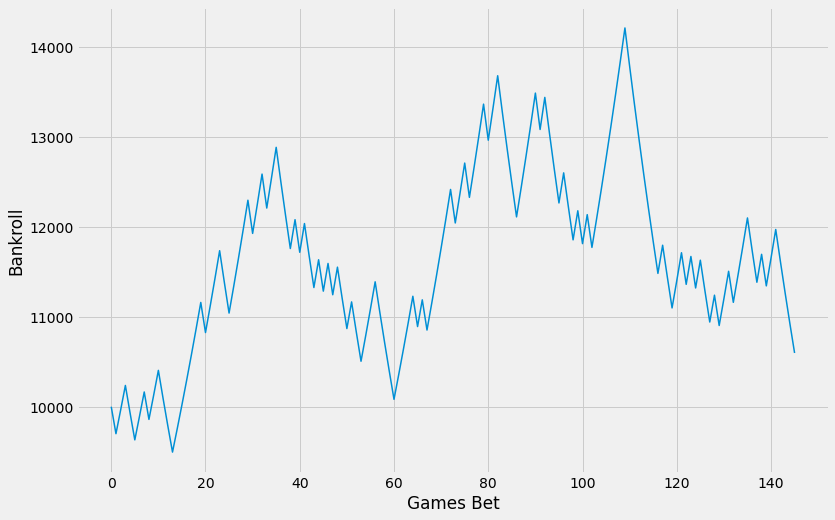

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        1               IND               -4  IND vs. NYK              -9.5   
1        5               DET               -2  DET vs. BOS               8.0   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4       10               PHX               -5  PHX vs. LAC               3.5   
..     ...               ...              ...          ...               ...   
141    573               TOR               -4  TOR vs. PHX               3.5   
142    577               NOP               -5  NOP vs. DEN               2.5   
143    587               TOR               -5  TOR vs. POR               2.5   
144    593               HOU              -10  HOU vs. MEM               8.0   
145    598               LAC               24  LAC vs. MIL               2.5   

     en_preds  home_cover  bet_home  bet_won    bankroll_i    bet_size  \
0    3.723771           0         1        0  10000.000000  300.000000   
1    2.559869           1         1        1   9700.000000  291.000000   
2   -4.080041           0         0        1   9964.545455  298.936364   
3    3.573525           0         1        0  10236.305785  307.089174   
4    2.042165           0         1        0   9929.216612  297.876498   
..        ...         ...       ...      ...           ...         ...   
141  5.471833           0         1        0  11970.392977  359.111789   
142  2.881363           0         1        0  11611.281188  348.338436   
143  3.269273           0         1        0  11262.942752  337.888283   
144  3.477994           0         1        0  10925.054470  327.751634   
145  4.485047           1         1        1  10597.302836  317.919085   

       bankroll_n  
0     9700.000000  
1     9964.545455  
2    10236.305785  
3     9929.216612  
4     9631.340113  
..            ...  
141  11611.281188  
142  11262.942752  
143  10925.054470  
144  10597.302836  
145  10886.320186  

[146 rows x 12 columns]

In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

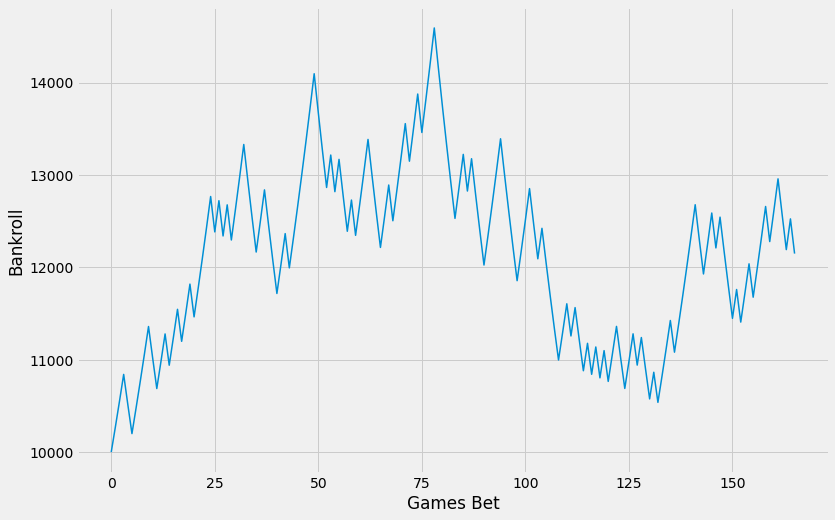

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


index TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
0        3               ATL               -5  ATL vs. CLE              -5.5   
1        4               MIN              -15  MIN vs. DEN               8.5   
2        6               BKN               -1  BKN vs. WAS              -7.5   
3        7               MEM              -14  MEM vs. LAL              10.0   
4        8               SAS              -21  SAS vs. UTA               5.5   
..     ...               ...              ...          ...               ...   
161    548               MIL               27  MIL vs. IND              -7.0   
162    552               MIA              -10  MIA vs. PHX               2.0   
163    589               BOS               -6  BOS vs. NOP              -3.0   
164    593               HOU              -10  HOU vs. MEM               8.0   
165    596               UTA               39  UTA vs. CLE             -16.5   

     spread+diff  net_preds  home_cover  bet_home  bet_won    bankroll_i  \
0          -10.5  -7.630116           0         0        1  10000.000000   
1           -6.5 -17.511482           0         0        1  10272.727273   
2           -8.5 -24.358429           0         0        1  10552.892562   
3           -4.0  10.259763           0         1        0  10840.698723   
4          -15.5   8.119968           0         1        0  10515.477761   
..           ...        ...         ...       ...      ...           ...   
161         20.0  -7.958269           1         0        0  12957.206559   
162         -8.0   7.853865           0         1        0  12568.490362   
163         -9.0  -7.221478           0         0        1  12191.435651   
164         -2.0   8.024974           0         1        0  12523.929351   
165         22.5  -7.486481           1         0        0  12148.211470   

       bet_size    bankroll_n  
0    300.000000  10272.727273  
1    308.181818  10552.892562  
2    316.586777  10840.698723  
3    325.220962  10515.477761  
4    315.464333  10200.013428  
..          ...           ...  
161  388.716197  12568.490362  
162  377.054711  12191.435651  
163  365.743070  12523.929351  
164  375.717881  12148.211470  
165  364.446344  11783.765126  

[166 rows x 13 columns]

In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

TEAM_ABBREVIATION  point_diff_team      MATCHUP  home_spread_mode  \
14                MIL               10  MIL vs. DET             -16.0   
25                NOP               -1  NOP vs. OKC              -8.0   
28                MIL               15  MIL vs. DET             -12.0   
31                MIA               -2  MIA vs. BOS              -2.5   
40                POR               18  POR vs. MIN             -10.0   
49                BOS                9  BOS vs. WAS              -3.5   
56                MIN               -3  MIN vs. SAS               3.5   
61                HOU              -18  HOU vs. LAL               3.5   
62                NYK              -25  NYK vs. DEN               5.5   
63                LAC                3  LAC vs. CHI             -12.5   
103               POR                6  POR vs. ATL              -5.0   
104               DAL              -16  DAL vs. CHI              -6.5   
116               POR              -21  POR vs. SAS               1.5   
118               UTA               16  UTA vs. NOP              -6.5   
121               LAC               19  LAC vs. SAC             -11.0   
130               GSW              -15  GSW vs. NYK              -5.0   
157               CLE               -7  CLE vs. LAL              12.0   
165               UTA               14  UTA vs. NYK             -11.0   
229               CHA               -7  CHA vs. PHI               7.0   
246               PHI               16  PHI vs. BKN              -7.5   
269               UTA               14  UTA vs. BOS              -5.5   
272               NOP               29  NOP vs. HOU              -6.5   
306               DET               11  DET vs. NOP               5.5   
307               LAC               17  LAC vs. CLE              -9.0   
309               TOR               -4  TOR vs. MIN              -7.5   
316               GSW               31  GSW vs. CLE             -11.0   
348               MIL               13  MIL vs. OKC             -11.0   
352               POR               -7  POR vs. WAS              -4.5   
359               TOR                7  TOR vs. PHI               3.0   
365               UTA               22  UTA vs. CHA             -12.5   
370               LAC               19  LAC vs. WAS             -12.0   
379               UTA               25  UTA vs. LAL              -8.5   
380               PHX               -3  PHX vs. CHA              -9.5   
383               NOP               10  NOP vs. DET             -11.5   
410               HOU              -49  HOU vs. MEM               4.0   
420               HOU              -11  HOU vs. CLE              -3.0   
435               HOU              -18  HOU vs. BKN              10.5   
479               ATL               18  ATL vs. CLE              -5.5   
487               CHA                6  CHA vs. SAC              -3.5   
497               POR                1  POR vs. NOP              -2.0   
537               CLE               11  CLE vs. TOR               7.0   
548               MIL               27  MIL vs. IND              -7.0   
559               ORL                1  ORL vs. PHX               9.5   
572               DET               -2  DET vs. BKN               6.5   

     net_preds  home_cover  bet_home  bet_won  
14    0.176570           0         1        0  
25    0.033497           0         1        0  
28    0.113456           1         1        1  
31    0.000057           0         1        0  
40    0.032014           1         1        1  
49    0.029540           1         1        1  
56    0.087571           1         1        1  
61    0.029953           0         1        0  
62    0.009299           0         1        0  
63    0.000713           0         1        0  
103   0.007039           1         1        1  
104   0.024863           0         1        0  
116   0.015959           0         1        0  
118   0.011476           1         1        1 

In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [447]:
df1

SEASON_YEAR_team  SEASON_ID_team  TEAM_ID_team TEAM_ABBREVIATION_team  \
0             2020-21           22020    1610612746                    LAC   
1             2020-21           22020    1610612746                    LAC   
2             2020-21           22020    1610612746                    LAC   
3             2020-21           22020    1610612746                    LAC   
4             2020-21           22020    1610612746                    LAC   
...               ...             ...           ...                    ...   
1421          2020-21           22020    1610612760                    OKC   
1422          2020-21           22020    1610612760                    OKC   
1423          2020-21           22020    1610612760                    OKC   
1424          2020-21           22020    1610612760                    OKC   
1425          2020-21           22020    1610612760                    OKC   

             TEAM_NAME_team   GAME_ID GAME_DATE_team MATCHUP_team  \
0               LA Clippers  22000002     2020-12-22    LAC @ LAL   
1               LA Clippers  22000009     2020-12-25    LAC @ DEN   
2               LA Clippers  22000031     2020-12-27  LAC vs. DAL   
3               LA Clippers  22000054     2020-12-29  LAC vs. MIN   
4               LA Clippers  22000061     2020-12-30  LAC vs. POR   
...                     ...       ...            ...          ...   
1421  Oklahoma City Thunder  22000654     2021-03-22    OKC @ MIN   
1422  Oklahoma City Thunder  22000674     2021-03-24  OKC vs. MEM   
1423  Oklahoma City Thunder  22000713     2021-03-29  OKC vs. DAL   
1424  Oklahoma City Thunder  22000727     2021-03-31  OKC vs. TOR   
1425  Oklahoma City Thunder  22000744     2021-04-02    OKC @ PHX   

      HOME_GAME_team  TEAM_SCORE_team  point_diff_team  WL_team  MIN_team  \
0                  0              116                7        1       240   
1                  0              121               13        1       240   
2                  1               73              -51        0       240   
3                  1              124               23        1       240   
4                  1              128               23        1       240   
...              ...              ...              ...      ...       ...   
1421               0              112                9        1       240   
1422               1              107               -9        0       240   
1423               1              106              -21        0       240   
1424               1              113               10        1       240   
1425               0              103              -37        0       240   

      home_spread_mode  WL_record  ATS_record  RECORD_team  team_covered  \
0                 -2.0        NaN         NaN          NaN           NaN   
1                  4.0   1.000000    1.000000          NaN           NaN   
2                 -3.0   1.000000    1.000000          NaN           NaN   
3                -11.0   0.666667    0.666667          NaN           NaN   
4                 -6.0   0.750000    0.750000          NaN           NaN   
...                ...        ...         ...          ...           ...   
1421              -5.0   0.428571    0.523810     0.462632      0.503451   
1422               7.0   0.441860    0.534884     0.516954      0.553647   
1423              11.5   0.431818    0.522727     0.464753      0.497740   
1424               NaN   0.422222    0.511111     0.417868      0.447528   
1425               NaN   0.434783    0.500000     0.476542      0.402421   

      FG2M_team  FG2A_team  FG3M_team  FG3A_team   FTM_team   FTA_team  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN     

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.179463      -0.0744681        -0.130346   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0         0.0100565       0.771314        1.38298   -0.000764037   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0        3.60108       1.18658      0.615254        -0.3409       -3.48034   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -3.82125       3.28415       2.38366      0.670353      -2.05369   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      3.52316       2.72691            -0.580535              -0.945318   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              1.11265              -0.177191               1.1315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              -0.786312           -0.0324955        1.48803   -0.00496232   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.20019          3.19163               4.46767   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             2.72338           2.67205           -1.99951          0.718132   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.695025             3.30745        0.130346     -0.135756   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0       1.99365      0.416147       -3.4697      2.33052      2.30673   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00117765       2.07533      2.07415      2.90665     -2.29005   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.671452      3.54816    0.931445      3.30745            0.580535   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0             -0.177191              1.1315             -0.945318   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             1.11265              0.786312           0.0324955       1.81846   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00496232             1.39736         3.59304             -4.42725   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -1.72532          2.22005          -2.37193         0.657797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.346865         -0.0158015          0.017094          -0.017094   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0         0.0158015        -0.0326693        0.0326693       -0.0169042   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0238796        -0.0201873        0.0145145             2.89928   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.42549          -2.17765          2.81216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.386336    1326.610905    1406.997375           0.7

### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


away_team home_team   game_date away_spread1 away_spread2  away_spread3  \
0       DAL       WAS  2021-04-03     -4.5-110     -4.5-112          -4.5   
1       CLE       MIA  2021-04-03       12-110       12-108          12.5   
2       MIN       PHI  2021-04-03       13-110       12-110          13.5   
3       NYK       DET  2021-04-03     -1.5-110     -1.5-113          -1.5   
4       IND       SAS  2021-04-03        6-110      4.5-113           5.5   
5       ORL       UTA  2021-04-03       15-110       15-110          15.0   
6       MIL       SAC  2021-04-03       -6-105     -6.5-110          -5.5   
7       OKC       POR  2021-04-03     11.5-110     11.5-105          11.5   

   away_spread4  home_spread1  home_spread2  home_spread3  home_spread4  \
0          -4.5           4.5           4.5           4.5           4.5   
1          12.0         -12.0         -12.0         -12.5         -12.0   
2          13.0         -13.0         -12.0         -13.5         -13.0   
3          -1.5           1.5           1.5           1.5           1.5   
4           6.0          -6.0          -4.5          -5.5          -6.0   
5          14.5         -15.0         -15.0         -15.0         -14.5   
6          -5.5           6.0           6.5           5.5           5.5   
7          11.5         -11.5         -11.5         -11.5         -11.5   

  away_spread_mode  home_spread_mode  
0             -4.5               4.5  
1             12.5             -12.0  
2           13-110             -13.0  
3             -1.5               1.5  
4            6-110              -6.0  
5           15-110             -15.0  
6             -5.5               5.5  
7             11.5             -11.5

In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


home_spread_mode WL_record_diff ATS_record_diff RECORD_team_diff  \
0                -3      -0.183092      -0.0763285        -0.144892   

  team_covered_diff FG2M_team_diff FG2A_team_diff FG3M_team_diff  \
0          0.011143        1.19352        2.20987   -0.000726966   

  FG3A_team_diff FTM_team_diff FTA_team_diff OREB_team_diff DREB_team_diff  \
0         3.2203       1.87994       1.69273       0.741648       -2.30137   

  REB_team_diff AST_team_diff STL_team_diff BLK_team_diff TOV_team_diff  \
0      -1.55972       2.97972       1.86619      0.521539      -1.49935   

  PF_team_diff PTS_team_diff PLUS_MINUS_team_diff E_OFF_RATING_team_diff  \
0      4.14165        4.2648             0.363874               0.192724   

  OFF_RATING_team_diff E_DEF_RATING_team_diff DEF_RATING_team_diff  \
0              2.11145               0.115911              1.12315   

  E_NET_RATING_team_diff NET_RATING_team_diff POSS_team_diff PIE_team_diff  \
0              0.0677887             0.984322        1.99059   -0.00237432   

  PTS_2PT_MR_team_diff PTS_FB_team_diff PTS_OFF_TOV_team_diff  \
0             -1.44673          3.10111               3.84759   

  PTS_PAINT_team_diff AST_2PM_team_diff UAST_2PM_team_diff AST_3PM_team_diff  \
0             3.58807           2.97124           -1.88749         0.0143575   

  UAST_3PM_team_diff TEAM_SCORE_opp_diff RECORD_opp_diff FG2M_opp_diff  \
0          -0.100572             3.90093        0.144892       -1.1599   

  FG2A_opp_diff FG3M_opp_diff FG3A_opp_diff FTM_opp_diff FTA_opp_diff  \
0      0.536119       1.02301      -1.28157      3.15171      2.90113   

  OREB_opp_diff DREB_opp_diff REB_opp_diff AST_opp_diff STL_opp_diff  \
0   -0.00155193       1.63512      1.63357      3.34388     -1.87421   

  BLK_opp_diff TOV_opp_diff PF_opp_diff PTS_opp_diff PLUS_MINUS_opp_diff  \
0     0.858817      2.82509     1.82035      3.90093           -0.363874   

  E_OFF_RATING_opp_diff OFF_RATING_opp_diff E_DEF_RATING_opp_diff  \
0              0.115911             1.12315              0.192724   

  DEF_RATING_opp_diff E_NET_RATING_opp_diff NET_RATING_opp_diff POSS_opp_diff  \
0             2.11145            -0.0677887           -0.984322       2.35787   

  PIE_opp_diff PTS_2PT_MR_opp_diff PTS_FB_opp_diff PTS_OFF_TOV_opp_diff  \
0   0.00237432            0.095416         3.99595              -3.6913   

  PTS_PAINT_opp_diff AST_2PM_opp_diff UAST_2PM_opp_diff AST_3PM_opp_diff  \
0           -2.36804          2.24413          -3.42199           1.1797   

  UAST_3PM_opp_diff OREB_PCT_team_diff OREB_PCT_opp_diff DREB_PCT_team_diff  \
0         -0.161641         0.00481673         0.0116754         -0.0116754   

  DREB_PCT_opp_diff REB_PCT_team_diff REB_PCT_opp_diff TS_PCT_team_diff  \
0       -0.00481673         -0.017652         0.017652       -0.0128075   

  TS_PCT_opp_diff EFG_PCT_team_diff EFG_PCT_opp_diff AST_RATIO_team_diff  \
0       0.0213821         -0.017978       0.00875831              2.4739   

  AST_RATIO_opp_diff TOV_PCT_team_diff TOV_PCT_opp_diff rest_diff  \
0            2.70151          -1.85381           2.1216         0   

   home_elo_pred  home_rating_i  away_rating_i  elo_MOV_pred  
0       0.383526    1329.036655    1411.484854          0.63

In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


away_team home_team  spread   game_date        net_pred
0       DAL       WAS     4.5  2021-04-03    [-2.0314543]
1       CLE       MIA   -12.0  2021-04-03    [-0.7431023]
2       MIN       PHI   -13.0  2021-04-03     [-2.774469]
3       NYK       DET     1.5  2021-04-03    [0.21155608]
4       IND       SAS    -6.0  2021-04-03    [-1.0953536]
5       ORL       UTA   -15.0  2021-04-03  [-0.026118085]
6       MIL       SAC     5.5  2021-04-03    [0.10418765]
7       OKC       POR   -11.5  2021-04-03     [-2.474314]

In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df